<a href="https://colab.research.google.com/github/NarawitPrathansap/bsc_dpbm22/blob/main/1_midterm_dpdm22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## การเตรียมข้อมูลประกอบด้วย กำจัด outlier, แก้ missing, normalization, one-hot-encoder และ อื่นๆ ที่นักศึกษาเห็นว่าเหมาะสม

# 1 ทำนายราคาบ้าน 10 คะแนน
เตรียมข้อมูลเพื่อทำนายราคาบ้าน ราคาประเมินบ้าน และ คะแนนทรัพย์ จาก [google drive](https://drive.google.com/drive/folders/1uIcUFY1yldIq-A3wijh2n2N6az-EljIe?usp=sharing) โดยข้อมูลที่เตรียมต้องประกอบด้วย columns ต่อไปนี้

* ```'renovate','number_of_rai','number_of_ngan','number_of_va','number_of_story','number_of_bedroom','number_of_bathroom','direction','furniture','usable_area','number_of_parking', 'sell_price'``` จากตาราง "Data House"

* ```จำนวน 7-11 และ โรงเรียน ในรัศมี 200,500,1000,2000 เมตร (ตั้งชื่อ d200-7/11','d500-7/11',...,'d2000-7/11' แบะ ;d200-school','d500-school',...,'d2000-school')``` จากตาราง "7-eleven.json" และ "school.json"

* ```ประเมินราคาซื้อขาย และ คะแนนทรัพย์ (ตั้งชื่อ 'estimator' และ 'score')``` จากตาราง คำตอบนักประเมิน(ID) โดยราคาประเมินกับคะแนนทรัพย์ อ้างอิงของนักประเมิน ID=01 คนเดียว

In [2209]:
import pandas as pd
import json
from sklearn.metrics import mean_absolute_percentage_error as MAPE
import numpy as np

In [2210]:
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
import matplotlib as mpl
mpl.font_manager.fontManager.addfont('thsarabunnew-webfont.ttf')
mpl.rc('font', family='TH Sarabun New')

In [2211]:
from google.colab import drive # เชื่อมเข้ากับ Drive
drive.mount('/content/drive')  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## บ้านมือ1_CLEAN

In [2212]:
#บ้านมือ 1
Home = pd.read_excel('/content/drive/MyDrive/bsc_DPBM_data_N/MIDterm/Data House.xlsx', sheet_name='บ้านมือ1')


In [2213]:
# เลือกเฉพาะคอลัมน์ที่ต้องการ
Home = Home[['id','latitude','longitude','number_of_rai','number_of_ngan','number_of_va','number_of_story','number_of_bedroom','number_of_bathroom','direction','furniture','usable_area','number_of_parking', 'sell_price']]
Home.head(3)

,id,latitude,longitude,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price
0,625f8ce8f18e1c0013e80bd9,103.084464,16.711007,NaN,NaN,NaN,1.0,2.0,2.0,NaN,NaN,97.0,2.0,1790000.0
1,62204519412ede001495e6cb,102.875722,16.484111,NaN,NaN,NaN,1.0,3.0,2.0,NaN,NaN,125.0,2.0,2290000.0
2,project_1948,102.872089,16.420317,NaN,NaN,NaN,2.0,5.0,2.0,NaN,NaN,180.0,1.0,3200000.0


### Missing & Replace

In [2214]:
Home.isnull().any() #ตรวจสอบว่ามีคอลัมน์ไหนบ้างที่มีค่า  missing ถ้า เป็น Ture = มี missing

id                    False
latitude               True
longitude              True
number_of_rai          True
number_of_ngan         True
number_of_va           True
number_of_story        True
number_of_bedroom      True
number_of_bathroom     True
direction              True
furniture              True
usable_area            True
number_of_parking      True
sell_price             True
dtype: bool

In [2215]:
Home.dtypes #ตรวจสอบชนิดของแต่ละคอลัมน์

id                     object
latitude              float64
longitude             float64
number_of_rai         float64
number_of_ngan        float64
number_of_va          float64
number_of_story       float64
number_of_bedroom     float64
number_of_bathroom    float64
direction             float64
furniture             float64
usable_area           float64
number_of_parking     float64
sell_price            float64
dtype: object

In [2216]:
Home = Home.drop_duplicates(subset=['id']) #drob id ที่ซ้ำออกเพราะว่า id บ้านควรมี id เดียว//มีเอกลักษณ์

In [2217]:
# 1 drop nan in columns 'latitude','longitude' bc.ไม่ทราบค่า lat&long
Home.dropna(subset=['latitude','longitude'],inplace= True ) # 2columnsนี้จะไม่มี missingแน่นอน

In [2218]:
#2 fillna eq 0 in 'number_of_rai','number_of_ngan','number_of_va', 'usable_area','number_of_parking' จะตรวจสอบดูว่า มีคอลัมน์ไไหนเป็น 0 ทั้ง 3
Home[['number_of_rai','number_of_ngan','number_of_va', 'usable_area','number_of_parking']] = Home[['number_of_rai','number_of_ngan','number_of_va', 'usable_area','number_of_parking']].fillna(0) 
#3 fillna eq 1 in 'number_of_story','number_of_bedroom','number_of_bathroom' อิงจากความเป็นจริงที่บ้านควรจะเป็น
Home[['number_of_story','number_of_bedroom','number_of_bathroom']] = Home[['number_of_story','number_of_bedroom','number_of_bathroom']].fillna(1)
#4 fillna = ไม่ระบุ in 'furniture' ถ้าว่าง = ไม่ระบุ
Home[['furniture']] = Home[['furniture']].fillna('ไม่ระบุ')
#5 replace 0 = ไม่มี in 'furniture' 
Home.loc[Home['furniture'] == 0,'furniture'] = 'ไม่มี'
#6 fillna = ไม่ระบุ in 'direction' ถ้าว่าง = ไม่ระบุตำแหน่งที่ตั้ง
Home[['direction']] = Home[['direction']].fillna('ไม่ระบุ')
#7 replace 0 = ไม่ระบุ in 'direction' 
Home.loc[Home['direction'] == 0,'direction'] = 'ไม่ระบุ'
#8 replace 0 = 1 in 'number_of_story' bc อย่างน้อยบ้านควรมี 1 ชั้น
Home.loc[Home['number_of_story'] == 0,'number_of_story'] = 1
#9 replace 0 = 1 in 'number_of_bedroom' bc อย่างน้อยบ้านควรมี 1 ห้องนอน
Home.loc[Home['number_of_bedroom'] == 0,'number_of_bedroom'] = 1
#10 replace 0 = 1 in 'number_of_bathroom' bc อย่างน้อยบ้านควรมี 1 ห้องน้ำ
Home.loc[Home['number_of_bathroom'] == 0,'number_of_bathroom'] = 1

In [2219]:
Home.isnull().any() # ตรวจสอบดูว่ายังมี  missing อีกมั้ย

id                    False
latitude              False
longitude             False
number_of_rai         False
number_of_ngan        False
number_of_va          False
number_of_story       False
number_of_bedroom     False
number_of_bathroom    False
direction             False
furniture             False
usable_area           False
number_of_parking     False
sell_price             True
dtype: bool

In [2220]:
Home.head(3)

,id,latitude,longitude,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price
0,625f8ce8f18e1c0013e80bd9,103.084464,16.711007,0.0,0.0,0.0,1.0,2.0,2.0,ไม่ระบุ,ไม่ระบุ,97.0,2.0,1790000.0
1,62204519412ede001495e6cb,102.875722,16.484111,0.0,0.0,0.0,1.0,3.0,2.0,ไม่ระบุ,ไม่ระบุ,125.0,2.0,2290000.0
2,project_1948,102.872089,16.420317,0.0,0.0,0.0,2.0,5.0,2.0,ไม่ระบุ,ไม่ระบุ,180.0,1.0,3200000.0


In [2221]:
Home_area = Home[(Home['number_of_rai'] == 0) & (Home['number_of_ngan']== 0) & (Home['number_of_va']== 0) & (Home['usable_area']== 0) == False] #ไม่เอาคอลัมน์ที่พท.เป็น 0 ทั้งหมด  เพระาว่าเราไม่ทราบค่าพท.เลยจะไม่เอา

In [2222]:
#  วนลูปเพิ่มค่าในคอลัมน์
# เพิ่ม คอลัมน์ second_hand เก็บค่า บ้านมือ 1 
A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in Home_area.iterrows(): # วนลูปใน list
    A.append('บ้านมือ1')
Home_area['second_hand'] = A  

# เพิ่ม คอลัมน์ renovate เก็บค่า no
A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in Home_area.iterrows(): # วนลูปใน list
    A.append('no')
Home_area['renovate'] = A  

print(len(Home_area))
Home_area.head(3)


693


<ipython-input-2222-703fb41bb7a5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Home_area['second_hand'] = A
<ipython-input-2222-703fb41bb7a5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Home_area['renovate'] = A


,id,latitude,longitude,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,second_hand,renovate
0,625f8ce8f18e1c0013e80bd9,103.084464,16.711007,0.0,0.0,0.0,1.0,2.0,2.0,ไม่ระบุ,ไม่ระบุ,97.0,2.0,1790000.0,บ้านมือ1,no
1,62204519412ede001495e6cb,102.875722,16.484111,0.0,0.0,0.0,1.0,3.0,2.0,ไม่ระบุ,ไม่ระบุ,125.0,2.0,2290000.0,บ้านมือ1,no
2,project_1948,102.872089,16.420317,0.0,0.0,0.0,2.0,5.0,2.0,ไม่ระบุ,ไม่ระบุ,180.0,1.0,3200000.0,บ้านมือ1,no


In [2223]:
#ตรวจดูว่ามีค่า sell price = 0 / null เท่าไหร่ ถ้าไม่เยอะจะได้ตัดออก เพราะเราต้องการเอา sell price ไปเป็นตัวแบ่งกลุ่ม
print(len(Home_area[Home_area['sell_price'].isnull()])) 
Home_area[Home_area['sell_price'].eq(0)]

8


,id,latitude,longitude,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,second_hand,renovate
115,335.0,16.549816,102.840579,0.0,0.0,85.0,1.0,3.0,2.0,ไม่ระบุ,ไม่มี,0.0,1.0,0.0,บ้านมือ1,no
662,3656.0,16.390723,102.826175,0.0,0.0,23.0,2.0,1.0,3.0,ไม่ระบุ,ไม่มี,135.0,2.0,0.0,บ้านมือ1,no


In [2224]:
# เนื่องจากตรวจสอบดูแล้วมี sell price =0/ null 11 ตัว ซึ่งไม่มากเมื่อเทียบกับข้อมูลทั้งหมด  693 ตัว เลยจะทำการตัดออก
Home_area = Home_area.dropna(subset=['sell_price'])
Home_area = Home_area[Home_area['sell_price'].eq(0) == False]

In [2225]:
Home_area[['usable_area','sell_price','number_of_va']].corr() # chece corr ดูเฉยๆ

,usable_area,sell_price,number_of_va
usable_area,1.000000,0.576309,0.505576
sell_price,0.576309,1.000000,0.517131
number_of_va,0.505576,0.517131,1.000000


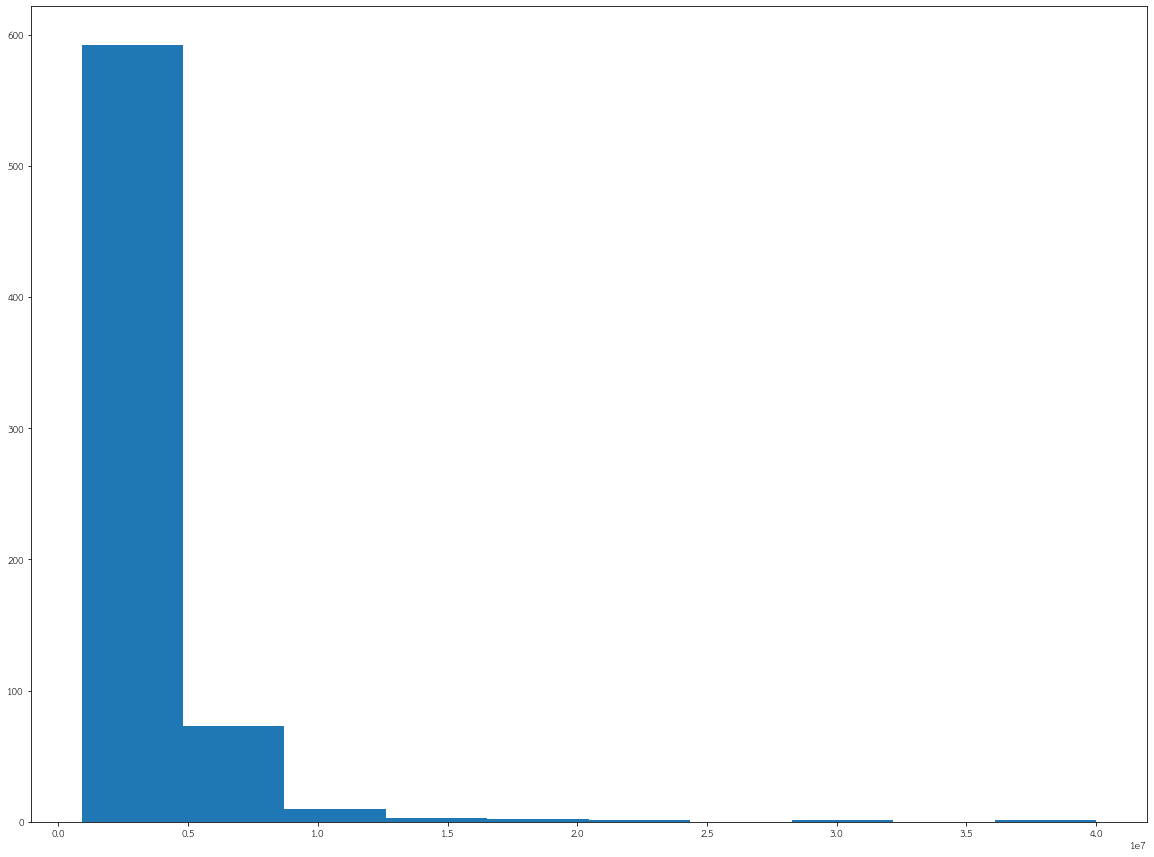

In [2226]:
#plot hist sellprice เพื่อดูการกระจายของข้อมูล เพื่อใช้พิจจารณาในการแบ่งกลุ่ม
from matplotlib import pyplot as plt
mpl.rcParams['figure.figsize']=[20,15]
plt.hist(Home_area['sell_price']); #ดูการกระจายของข้อมูล

In [2227]:
Home_area['sell_price'].min()

890000.0

In [2228]:
# แบ่งกลุ่มข้อมูลออกตามราคาบ้าน
def filter(x):
    if x < 5000000:
       return "1"
    if x >= 5000000 and x <= 10000000:
       return "2"
    if x > 10000000:
       return "3"

In [2229]:
Home_area['price_class'] = Home_area['sell_price'].apply(filter)
#Opendata.groupby(['FBS_class'])[['รายชื่อ']].count().reset_index()

In [2230]:
Home_area.head(3)

,id,latitude,longitude,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,second_hand,renovate,price_class
0,625f8ce8f18e1c0013e80bd9,103.084464,16.711007,0.0,0.0,0.0,1.0,2.0,2.0,ไม่ระบุ,ไม่ระบุ,97.0,2.0,1790000.0,บ้านมือ1,no,1
1,62204519412ede001495e6cb,102.875722,16.484111,0.0,0.0,0.0,1.0,3.0,2.0,ไม่ระบุ,ไม่ระบุ,125.0,2.0,2290000.0,บ้านมือ1,no,1
2,project_1948,102.872089,16.420317,0.0,0.0,0.0,2.0,5.0,2.0,ไม่ระบุ,ไม่ระบุ,180.0,1.0,3200000.0,บ้านมือ1,no,1


In [2231]:
#แบ่งกลุ่มมข้อมูล ตาม class ที่ได้
a1 = Home_area[Home_area['price_class']== '1']
a2 = Home_area[Home_area['price_class']== '2']
a3 = Home_area[Home_area['price_class']== '3']

In [2232]:
# ทำการแทน ค่า 0 ในคอลัมน์ usable_area และ number_of_va ด้วยค่าเฉลี่ยภายในกลุ่มที่ได้แบ่งไป เนื่องจากว่า ถ้าหากมีพท.บ้าน อย่างน้อยก็ควรที่จะมีพท.เป็นวา 
a1['usable_area'] = a1['usable_area'].replace(0,a1['usable_area'].mean())
a1['number_of_va'] = a1['number_of_va'].replace(0,a1['number_of_va'].mean())

a2['usable_area'] = a2['usable_area'].replace(0,a2['usable_area'].mean())
a2['number_of_va'] = a2['number_of_va'].replace(0,a2['number_of_va'].mean())

a3['usable_area'] = a3['usable_area'].replace(0,a3['usable_area'].mean())
a3['number_of_va'] = a3['number_of_va'].replace(0,a3['number_of_va'].mean())

<ipython-input-2232-361f378c3960>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1['usable_area'] = a1['usable_area'].replace(0,a1['usable_area'].mean())
<ipython-input-2232-361f378c3960>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1['number_of_va'] = a1['number_of_va'].replace(0,a1['number_of_va'].mean())
<ipython-input-2232-361f378c3960>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

### ตารางที่ผ่านการ clean

In [2233]:
# รวมตาราง
Home1_clean = pd.concat([a1,a2,a3])
Home1_clean  = Home1_clean.iloc[:,:-1] #ไม่เอาคอลัมน์สุดท้ายที่เราดูแยก class
Home1_clean.head(3)

,id,latitude,longitude,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,second_hand,renovate
0,625f8ce8f18e1c0013e80bd9,103.084464,16.711007,0.0,0.0,56.108974,1.0,2.0,2.0,ไม่ระบุ,ไม่ระบุ,97.0,2.0,1790000.0,บ้านมือ1,no
1,62204519412ede001495e6cb,102.875722,16.484111,0.0,0.0,56.108974,1.0,3.0,2.0,ไม่ระบุ,ไม่ระบุ,125.0,2.0,2290000.0,บ้านมือ1,no
2,project_1948,102.872089,16.420317,0.0,0.0,56.108974,2.0,5.0,2.0,ไม่ระบุ,ไม่ระบุ,180.0,1.0,3200000.0,บ้านมือ1,no


##  บ้านมือ2_CLEAN

In [2234]:
Home2 = pd.read_excel('/content/drive/MyDrive/bsc_DPBM_data_N/MIDterm/Data House.xlsx', sheet_name='บ้านมือ2')

In [2235]:
# เลือกเฉพาะคอลัมน์ที่ต้องการ
Home2 = Home2[['id','latitude','longitude','renovate','number_of_rai','number_of_ngan','number_of_va','number_of_story','number_of_bedroom','number_of_bathroom','direction','furniture','usable_area','number_of_parking', 'sell_price']]
Home2.head(3)

,id,latitude,longitude,renovate,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price
0,3252.0,111.0,111.0,no,0.0,0.0,77.0,1.0,3.0,2.0,ไม่ระบุ,ตกแต่งครบ,265.0,2.0,4800000.0
1,3258.0,111.0,111.0,no,0.0,0.0,77.0,1.0,3.0,2.0,ไม่ระบุ,ตกแต่งครบ,256.0,2.0,4800000.0
2,3273.0,111.0,222.0,NaN,0.0,0.0,77.0,1.0,3.0,2.0,ไม่ระบุ,ตกแต่งครบ,265.0,2.0,4800000.0


### Missing&Replace

In [2236]:
Home2.isnull().any() # ตรวจสอบว่ามีคอลัมน์ไหนที่มีค่าว่าง

id                    False
latitude               True
longitude              True
renovate               True
number_of_rai         False
number_of_ngan        False
number_of_va          False
number_of_story        True
number_of_bedroom      True
number_of_bathroom    False
direction             False
furniture             False
usable_area            True
number_of_parking      True
sell_price             True
dtype: bool

In [2237]:
Home2.dtypes # ตรวจสอบประเภทของข้อมูล

id                     object
latitude              float64
longitude             float64
renovate               object
number_of_rai         float64
number_of_ngan        float64
number_of_va          float64
number_of_story       float64
number_of_bedroom     float64
number_of_bathroom    float64
direction              object
furniture              object
usable_area           float64
number_of_parking     float64
sell_price            float64
dtype: object

In [2238]:
Home2 = Home2.drop_duplicates(subset=['id']) #เอาไอดีที่ซ้ำกันออก เพราะไอดีเเต่ละไอดีควรมีไอดีเดียว

In [2239]:
# 1 drop nan in columns 'latitude','longitude' bc.ไม่ทราบค่า lat&long
Home2.dropna(subset=['latitude','longitude'],inplace= True ) # 2columnsนี้จะไม่มี missingแน่นอน

/usr/local/lib/python3.8/dist-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [2240]:
#2 fillna = ไม่ระบุ in 'renovate' ถ้าว่าง = ไม่ระบุ
Home2[['renovate']] = Home2[['renovate']].fillna('ไม่ระบุ')
#3 fillna = 1 in 'number_of_story' อย่างน้อยบ้านควรมี 1ชั้น
Home2[['number_of_story']] = Home2[['number_of_story']].fillna(1)
#4 replace 0 = 1 in 'number_of_story' bc อย่างน้อยบ้านควรมี 1 ชั้น
Home2.loc[Home2['number_of_story'] == 0,'number_of_story'] = 1
#5 fillna = 1 in 'number_of_bedroom' อย่างน้อยบ้านควรมี 1 ห้องนอน
Home2[['number_of_bedroom']] = Home2[['number_of_bedroom']].fillna(1)
#6 replace 0 = 1 in 'number_of_bedroom' bc อย่างน้อยบ้านควรมี 1 ห้องนอน
Home2.loc[Home2['number_of_bedroom'] == 0,'number_of_bedroom'] = 1
#7 replace ให้ทิศเดียวกันมีค่าเหมือนกัน
Home2.loc[Home2['direction'] == 'ทิศเหนือ','direction'] = 'เหนือ'
#8 replace ให้ทิศเดียวกันมีค่าเหมือนกัน
Home2.loc[Home2['direction'] == 'ตะวันออกเฉียงใต้ของเมือง','direction'] = 'ตะวันออกเฉียงใต้'
#9 replace ให้ทิศเดียวกันมีค่าเหมือนกัน
Home2.loc[Home2['direction'] == 'ทิศตะวันออก','direction'] = 'ตะวันออก'
#10 replace ให้ทิศเดียวกันมีค่าเหมือนกัน
Home2.loc[Home2['direction'] == 'ทางทิศตะวันออก','direction'] = 'ตะวันออก'
#11 fillna = 0  in 'number_of_parking' บ้านไม่มีที่จอดรถก็ได้ 
Home2[['number_of_parking']] = Home2[['number_of_parking']].fillna(0)
#12 fillna = 0  in 'usable_area' จะตรวจเช็ค
Home2[['usable_area']] = Home2[['usable_area']].fillna(0)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [2241]:
Home2.isnull().any() # ตรวจเช็คว่ามีค่าว่างไหมอีกรอบ

id                    False
latitude              False
longitude             False
renovate              False
number_of_rai         False
number_of_ngan        False
number_of_va          False
number_of_story       False
number_of_bedroom     False
number_of_bathroom    False
direction             False
furniture             False
usable_area           False
number_of_parking     False
sell_price             True
dtype: bool

In [2242]:
Home2.head(3)

,id,latitude,longitude,renovate,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price
0,3252.0,111.0,111.0,no,0.0,0.0,77.0,1.0,3.0,2.0,ไม่ระบุ,ตกแต่งครบ,265.0,2.0,4800000.0
1,3258.0,111.0,111.0,no,0.0,0.0,77.0,1.0,3.0,2.0,ไม่ระบุ,ตกแต่งครบ,256.0,2.0,4800000.0
2,3273.0,111.0,222.0,ไม่ระบุ,0.0,0.0,77.0,1.0,3.0,2.0,ไม่ระบุ,ตกแต่งครบ,265.0,2.0,4800000.0


In [2243]:
Home2_area = Home2[(Home2['number_of_rai'] == 0) & (Home2['number_of_ngan']== 0) & (Home2['number_of_va']== 0) & (Home2['usable_area']== 0) == False] #ไม่เอาคอลัมน์ที่พท.เป็น 0 ทั้งหมด 

In [2244]:
# วนลูปเพิ่มคอลัมน์  second_hand ที่เก็บค่า บ้านมือ2
A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in Home2_area.iterrows(): # วนลูปใน list
    A.append('บ้านมือ2')
Home2_area['second_hand'] = A  

print(len(Home2_area))
Home2_area.head(3)


<ipython-input-2244-038fe9fcb595>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Home2_area['second_hand'] = A


1597


,id,latitude,longitude,renovate,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,second_hand
0,3252.0,111.0,111.0,no,0.0,0.0,77.0,1.0,3.0,2.0,ไม่ระบุ,ตกแต่งครบ,265.0,2.0,4800000.0,บ้านมือ2
1,3258.0,111.0,111.0,no,0.0,0.0,77.0,1.0,3.0,2.0,ไม่ระบุ,ตกแต่งครบ,256.0,2.0,4800000.0,บ้านมือ2
2,3273.0,111.0,222.0,ไม่ระบุ,0.0,0.0,77.0,1.0,3.0,2.0,ไม่ระบุ,ตกแต่งครบ,265.0,2.0,4800000.0,บ้านมือ2


In [2245]:
#ตรวจสอบดูว่ามีค่า sell_price =0 / null เท่าไหร่
print(len(Home2_area[Home2_area['sell_price'].isnull()])) 
Home2_area[Home2_area['sell_price'].eq(0)]

1


,id,latitude,longitude,renovate,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,second_hand


In [2246]:
# drop sell_price = 0 & null เพระาว่ามีค่าน้อย เเละเราจะใช้ในการจัดกลุ่มต่อ
Home2_area = Home2_area.dropna(subset=['sell_price'])
Home2_area = Home2_area[Home2_area['sell_price'].eq(0) == False]

In [2247]:
Home2_area[['usable_area','sell_price','number_of_va']].corr()

,usable_area,sell_price,number_of_va
usable_area,1.000000,0.051079,-0.038508
sell_price,0.051079,1.000000,0.016766
number_of_va,-0.038508,0.016766,1.000000


In [2248]:
Home2_area[(Home2_area['number_of_rai'] == 0) & (Home2_area['number_of_ngan']== 0) & (Home2_area['number_of_va']== 0) ] #จะเห็นว่ายังมี พท.ที่ ไร่ งาน วา เป็น 0 แต่ว่า มี พท . ใช้สอย เราต้องการที่จะเติมค่าเฉลี่ยให้กับ วา ในคอลัมน์นี้

,id,latitude,longitude,renovate,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,second_hand
22,10439P,16.809140,102.191396,no,0.0,0.0,0.0,1.0,1.0,1.0,ไม่ระบุ,ไม่ระบุ,1.0,0.0,1390000.0,บ้านมือ2
23,10497P,16.809119,102.191370,no,0.0,0.0,0.0,1.0,1.0,1.0,ไม่ระบุ,ไม่ระบุ,1.0,0.0,1390000.0,บ้านมือ2
69,17630.0,16.724213,102.449646,no,0.0,0.0,0.0,1.0,1.0,1.0,ไม่ระบุ,ไม่ระบุ,1600.0,0.0,1320000.0,บ้านมือ2
76,10444P,16.714804,103.084109,no,0.0,0.0,0.0,1.0,1.0,1.0,ไม่ระบุ,ไม่ระบุ,1.0,0.0,2150000.0,บ้านมือ2
92,17611.0,16.708573,102.775970,no,0.0,0.0,0.0,1.0,1.0,1.0,ไม่ระบุ,ไม่ระบุ,400.0,0.0,1215000.0,บ้านมือ2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492,30306P,16.110113,102.837441,ไม่ระบุ,0.0,0.0,0.0,1.0,1.0,1.0,ไม่ระบุ,ไม่ระบุ,800.0,0.0,1000000.0,บ้านมือ2
1503,30263P,16.086956,102.799695,ไม่ระบุ,0.0,0.0,0.0,2.0,4.0,4.0,ไม่ระบุ,ไม่ระบุ,130.0,0.0,2300000.0,บ้านมือ2
1526,30150P,16.056654,102.741883,ไม่ระบุ,0.0,0.0,0.0,1.0,3.0,3.0,ไม่ระบุ,ไม่ระบุ,130.0,0.0,2650000.0,บ้านมือ2
1547,30282P,16.019435,102.767685,ไม่ระบุ,0.0,0.0,0.0,2.0,3.0,3.0,ไม่ระบุ,ไม่ระบุ,130.0,2.0,2950000.0,บ้านมือ2


In [2249]:
Home2_area[Home2_area['number_of_va'].eq(0)] # แต่ปัญหาอยู่ที่ว่า มันมีแถวที่มี ค่า ในคอลัมน์ ไร่ งาน แต่ วา เป็น 0

,id,latitude,longitude,renovate,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,second_hand
7,18536.0,16.861893,102.881946,no,0.0,2.0,0.0,1.0,2.0,1.0,ไม่ระบุ,ไม่ระบุ,0.0,0.0,420000.0,บ้านมือ2
8,1240.0,16.861830,102.881790,no,0.0,2.0,0.0,1.0,2.0,1.0,ไม่ระบุ,ไม่ระบุ,0.0,0.0,420000.0,บ้านมือ2
22,10439P,16.809140,102.191396,no,0.0,0.0,0.0,1.0,1.0,1.0,ไม่ระบุ,ไม่ระบุ,1.0,0.0,1390000.0,บ้านมือ2
23,10497P,16.809119,102.191370,no,0.0,0.0,0.0,1.0,1.0,1.0,ไม่ระบุ,ไม่ระบุ,1.0,0.0,1390000.0,บ้านมือ2
38,17756.0,16.757612,101.979852,no,3.0,0.0,0.0,1.0,1.0,1.0,ไม่ระบุ,ไม่ระบุ,0.0,0.0,3000000.0,บ้านมือ2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1547,30282P,16.019435,102.767685,ไม่ระบุ,0.0,0.0,0.0,2.0,3.0,3.0,ไม่ระบุ,ไม่ระบุ,130.0,2.0,2950000.0,บ้านมือ2
1567,1550.0,15.925102,102.538291,no,3.0,0.0,0.0,1.0,3.0,2.0,ไม่ระบุ,ไม่ระบุ,133.0,1.0,5000000.0,บ้านมือ2
1578,18597.0,15.877297,102.634685,no,0.0,1.0,0.0,1.0,1.0,1.0,ไม่ระบุ,ไม่ระบุ,0.0,1.0,1233000.0,บ้านมือ2
1584,17609.0,15.857353,102.655143,no,0.0,0.0,0.0,1.0,1.0,1.0,ไม่ระบุ,ไม่ระบุ,608.0,0.0,1200000.0,บ้านมือ2


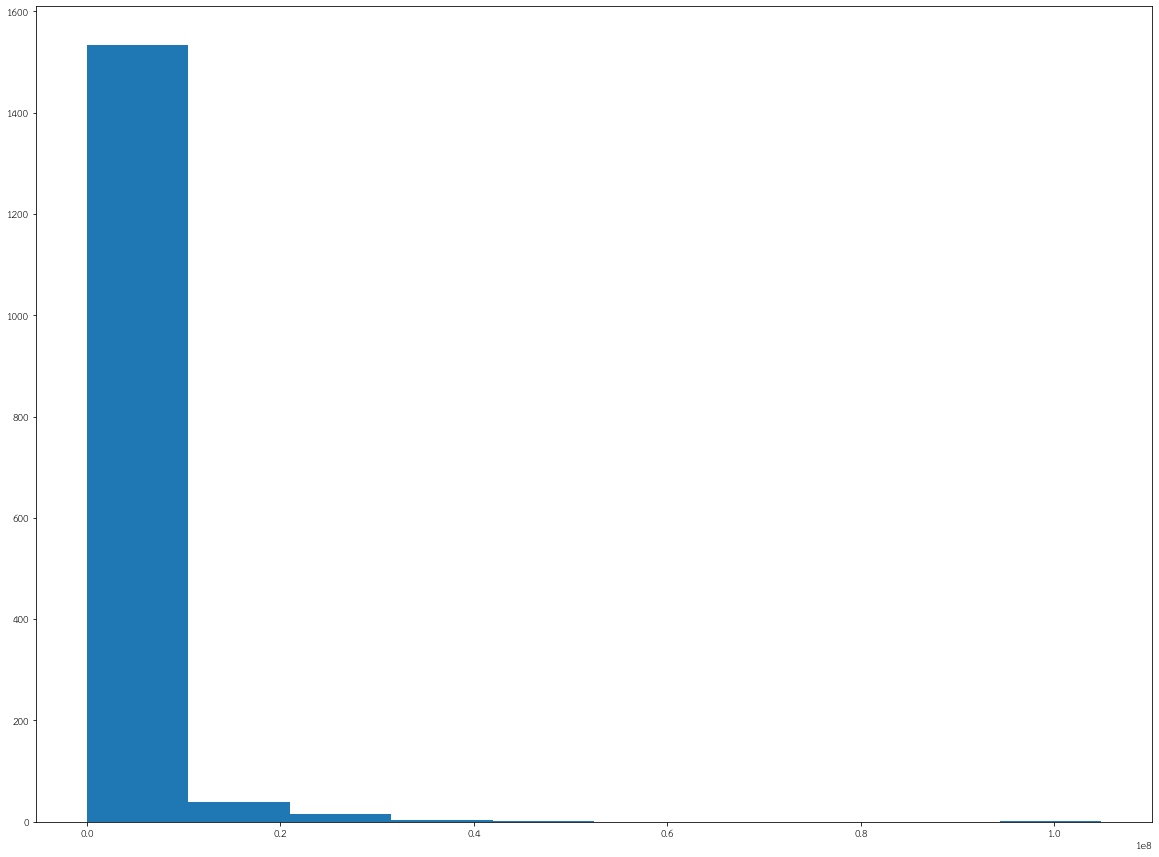

In [2250]:
# ทำการ plot กราฟ ดูการกระจายของ ข้อมูล sell_price 
from matplotlib import pyplot as plt
mpl.rcParams['figure.figsize']=[20,15]
plt.hist(Home2_area['sell_price']); #ดูการกระจายของข้อมูล

In [2251]:
Home2_area['sell_price'].min()

5000.0

In [2252]:
# แบ่งข้อมูลออกเป็นกลุ่ม
def filter(x):
    if x < 500000:
       return "1"
    if x >= 500000 and x <= 1000000:
       return "2"
    if x > 1000000:
       return "3"

In [2253]:
Home2_area['price_class'] = Home2_area['sell_price'].apply(filter)

In [2254]:
a1 = Home2_area[Home2_area['price_class']== '1']
a2 = Home2_area[Home2_area['price_class']== '2']
a3 = Home2_area[Home2_area['price_class']== '3']

In [2255]:
# แทน 0 ด้วยค่าเฉลี่ย ภายในกลุ่ม
a1['usable_area'] = a1['usable_area'].replace(0,a1['usable_area'].mean())
a1.loc[(a1['number_of_rai']<=0) & (a1['number_of_ngan']<=0) & (a1['number_of_va']<=0), 'number_of_va'] = np.mean(a1['number_of_va']) #ทำการแก้ปัญหาโดยการ ค่าค่าเฉลี่ย แทนลงไปในคอลัมน์ วา เเค่ที่ ไร่ งาน วา เป็ฯ 0

a2['usable_area'] = a2['usable_area'].replace(0,a2['usable_area'].mean())
a2.loc[(a2['number_of_rai']<=0) & (a2['number_of_ngan']<=0) & (a2['number_of_va']<=0), 'number_of_va'] = np.mean(a2['number_of_va'])

a3['usable_area'] = a3['usable_area'].replace(0,a3['usable_area'].mean())
a3.loc[(a3['number_of_rai']<=0) & (a3['number_of_ngan']<=0) & (a3['number_of_va']<=0), 'number_of_va'] = np.mean(a3['number_of_va'])

<ipython-input-2255-fe37c5ffb35b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a1['usable_area'] = a1['usable_area'].replace(0,a1['usable_area'].mean())
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
<ipython-input-2255-fe37c5ffb35b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

### ตารางที่ผ่านการ Clean -2 

In [2256]:
Home2_clean = pd.concat([a1,a2,a3])
Home2_clean = Home2_clean.iloc[:,:-1]  #ไม่เอาคอลัมน์สุดท้ายที่เราดูแยก class

## Concat บ้านมือ1 และ บ้านมือ 2 

In [2257]:
home_all =  pd.concat([Home1_clean,Home2_clean]) # concat  เพิ่มข้อมูล แกน Y
home_all

,id,latitude,longitude,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,second_hand,renovate
0,625f8ce8f18e1c0013e80bd9,103.084464,16.711007,0.0,0.0,56.108974,1.0,2.0,2.0,ไม่ระบุ,ไม่ระบุ,97.000000,2.0,1790000.0,บ้านมือ1,no
1,62204519412ede001495e6cb,102.875722,16.484111,0.0,0.0,56.108974,1.0,3.0,2.0,ไม่ระบุ,ไม่ระบุ,125.000000,2.0,2290000.0,บ้านมือ1,no
2,project_1948,102.872089,16.420317,0.0,0.0,56.108974,2.0,5.0,2.0,ไม่ระบุ,ไม่ระบุ,180.000000,1.0,3200000.0,บ้านมือ1,no
4,project_2228,102.870971,16.456282,0.0,0.0,56.108974,1.0,3.0,2.0,ไม่ระบุ,ไม่ระบุ,100.000000,0.0,1800000.0,บ้านมือ1,no
5,project_1927,102.867602,16.862644,0.0,0.0,56.108974,1.0,3.0,2.0,ไม่ระบุ,ไม่ระบุ,110.000000,1.0,1700000.0,บ้านมือ1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,6033.0,15.752374,102.392990,11.0,3.0,2.000000,1.0,1.0,1.0,ไม่ระบุ,ไม่ระบุ,143.650925,0.0,3795000.0,บ้านมือ2,no
1629,716.0,15.752150,102.393900,11.0,3.0,2.000000,1.0,1.0,1.0,ไม่ระบุ,ไม่ระบุ,143.650925,0.0,3755000.0,บ้านมือ2,no
1630,7712.0,15.708794,102.809742,3.0,0.0,0.000000,1.0,1.0,1.0,ไม่ระบุ,ไม่ระบุ,1011.000000,0.0,4081000.0,บ้านมือ2,no
1632,10378P,13.752295,100.493675,0.0,1.0,14.000000,1.0,4.0,4.0,ไม่ระบุ,มีบางส่วน,329.000000,0.0,9190000.0,บ้านมือ2,no


In [2258]:
home_all.columns

Index(['id', 'latitude', 'longitude', 'number_of_rai', 'number_of_ngan',
       'number_of_va', 'number_of_story', 'number_of_bedroom',
       'number_of_bathroom', 'direction', 'furniture', 'usable_area',
       'number_of_parking', 'sell_price', 'second_hand', 'renovate'],
      dtype='object')

## Outlier

### number_of_story

In [2259]:
home_all['number_of_story'].unique() #ดูข้อมูลที่มีทั้งหมด 

array([ 1.,  2.,  3.,  4., 32.,  5.])

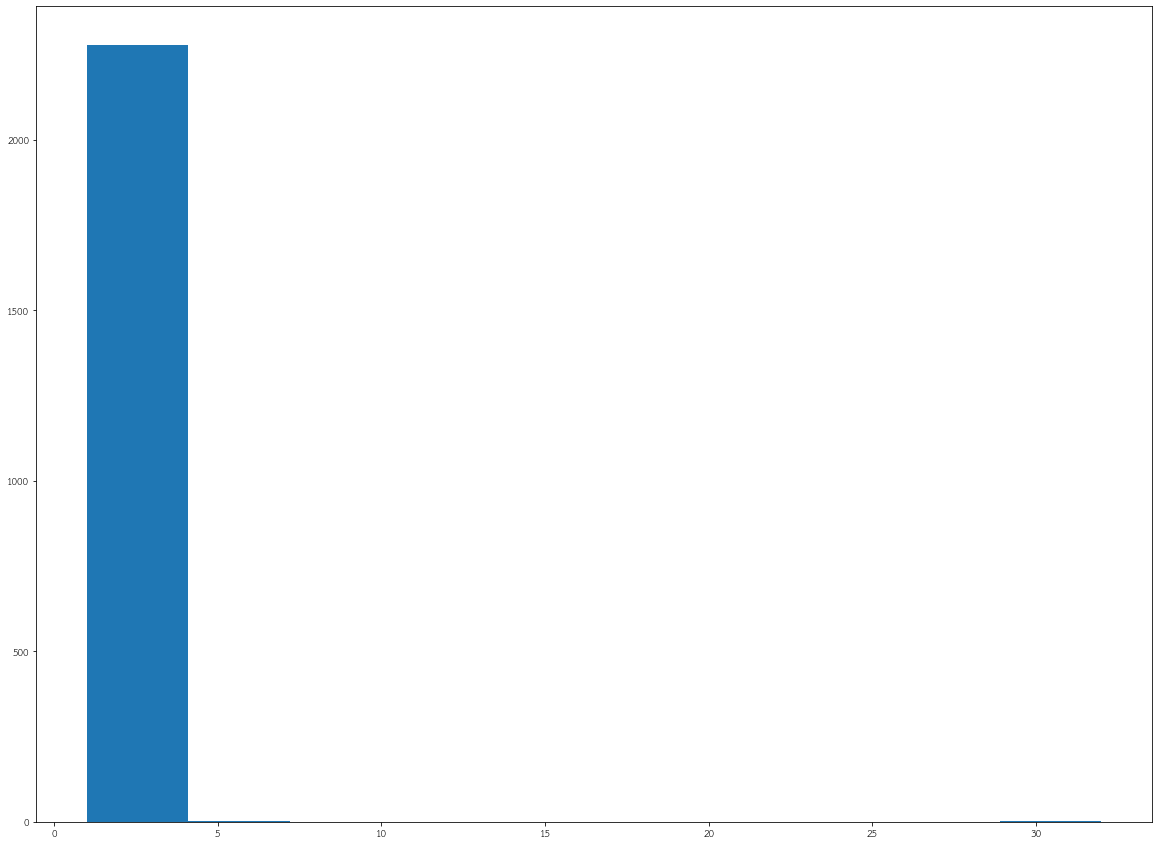

In [2260]:
plt.hist(home_all['number_of_story']); #ดูการกระจายตัวของข้อมูล

In [2261]:
home_all = home_all[home_all['number_of_story'] != 32]  # ตัดแถวที่มีค่า = 32 ใน number_of_story
print(home_all.shape)
home_all.head(3)

(2278, 16)


,id,latitude,longitude,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,second_hand,renovate
0,625f8ce8f18e1c0013e80bd9,103.084464,16.711007,0.0,0.0,56.108974,1.0,2.0,2.0,ไม่ระบุ,ไม่ระบุ,97.0,2.0,1790000.0,บ้านมือ1,no
1,62204519412ede001495e6cb,102.875722,16.484111,0.0,0.0,56.108974,1.0,3.0,2.0,ไม่ระบุ,ไม่ระบุ,125.0,2.0,2290000.0,บ้านมือ1,no
2,project_1948,102.872089,16.420317,0.0,0.0,56.108974,2.0,5.0,2.0,ไม่ระบุ,ไม่ระบุ,180.0,1.0,3200000.0,บ้านมือ1,no


### number_of_bedroom

In [2262]:
home_all['number_of_bedroom'].unique() #ดูข้อมูลที่มีทั้งหมด 

array([ 2.,  3.,  5.,  4.,  1.,  6., 40., 36.,  7., 17., 10., 24., 11.])

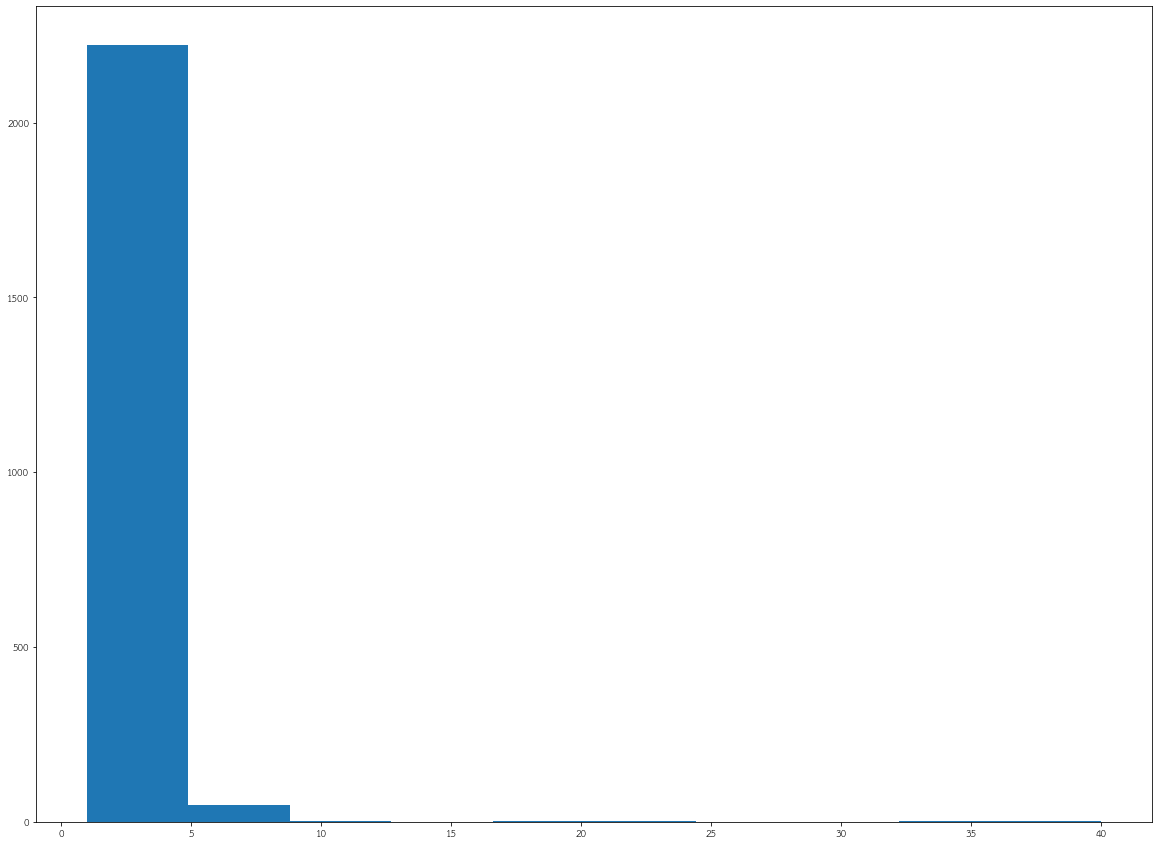

In [2263]:
plt.hist(home_all['number_of_bedroom']); #ดูการกระจายตัวของข้อมูล

In [2264]:
home_all = home_all[(home_all['number_of_bedroom'] == 40) | (home_all['number_of_bedroom'] == 17) |(home_all['number_of_bedroom'] == 36) | (home_all['number_of_bedroom'] == 24)| (home_all['number_of_bedroom'] == 10)| (home_all['number_of_bedroom'] == 11)== False]  # ตัดแถวที่เป็นแถว เก็บตกออก
print(home_all.shape)  # ตัดแถวที่มีค่า = 40,36,24,17,10,11 ใน number_of_bedroom
home_all.head(3)

(2270, 16)


,id,latitude,longitude,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,second_hand,renovate
0,625f8ce8f18e1c0013e80bd9,103.084464,16.711007,0.0,0.0,56.108974,1.0,2.0,2.0,ไม่ระบุ,ไม่ระบุ,97.0,2.0,1790000.0,บ้านมือ1,no
1,62204519412ede001495e6cb,102.875722,16.484111,0.0,0.0,56.108974,1.0,3.0,2.0,ไม่ระบุ,ไม่ระบุ,125.0,2.0,2290000.0,บ้านมือ1,no
2,project_1948,102.872089,16.420317,0.0,0.0,56.108974,2.0,5.0,2.0,ไม่ระบุ,ไม่ระบุ,180.0,1.0,3200000.0,บ้านมือ1,no


### number_of_bathroom

In [2265]:
home_all['number_of_bathroom'].unique() #ดูข้อมูลที่มีทั้งหมด 

array([2., 3., 1., 4., 6., 5.])

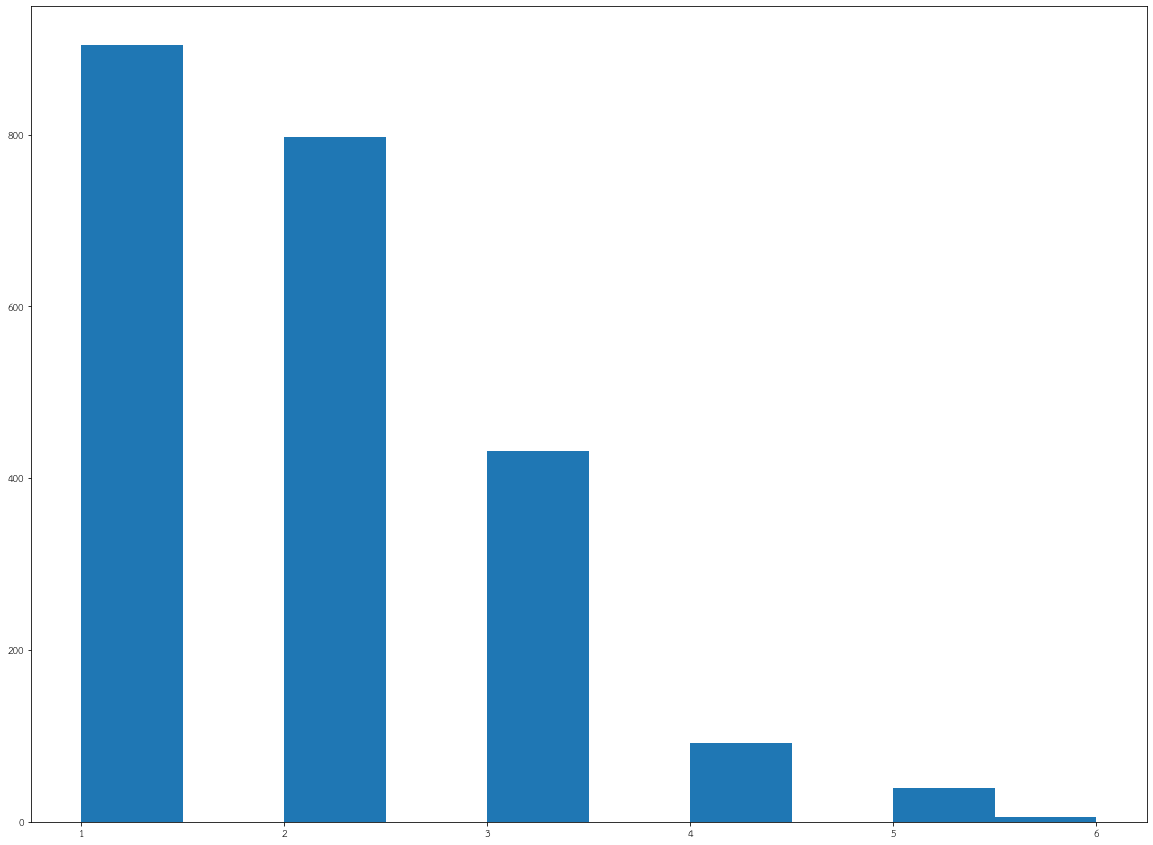

In [2266]:
plt.hist(home_all['number_of_bathroom']); #ดูการกระจายตัวของข้อมูล

### number_of_parking

In [2267]:
home_all['number_of_parking'].unique() #ดูข้อมูลที่มีทั้งหมด 

array([ 2.,  1.,  0.,  3.,  4.,  6.,  5.,  8., 10.,  7.])

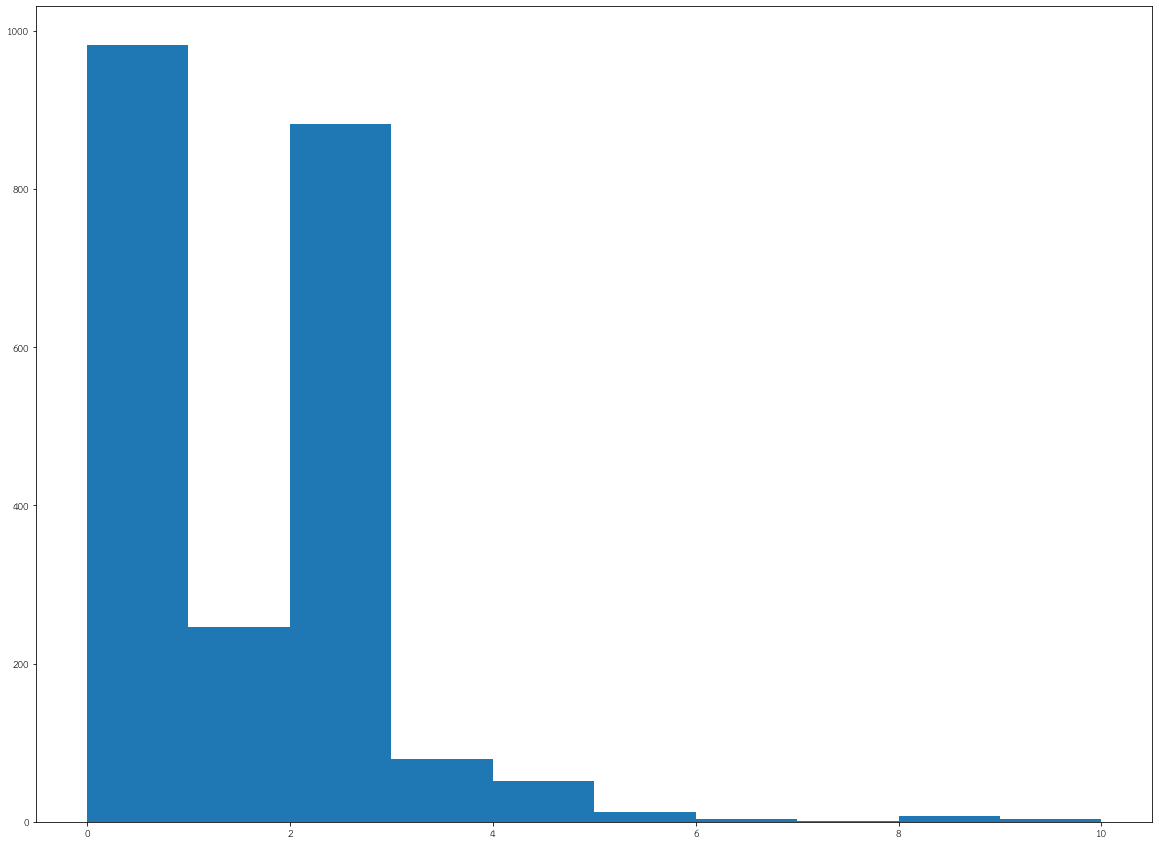

In [2268]:
plt.hist(home_all['number_of_parking']); #ดูการกระจายตัวของข้อมูล

## Distance between home & 7-11 ||  home & school 

In [2269]:
print(len(home_all))
home_all.head(3)

2270


,id,latitude,longitude,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,second_hand,renovate
0,625f8ce8f18e1c0013e80bd9,103.084464,16.711007,0.0,0.0,56.108974,1.0,2.0,2.0,ไม่ระบุ,ไม่ระบุ,97.0,2.0,1790000.0,บ้านมือ1,no
1,62204519412ede001495e6cb,102.875722,16.484111,0.0,0.0,56.108974,1.0,3.0,2.0,ไม่ระบุ,ไม่ระบุ,125.0,2.0,2290000.0,บ้านมือ1,no
2,project_1948,102.872089,16.420317,0.0,0.0,56.108974,2.0,5.0,2.0,ไม่ระบุ,ไม่ระบุ,180.0,1.0,3200000.0,บ้านมือ1,no


In [2270]:
home_all.dtypes

id                     object
latitude              float64
longitude             float64
number_of_rai         float64
number_of_ngan        float64
number_of_va          float64
number_of_story       float64
number_of_bedroom     float64
number_of_bathroom    float64
direction              object
furniture              object
usable_area           float64
number_of_parking     float64
sell_price            float64
second_hand            object
renovate               object
dtype: object

### Open json

In [2271]:
with open('/content/drive/MyDrive/bsc_DPBM_data_N/MIDterm/7-eleven.json') as json_file:  #with openเป็นการเข้าไปดูที่ไฟล์เลย
 seven_json = json.loads(json_file.read())  

In [2272]:
with open('/content/drive/MyDrive/bsc_DPBM_data_N/MIDterm/school.json') as json_file:
  school_json = json.loads(json_file.read())

In [2273]:
list(seven_json.keys())[:10] #เรียกดู key

['1', '4', '6', '7', '9', '11', '16', '17', '18', '19']

### Cal distance

In [2274]:
len(home_all[(home_all['latitude'] < -90) | (home_all['latitude'] > 90)])#เช็คlat 

47

In [2275]:
home_all = home_all[(home_all['latitude'] >= -90) & (home_all['latitude'] <= 90)]
home_all

,id,latitude,longitude,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,furniture,usable_area,number_of_parking,sell_price,second_hand,renovate
88,8011.0,16.858718,102.682227,0.0,0.0,70.0,2.0,3.0,2.0,ไม่ระบุ,ไม่มี,127.277550,2.0,1000000.0,บ้านมือ1,no
89,7467.0,16.752001,102.637726,0.0,0.0,76.0,1.0,2.0,2.0,ไม่ระบุ,ไม่มี,100.000000,2.0,1890000.0,บ้านมือ1,no
90,7468.0,16.752001,102.637726,0.0,0.0,76.0,1.0,2.0,2.0,ไม่ระบุ,ไม่มี,100.000000,2.0,1890000.0,บ้านมือ1,no
91,7487.0,16.712481,102.858146,0.0,0.0,50.0,1.0,3.0,2.0,ไม่ระบุ,ไม่มี,130.000000,2.0,2250000.0,บ้านมือ1,no
92,7501.0,16.705736,103.069333,0.0,0.0,55.0,1.0,3.0,2.0,ไม่ระบุ,ไม่มี,130.000000,2.0,2390000.0,บ้านมือ1,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,6033.0,15.752374,102.392990,11.0,3.0,2.0,1.0,1.0,1.0,ไม่ระบุ,ไม่ระบุ,143.650925,0.0,3795000.0,บ้านมือ2,no
1629,716.0,15.752150,102.393900,11.0,3.0,2.0,1.0,1.0,1.0,ไม่ระบุ,ไม่ระบุ,143.650925,0.0,3755000.0,บ้านมือ2,no
1630,7712.0,15.708794,102.809742,3.0,0.0,0.0,1.0,1.0,1.0,ไม่ระบุ,ไม่ระบุ,1011.000000,0.0,4081000.0,บ้านมือ2,no
1632,10378P,13.752295,100.493675,0.0,1.0,14.0,1.0,4.0,4.0,ไม่ระบุ,มีบางส่วน,329.000000,0.0,9190000.0,บ้านมือ2,no


In [2276]:
#วนลูปหาตำแหน่งที่ตั้งของทุก id    // ดูว่ามีเซเว่นอยู่ตรงไหนบ้าง
seven_id = {} #สร้าง dict ขึ้นมา  // เพื่อรวบรวม list ของเเต่ละโลเคชั่นไว้// เก็บไว้ เพื่อจะได้เรียกดูได้ว่าอันไหนที่มีไอดีเหมือนกันบ้้าง
for t in seven_json:
    l = list()  
    for x in seven_json[t]:
        l.append(x['geometry']['location'])
    #print(t) # t = id
    #print(l)
    seven_id[t] = l  # dict id = t สมาชิกคือ l

In [2277]:
#วนลูปหาตำแหน่งที่ตั้งของทุก id    // ดูว่ามีรรอยู่ตรงไหนบ้าง
school_id = {}
for i in school_json:
    s = list()
    for x in school_json[i]:
        s.append(x['geometry']['location'])
    school_id[i]=s

In [2278]:
import geopy.distance #หาระยะห่างระหว่างจุด 2 จุด

In [2279]:
record_list = list()
for id in home_all['id']:
  this_home = home_all[home_all['id']== id]
  h_lat=this_home['latitude'].values[0]   #.values[0]  ดึง values ออกมา // ถ้าไม่ใส่ 0 จะเป็น array // เก็บค่า lat of home
  h_long=this_home['longitude'].values[0]
  if str(id) not in seven_id: # ถ้า id บ้านไม่ตรง จะเก็บไว้ใน list[]
    this_seven = []
  else:
    this_seven = seven_id[str(id)] # ถ้าตรงก็จะนำมาใช้
  if str(id) not in school_id:
      this_school = []
  else:
    this_school = school_id[str(id)]
  seven_dist=list()  #สร้าง list ว่างมาเก็บระยะทาง
  loc1 = [h_lat,h_long]
  for seven in this_seven:  # วนลูปหาระยะทางระหว่างบ้าน และเซเว่น
    loc2 = [seven['lat'],seven['lng']]
    dist = geopy.distance.geodesic(loc1,loc2).m
    seven_dist.append(dist)
  school_dist=list()  #สร้าง list ว่างมาเก็บระยะทาง
  loc1 = [h_lat,h_long]
  for school in this_school: # วนลูปหาระยะทางระหว่างบ้าน และรร
    loc4 = [school['lat'],school['lng']]
    dist = geopy.distance.geodesic(loc1,loc4).m
    school_dist.append(dist)

#สร้าง dict  เพื่อเตรียมเอาไปใส่ data frame  // หาจำนวน 7-11 และ รร ในรัศมี
  record_dict = {}
  record_dict['id'] = id  # record_dict['ชื่อคอลัมน์'] =int(id)
  record_dict['d200-7/11'] = sum(np.array(seven_dist) < 200) 
  record_dict['d500-7/11'] = sum(np.array(seven_dist) < 500) 
  record_dict['d1000-7/11'] = sum(np.array(seven_dist) < 1000)
  record_dict['d2000-7/11'] = sum(np.array(seven_dist) < 2000)
  record_dict['d200-school'] = sum(np.array(school_dist) < 200)
  record_dict['d500-school'] = sum(np.array(school_dist) < 500)
  record_dict['d1000-school'] = sum(np.array(school_dist) < 1000)
  record_dict['d2000-school'] = sum(np.array(school_dist) < 2000)
  record_list.append(record_dict)
final_table = pd.DataFrame(record_list)

In [2280]:
final_table

,id,d200-7/11,d500-7/11,d1000-7/11,d2000-7/11,d200-school,d500-school,d1000-school,d2000-school
0,8011.0,0,0,0,0,0,0,0,0
1,7467.0,0,0,0,0,0,0,0,0
2,7468.0,0,0,0,0,0,0,0,0
3,7487.0,0,0,0,0,0,0,0,0
4,7501.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
2218,6033.0,0,0,0,0,0,0,0,0
2219,716.0,0,0,0,0,0,0,0,0
2220,7712.0,0,0,0,0,0,0,0,0
2221,10378P,0,0,1,19,0,0,6,16


In [2281]:
final_table.dtypes

id              object
d200-7/11        int64
d500-7/11        int64
d1000-7/11       int64
d2000-7/11       int64
d200-school      int64
d500-school      int64
d1000-school     int64
d2000-school     int64
dtype: object

## merge home & distance 

In [2282]:
# ทำการรวมตารางด้วย inner 
home_dist = home_all.merge(final_table, how ='inner', left_on='id',right_on='id') 
print(home_dist.shape)
home_dist.head(3)

(2223, 24)


,id,latitude,longitude,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,...,second_hand,renovate,d200-7/11,d500-7/11,d1000-7/11,d2000-7/11,d200-school,d500-school,d1000-school,d2000-school
0,8011.0,16.858718,102.682227,0.0,0.0,70.0,2.0,3.0,2.0,ไม่ระบุ,...,บ้านมือ1,no,0,0,0,0,0,0,0,0
1,7467.0,16.752001,102.637726,0.0,0.0,76.0,1.0,2.0,2.0,ไม่ระบุ,...,บ้านมือ1,no,0,0,0,0,0,0,0,0
2,7468.0,16.752001,102.637726,0.0,0.0,76.0,1.0,2.0,2.0,ไม่ระบุ,...,บ้านมือ1,no,0,0,0,0,0,0,0,0


## ประเมินราคาซื้อ-ขาย


* ```ประเมินราคาซื้อขาย และ คะแนนทรัพย์ (ตั้งชื่อ 'estimator' และ 'score')``` จากตาราง คำตอบนักประเมิน(ID) โดยราคาประเมินกับคะแนนทรัพย์ อ้างอิงของนักประเมิน ID=01 คนเดียว

In [2283]:
Home_est = pd.read_excel('/content/drive/MyDrive/bsc_DPBM_data_N/MIDterm/คำตอบนักประเมิน(ID).xlsx', sheet_name='บ้าน')
Home_est.head(3)

,ID ผู้ประเมิน,post id,ID,property_type,ความมั่นใจในการเมินราคาทรัพย์,ราคาทรัพย์,ประเมินราคาซื้อ-ขาย,ปัจจัยในการประเมินราคาซื้อ-ขาย,เหตุผลไม่มั่นใจราคาประเมิน,ให้คะแนนทรัพย์
0,1.0,https://nayoo.co/khonkaen/posts/25,25.0,บ้านเดี่ยว,มั่นใจ,2890000.0,2500000.0,"5,000-15,000",NaN,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน
1,2.0,https://nayoo.co/khonkaen/posts/25,25.0,บ้านเดี่ยว,มั่นใจ,2890000.0,2700000.0,"โครงการนี้ราคาเสนอขาย 2,500,000-3,000,000 บาท/...",NaN,4 ขายได้ ใช้ระยะเวลา 4 - 6 เดือน
2,1.0,https://nayoo.co/khonkaen/posts/33,33.0,บ้านเดี่ยว,มั่นใจ,2600000.0,2200000.0,"5,000-15,000",NaN,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี


In [2284]:
#เลือกคอลัมน์และเปลี่ยนชื่อ คอลัมน์ให้ตรงกับตารางอื่น
Home_est = Home_est[['ID ผู้ประเมิน','ID','property_type','ความมั่นใจในการเมินราคาทรัพย์','ราคาทรัพย์','ประเมินราคาซื้อ-ขาย','ให้คะแนนทรัพย์']]
Home_est.rename(columns={'ID': 'id'}, inplace=True)
Home_est.head(3)

,ID ผู้ประเมิน,id,property_type,ความมั่นใจในการเมินราคาทรัพย์,ราคาทรัพย์,ประเมินราคาซื้อ-ขาย,ให้คะแนนทรัพย์
0,1.0,25.0,บ้านเดี่ยว,มั่นใจ,2890000.0,2500000.0,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน
1,2.0,25.0,บ้านเดี่ยว,มั่นใจ,2890000.0,2700000.0,4 ขายได้ ใช้ระยะเวลา 4 - 6 เดือน
2,1.0,33.0,บ้านเดี่ยว,มั่นใจ,2600000.0,2200000.0,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี


In [2285]:
Home_est.isnull().any() # ตรวจสอบค่าว่าง

ID ผู้ประเมิน                    False
id                               False
property_type                    False
ความมั่นใจในการเมินราคาทรัพย์    False
ราคาทรัพย์                        True
ประเมินราคาซื้อ-ขาย               True
ให้คะแนนทรัพย์                    True
dtype: bool

In [2286]:
Home_est.dtypes # ตรวจสอบประเภทของข้อมูล

ID ผู้ประเมิน                    float64
id                                object
property_type                     object
ความมั่นใจในการเมินราคาทรัพย์     object
ราคาทรัพย์                       float64
ประเมินราคาซื้อ-ขาย              float64
ให้คะแนนทรัพย์                    object
dtype: object

In [2287]:
#  เลือกเฉพาะ ที่ ผู้ประเมินคนที่ 1 ได้ทำการประเมินและให้คะแนน
Home_est_id1 = Home_est[Home_est['ID ผู้ประเมิน']==1]
Home_est_id1 = Home_est_id1.dropna(subset=['ราคาทรัพย์','ประเมินราคาซื้อ-ขาย']) # dropna['ราคาทรัพย์','ประเมินราคาซื้อ-ขาย'] 
Home_est_id1

,ID ผู้ประเมิน,id,property_type,ความมั่นใจในการเมินราคาทรัพย์,ราคาทรัพย์,ประเมินราคาซื้อ-ขาย,ให้คะแนนทรัพย์
0,1.0,25.0,บ้านเดี่ยว,มั่นใจ,2890000.0,2500000.0,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน
2,1.0,33.0,บ้านเดี่ยว,มั่นใจ,2600000.0,2200000.0,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี
4,1.0,495.0,บ้านเดี่ยว,มั่นใจ,6050000.0,5000000.0,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน
6,1.0,564.0,บ้านเดี่ยว,มั่นใจ,4400000.0,3500000.0,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี
8,1.0,566.0,บ้านเดี่ยว,มั่นใจ,2750000.0,2500000.0,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน
...,...,...,...,...,...,...,...
1862,1.0,30327P,บ้านเดี่ยว,มั่นใจ,4950000.0,4500000.0,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี
1863,1.0,30328P,บ้านเดี่ยว,มั่นใจ,3950000.0,3500000.0,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี
1864,1.0,30330P,บ้านเดี่ยว,มั่นใจ,1700000.0,1800000.0,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี
1865,1.0,30331P,บ้านเดี่ยว,มั่นใจ,5900000.0,5500000.0,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี


### เขียน function ตรวจสอบค่าที่เติม 0 ผิด

In [2288]:
def check_v(in1,in2):
    return max(in1/in2,in2/in1)  # ถ้าหารกันแล้วมากกว่า 10 จะ เพิ่ม 0 / ลด 0

In [2289]:
Home_est_id1['check1']=Home_est_id1.apply(lambda x:check_v(x['ราคาทรัพย์'],x['ประเมินราคาซื้อ-ขาย']),axis=1) #เพิ่มค่าเข้าไปในตาราง
Home_est_id1

,ID ผู้ประเมิน,id,property_type,ความมั่นใจในการเมินราคาทรัพย์,ราคาทรัพย์,ประเมินราคาซื้อ-ขาย,ให้คะแนนทรัพย์,check1
0,1.0,25.0,บ้านเดี่ยว,มั่นใจ,2890000.0,2500000.0,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน,1.156000
2,1.0,33.0,บ้านเดี่ยว,มั่นใจ,2600000.0,2200000.0,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี,1.181818
4,1.0,495.0,บ้านเดี่ยว,มั่นใจ,6050000.0,5000000.0,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน,1.210000
6,1.0,564.0,บ้านเดี่ยว,มั่นใจ,4400000.0,3500000.0,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี,1.257143
8,1.0,566.0,บ้านเดี่ยว,มั่นใจ,2750000.0,2500000.0,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน,1.100000
...,...,...,...,...,...,...,...,...
1862,1.0,30327P,บ้านเดี่ยว,มั่นใจ,4950000.0,4500000.0,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี,1.100000
1863,1.0,30328P,บ้านเดี่ยว,มั่นใจ,3950000.0,3500000.0,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี,1.128571
1864,1.0,30330P,บ้านเดี่ยว,มั่นใจ,1700000.0,1800000.0,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี,1.058824
1865,1.0,30331P,บ้านเดี่ยว,มั่นใจ,5900000.0,5500000.0,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี,1.072727


In [2290]:
Home_est_id1[Home_est_id1['check1']>= 5] #ตรวจสอบดูว่ามีค่าไหนที่ เกิน 5

,ID ผู้ประเมิน,id,property_type,ความมั่นใจในการเมินราคาทรัพย์,ราคาทรัพย์,ประเมินราคาซื้อ-ขาย,ให้คะแนนทรัพย์,check1
445,1.0,1133.0,บ้านเดี่ยว,มั่นใจ,1984000.0,220000.0,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน,9.018182
1823,1.0,30250P,บ้านเดี่ยว,มั่นใจ,30000000.0,3500000.0,1 ขายไม่ได้แน่นอน,8.571429


In [2291]:
Home_est_id1 = Home_est_id1[Home_est_id1['id'] != '20348P'] # ไม่เอาคอลัมน์ ไอดี  20348P เพราะมีราคาบ้านที่ 0 ขาด

In [2292]:
Home_est_id1.loc[(Home_est_id1['id']== 1133.0) | (Home_est_id1['id']== 3208.0)| (Home_est_id1['id']== '30250P'), 'ประเมินราคาซื้อ-ขาย'] = Home_est_id1['ประเมินราคาซื้อ-ขาย']*10 #  0 ขาดเติม 0 เข้าไป อย่ารันซ้ำ

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [2293]:
id1MAPE = MAPE(Home_est_id1['ประเมินราคาซื้อ-ขาย'],pd.to_numeric(Home_est_id1['ราคาทรัพย์']))
id1MAPE
print(f'ความแตกต่างระหว่างราคาประกาศขายและราคาประเมินของบ้าน\nนักประเมิน คนที่ 1 = {id1MAPE*100:.2f}%')
print(f'จำนวนทรัพย์ทั้งหมด {len(Home_est_id1)} ทรัพย์')

ความแตกต่างระหว่างราคาประกาศขายและราคาประเมินของบ้าน
นักประเมิน คนที่ 1 = 9.65%
จำนวนทรัพย์ทั้งหมด 1214 ทรัพย์


In [2294]:
# เปลี่ยนชื่อคอลัมน์ให้ตรงตามที่อ.บอก
Home_est_id1.rename(columns={'ประเมินราคาซื้อ-ขาย': 'estimator','ให้คะแนนทรัพย์':'score'}, inplace=True)
Home_est_id1.head(3)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,ID ผู้ประเมิน,id,property_type,ความมั่นใจในการเมินราคาทรัพย์,ราคาทรัพย์,estimator,score,check1
0,1.0,25.0,บ้านเดี่ยว,มั่นใจ,2890000.0,2500000.0,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน,1.156000
2,1.0,33.0,บ้านเดี่ยว,มั่นใจ,2600000.0,2200000.0,2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี,1.181818
4,1.0,495.0,บ้านเดี่ยว,มั่นใจ,6050000.0,5000000.0,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน,1.210000


In [2295]:
Home_est_id1.shape

(1214, 8)

## MAP Home distance & ประเมินราคาบ้าน

In [2296]:
Home_est_id1['id'] = Home_est_id1['id'].astype(str) # เปลี่ยน id ให้เป็น str ทั้งหมดก่อน

<ipython-input-2296-879cbee957e4>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Home_est_id1['id'] = Home_est_id1['id'].astype(str) # เปลี่ยน id ให้เป็น str ทั้งหมดก่อน


In [2297]:
Home_est_id1_nodup = Home_est_id1.drop_duplicates(subset=['id']) # drop  id ซ้ำ

In [2298]:
home_dist['estimator'] = home_dist['id'].map(Home_est_id1_nodup.set_index('id')['estimator'])  #เอา  estimator ของตาราง Home_est_id1 มาใส่ในตาราง home_dist 

In [2299]:
home_dist['score'] = home_dist['id'].map(Home_est_id1_nodup.set_index('id')['score'])  #เอา  score ของตาราง Home_est_id1 มาใส่ในตาราง home_dist 

In [2300]:
home_dist.head(3)

,id,latitude,longitude,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,...,d200-7/11,d500-7/11,d1000-7/11,d2000-7/11,d200-school,d500-school,d1000-school,d2000-school,estimator,score
0,8011.0,16.858718,102.682227,0.0,0.0,70.0,2.0,3.0,2.0,ไม่ระบุ,...,0,0,0,0,0,0,0,0,NaN,NaN
1,7467.0,16.752001,102.637726,0.0,0.0,76.0,1.0,2.0,2.0,ไม่ระบุ,...,0,0,0,0,0,0,0,0,NaN,NaN
2,7468.0,16.752001,102.637726,0.0,0.0,76.0,1.0,2.0,2.0,ไม่ระบุ,...,0,0,0,0,0,0,0,0,NaN,NaN


### Missing

In [2301]:
home_dist.isnull().any()

id                    False
latitude              False
longitude             False
number_of_rai         False
number_of_ngan        False
number_of_va          False
number_of_story       False
number_of_bedroom     False
number_of_bathroom    False
direction             False
furniture             False
usable_area           False
number_of_parking     False
sell_price            False
second_hand           False
renovate              False
d200-7/11             False
d500-7/11             False
d1000-7/11            False
d2000-7/11            False
d200-school           False
d500-school           False
d1000-school          False
d2000-school          False
estimator              True
score                  True
dtype: bool

In [2302]:
home_dist.dtypes

id                     object
latitude              float64
longitude             float64
number_of_rai         float64
number_of_ngan        float64
number_of_va          float64
number_of_story       float64
number_of_bedroom     float64
number_of_bathroom    float64
direction              object
furniture              object
usable_area           float64
number_of_parking     float64
sell_price            float64
second_hand            object
renovate               object
d200-7/11               int64
d500-7/11               int64
d1000-7/11              int64
d2000-7/11              int64
d200-school             int64
d500-school             int64
d1000-school            int64
d2000-school            int64
estimator             float64
score                  object
dtype: object

In [2303]:
# estimator fill na = 0 คือ ไม่ได้รับการประเมิน
home_dist[['estimator']] = home_dist[['estimator']].fillna(0)
#score fill na = 0 คือ ไม่ได้รับการประเมิน
home_dist[['score']] = home_dist[['score']].fillna('ไม่ได้รับการประเมิน')

In [2304]:
home_dist.head(3)

,id,latitude,longitude,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,...,d200-7/11,d500-7/11,d1000-7/11,d2000-7/11,d200-school,d500-school,d1000-school,d2000-school,estimator,score
0,8011.0,16.858718,102.682227,0.0,0.0,70.0,2.0,3.0,2.0,ไม่ระบุ,...,0,0,0,0,0,0,0,0,0.0,ไม่ได้รับการประเมิน
1,7467.0,16.752001,102.637726,0.0,0.0,76.0,1.0,2.0,2.0,ไม่ระบุ,...,0,0,0,0,0,0,0,0,0.0,ไม่ได้รับการประเมิน
2,7468.0,16.752001,102.637726,0.0,0.0,76.0,1.0,2.0,2.0,ไม่ระบุ,...,0,0,0,0,0,0,0,0,0.0,ไม่ได้รับการประเมิน


In [2305]:
home_dist.sort_values(by='longitude',ascending=False)

,id,latitude,longitude,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,direction,...,d200-7/11,d500-7/11,d1000-7/11,d2000-7/11,d200-school,d500-school,d1000-school,d2000-school,estimator,score
1301,20326P,16.465408,103.498587,0.0,0.0,74.0,2.0,4.0,3.0,ไม่ระบุ,...,0,0,0,0,0,0,0,1,3600000.0,3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน
726,17829.0,16.717808,103.144655,0.0,1.0,11.0,1.0,1.0,1.0,ไม่ระบุ,...,0,0,0,0,0,0,0,0,0.0,ไม่ได้รับการประเมิน
724,17682.0,16.725042,103.138475,0.0,1.0,40.0,1.0,1.0,1.0,ไม่ระบุ,...,0,0,0,0,0,0,0,0,0.0,ไม่ได้รับการประเมิน
735,20454P,16.687059,103.135691,0.0,3.0,100.0,2.0,2.0,1.0,ไม่ระบุ,...,0,0,0,0,0,0,1,3,0.0,ไม่ได้รับการประเมิน
943,510.0,16.691610,103.095500,4.0,1.0,66.0,1.0,1.0,1.0,ไม่ระบุ,...,0,0,0,0,0,0,0,0,0.0,ไม่ได้รับการประเมิน
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
900,17756.0,16.757612,101.979852,3.0,0.0,0.0,1.0,1.0,1.0,ไม่ระบุ,...,0,0,0,0,0,0,0,0,0.0,ไม่ได้รับการประเมิน
945,9551.0,16.676901,101.927916,0.0,0.0,74.0,2.0,2.0,1.0,ไม่ระบุ,...,0,0,0,0,0,0,0,0,0.0,ไม่ได้รับการประเมิน
901,17664.0,16.757246,101.851062,0.0,0.0,80.5,1.0,1.0,1.0,ไม่ระบุ,...,0,0,0,0,0,0,0,0,0.0,ไม่ได้รับการประเมิน
2222,10540P,13.752233,100.493739,0.0,1.0,14.0,1.0,4.0,4.0,ไม่ระบุ,...,0,0,1,19,0,0,6,16,0.0,ไม่ได้รับการประเมิน


## One-hot-encoder

In [2306]:
home_data_dummies = pd.get_dummies(home_dist,columns=['direction','furniture','second_hand','renovate','score'])
home_data_dummies.head(3)

,id,latitude,longitude,number_of_rai,number_of_ngan,number_of_va,number_of_story,number_of_bedroom,number_of_bathroom,usable_area,...,second_hand_บ้านมือ1,second_hand_บ้านมือ2,renovate_no,renovate_yes,renovate_ไม่ระบุ,score_1 ขายไม่ได้แน่นอน,score_2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี,score_3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน,score_4 ขายได้ ใช้ระยะเวลา 4 - 6 เดือน,score_ไม่ได้รับการประเมิน
0,8011.0,16.858718,102.682227,0.0,0.0,70.0,2.0,3.0,2.0,127.27755,...,1,0,1,0,0,0,0,0,0,1
1,7467.0,16.752001,102.637726,0.0,0.0,76.0,1.0,2.0,2.0,100.00000,...,1,0,1,0,0,0,0,0,0,1
2,7468.0,16.752001,102.637726,0.0,0.0,76.0,1.0,2.0,2.0,100.00000,...,1,0,1,0,0,0,0,0,0,1


In [2307]:
for i in home_data_dummies.columns:
    print(i)
# ดูคอลัมน์ทั้งหมดที่มี

id
latitude
longitude
number_of_rai
number_of_ngan
number_of_va
number_of_story
number_of_bedroom
number_of_bathroom
usable_area
number_of_parking
sell_price
d200-7/11
d500-7/11
d1000-7/11
d2000-7/11
d200-school
d500-school
d1000-school
d2000-school
estimator
direction_ตะวันตก
direction_ตะวันตกเฉียงเหนือ
direction_ตะวันตกเฉียงใต้
direction_ตะวันออก
direction_ตะวันออกเฉียงเหนือ
direction_ตะวันออกเฉียงใต้
direction_เหนือ
direction_ใต้
direction_ไม่ระบุ
furniture_ตกแต่งครบ
furniture_มีบางส่วน
furniture_ไม่มี
furniture_ไม่ระบุ
second_hand_บ้านมือ1
second_hand_บ้านมือ2
renovate_no
renovate_yes
renovate_ไม่ระบุ
score_1 ขายไม่ได้แน่นอน
score_2 ขายได้ยาก ใช้ระยะเวลามากว่า 1 ปี
score_3 ขายได้ ใช้ระยะเวลา 7 - 12 เดือน
score_4 ขายได้ ใช้ระยะเวลา 4 - 6 เดือน
score_ไม่ได้รับการประเมิน


# 2 ทำนายสภาพอากาศ 10 คะแนน
เตรียมข้อมูลเพื่อทำนายสภาพอากาศของวันถัดไป โดย 
- กลุ่มที่ 1 และ 9 ทำนาย อุณหภูมิตุ้มแห้ง (Y)
- กลุ่มที่ 2 ทำนาย อุณหภูมิต่ำสุด (Y)
- กลุ่มที่ 3 ทำนาย อุณหภูมิจุดน้ำค้าง (Y)
- กลุ่มที่ 4 ทำนาย จำนวนเมฆ (Y)
- กลุ่มที่ 5 ทำนาย ปริมาณฝน (Y)
- กลุ่มที่ 6 ทำนาย ความชื้นสัมพัทธ์ (Y)
- กลุ่มที่ 7 ทำนาย ความกด (Y)
- กลุ่มที่ 8 ทำนาย ความเร็วลม (Y)

ลักษณะของ data เป็นดังนี้ Xi คือ features อื่นๆที่ใช้ในทำนาย และ Y คือค่าที่ต้องการทำนาย

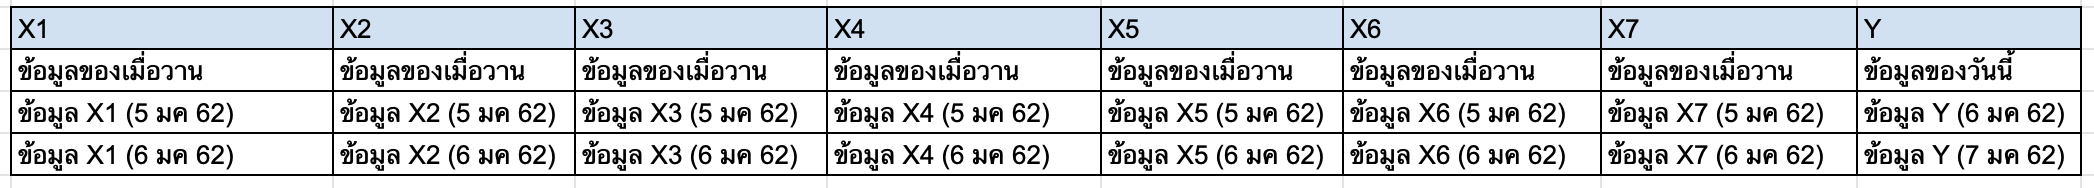



## นำเข้าไฟล์

In [2308]:
import pandas as pd

In [2309]:
from google.colab import drive # เชื่อมเข้ากับ Drive
drive.mount('/content/drive')  

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## ความกด(เปอร์เซ็นต์)

In [2310]:
#เข้าไป path ใน google drive
import os
os.chdir('/content/drive/MyDrive/bsc_DPBM_data_N/อุตุ/ความกด(เปอร์เซ็นต์)')

!pwd #เช็ค paht ที่กำลังทำงานอยู่
!ls 

/content/drive/MyDrive/bsc_DPBM_data_N/อุตุ/ความกด(เปอร์เซ็นต์)
thsarabunnew-webfont.ttf  จ.นครพนม.xlsx  จ.สกลนคร.xlsx
จ.ขอนแก่น.xlsx		  จ.เลย.xlsx	 จ.หนองคาย.xlsx


In [2311]:
Pressure_KK = pd.read_excel('จ.ขอนแก่น.xlsx',sheet_name='Sheet1',skiprows=4 )
Pressure_KK.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Pressure_KK.shape) # shown nomber of (row, column)

Pressure_L = pd.read_excel('จ.เลย.xlsx',sheet_name='Sheet1',skiprows=4 )
Pressure_L.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Pressure_L.shape)

Pressure_SK = pd.read_excel('จ.สกลนคร.xlsx',sheet_name='Sheet1',skiprows=4 )
Pressure_SK.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Pressure_SK.shape)

Pressure_NP = pd.read_excel('จ.นครพนม.xlsx',sheet_name='Sheet1',skiprows=4 )
Pressure_NP.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Pressure_NP.shape)

Pressure_NK = pd.read_excel('จ.หนองคาย.xlsx',sheet_name='Sheet1',skiprows=4 )
Pressure_NK.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Pressure_NK.shape)

(55, 35)
(55, 35)
(55, 35)
(55, 35)
(55, 35)


In [2312]:
Pressure_KK.head(3)

,ที่,สถานี,เดือน/ปี,1.0,2.0,3.0,4.0,5.0,6.0,7.0,...,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0,เฉลี่ย
0,1,352201-หนองคาย จ.หนองคาย,2011-10-01,1005.47,1006.65,1007.49,1008.28,1009.88,1011.36,1011.17,...,1010.76,1010.23,1011.34,1011.84,1011.89,1012.29,1011.67,1011.3,1011.52,1010.350645
1,2,352201-หนองคาย จ.หนองคาย,2011-11-01,1011.79,1010.83,1010.74,1010.71,1010.09,1009.24,1008.03,...,1014.07,1015.40,1013.95,1012.35,1011.31,1009.59,1010.13,1010.47,-,1011.717000
2,3,352201-หนองคาย จ.หนองคาย,2011-12-01,1011.43,1012.57,1012.28,1012.97,1013.09,1012.03,1012.05,...,1012.88,1015.78,1018.56,1018.65,1016.88,1016.05,1014.98,1015.53,1016.4,1016.470000


### จังหวัดขอนแก่น

In [2313]:
KK = str(Pressure_KK['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Pressure_KK['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    A.append(res[1])
Pressure_KK['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('ขอนแก่น')
Pressure_KK['จังหวัด'] = A          

In [2314]:
Pressure_KK = Pressure_KK[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Pressure_KK.head(3)

,จังหวัด,สถานี,เดือน,ปี,1.0,2.0,3.0,4.0,5.0,6.0,...,22.0,23.0,24.0,25.0,26.0,27.0,28.0,29.0,30.0,31.0
0,ขอนแก่น,352201-หนองคาย จ.หนองคาย,10,2011,1005.47,1006.65,1007.49,1008.28,1009.88,1011.36,...,1010.90,1010.76,1010.23,1011.34,1011.84,1011.89,1012.29,1011.67,1011.3,1011.52
1,ขอนแก่น,352201-หนองคาย จ.หนองคาย,11,2011,1011.79,1010.83,1010.74,1010.71,1010.09,1009.24,...,1013.63,1014.07,1015.40,1013.95,1012.35,1011.31,1009.59,1010.13,1010.47,-
2,ขอนแก่น,352201-หนองคาย จ.หนองคาย,12,2011,1011.43,1012.57,1012.28,1012.97,1013.09,1012.03,...,1012.88,1012.88,1015.78,1018.56,1018.65,1016.88,1016.05,1014.98,1015.53,1016.4


In [2315]:
Pres_KK = Pressure_KK.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Pres_KK.rename(columns={'level_4': 'วัน', 0: 'ความกด'}, inplace=True)
Pres_KK = Pres_KK[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความกด']]
Pres_KK.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,ความกด
0,ขอนแก่น,352201-หนองคาย จ.หนองคาย,1.0,10,2011,1005.47
1,ขอนแก่น,352201-หนองคาย จ.หนองคาย,2.0,10,2011,1006.65
2,ขอนแก่น,352201-หนองคาย จ.หนองคาย,3.0,10,2011,1007.49


### จังหวัดเลย

In [2316]:
KK = str(Pressure_L['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Pressure_L['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res 
    A.append(res[1])
Pressure_L['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('เลย')
Pressure_L['จังหวัด'] = A           

In [2317]:
Pressure_L = Pressure_L[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Pressure_L.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,เลย,352201-หนองคาย จ.หนองคาย,10,2011,1005.12,1006.51,1007.81,1008.15,1009.21,1011.28,...,1010.98,1010.79,1010.25,1011.52,1012.04,1012.00,1012.74,1011.69,1011.27,1011.71
1,เลย,352201-หนองคาย จ.หนองคาย,11,2011,1012.09,1011.32,1010.99,1011.47,1010.88,1009.62,...,1014.21,1014.79,1015.74,1014.36,1013.30,1011.92,1009.86,1010.1,1010.43,-
2,เลย,352201-หนองคาย จ.หนองคาย,12,2011,1010.43,1011.81,1012.45,1012.03,1013.29,1013.21,...,1014.34,1013.75,1013.11,1015.95,1018.79,1019.39,1017.88,1016.49,1014.97,1015.62


In [2318]:
Pres_L = Pressure_L.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Pres_L.rename(columns={'level_4': 'วัน', 0: 'ความกด'}, inplace=True)
Pres_L = Pres_L[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความกด']]
Pres_L.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,ความกด
0,เลย,352201-หนองคาย จ.หนองคาย,1,10,2011,1005.12
1,เลย,352201-หนองคาย จ.หนองคาย,2,10,2011,1006.51
2,เลย,352201-หนองคาย จ.หนองคาย,3,10,2011,1007.81


### จังหวัดสกลนคร

In [2319]:
KK = str(Pressure_SK['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Pressure_SK['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    A.append(res[1])
Pressure_SK['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('สกลนคร')
Pressure_SK['จังหวัด'] = A           

In [2320]:
Pressure_SK = Pressure_SK[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Pressure_SK.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,สกลนคร,352201-หนองคาย จ.หนองคาย,10,2011,1005.84,1007.16,1007.87,1008.56,1010.55,1011.83,...,1011.36,1011.24,1010.80,1012.02,1012.36,1012.42,1012.97,1012.52,1011.87,1012.21
1,สกลนคร,352201-หนองคาย จ.หนองคาย,11,2011,1012.41,1011.47,1011.22,1011.16,1010.51,1009.26,...,1014.41,1015.21,1016.11,1014.65,1012.96,1011.91,1010.10,1010.78,1011.06,-
2,สกลนคร,352201-หนองคาย จ.หนองคาย,12,2011,1012.16,1013.74,1013.44,1014.00,1013.28,1012.69,...,1014.07,1014.22,1017.34,1019.63,1019.96,1017.56,1017.02,1015.8,1016.96,1017.63


In [2321]:
Pres_SK = Pressure_SK.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Pres_SK.rename(columns={'level_4': 'วัน', 0: 'ความกด'}, inplace=True)
Pres_SK = Pres_SK[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความกด']]
Pres_SK.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,ความกด
0,สกลนคร,352201-หนองคาย จ.หนองคาย,1,10,2011,1005.84
1,สกลนคร,352201-หนองคาย จ.หนองคาย,2,10,2011,1007.16
2,สกลนคร,352201-หนองคาย จ.หนองคาย,3,10,2011,1007.87


### จังหวัดนครพนม

In [2322]:
KK = str(Pressure_NP['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Pressure_NP['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย - แล้วตั้งชื่อว่า res 
    A.append(res[1])
Pressure_NP['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('นครพนม')
Pressure_NP['จังหวัด'] = A       

In [2323]:
Pressure_NP = Pressure_NP[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Pressure_NP.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,นครพนม,352201-หนองคาย จ.หนองคาย,10,2011,1006.30,1007.38,1008.07,1008.44,1010.51,1011.65,...,1011.24,1011.09,1010.64,1012.01,1012.47,1012.46,1012.85,1012.43,1011.69,1012.28
1,นครพนม,352201-หนองคาย จ.หนองคาย,11,2011,1012.28,1011.23,1011.08,1010.96,1010.57,1009.20,...,1014.31,1015.49,1016.09,1014.62,1012.80,1011.83,1010.00,1010.6,1011.13,-
2,นครพนม,352201-หนองคาย จ.หนองคาย,12,2011,1012.15,1013.75,1013.24,1013.94,1013.35,1012.62,...,1014.05,1014.23,1017.58,1019.77,1019.71,1017.34,1017.01,1015.64,1016.89,1017.73


In [2324]:
Pres_NP = Pressure_NP.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Pres_NP.rename(columns={'level_4': 'วัน', 0: 'ความกด'}, inplace=True)
Pres_NP = Pres_NP[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความกด']]
Pres_NP.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,ความกด
0,นครพนม,352201-หนองคาย จ.หนองคาย,1,10,2011,1006.3
1,นครพนม,352201-หนองคาย จ.หนองคาย,2,10,2011,1007.38
2,นครพนม,352201-หนองคาย จ.หนองคาย,3,10,2011,1008.07


### จังหวัดหนองคาย

In [2325]:
KK = str(Pressure_NK['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Pressure_NK['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
Pressure_NK['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('หนองคาย')
Pressure_NK['จังหวัด'] = A       

In [2326]:
Pressure_NK = Pressure_NK[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Pressure_NK.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,หนองคาย,352201-หนองคาย จ.หนองคาย,10,2011,1005.34,1006.67,1007.39,1008.11,1009.69,1011.55,...,1011.17,1011.01,1010.71,1011.67,1012.36,1012.50,1012.81,1011.88,1011.77,1012.18
1,หนองคาย,352201-หนองคาย จ.หนองคาย,11,2011,1012.05,1011.35,1011.28,1011.27,1010.62,1009.58,...,1014.32,1015.27,1016.46,1014.65,1013.08,1011.62,1010.21,1010.71,1011.1,-
2,หนองคาย,352201-หนองคาย จ.หนองคาย,12,2011,1012.16,1013.26,1012.40,1013.57,1013.68,1012.72,...,1013.91,1013.94,1016.92,1019.05,1019.88,1017.86,1016.76,1015.63,1016.31,1017.19


In [2327]:
Pres_NK = Pressure_NK.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Pres_NK.rename(columns={'level_4': 'วัน', 0: 'ความกด'}, inplace=True)
Pres_NK = Pres_NK[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความกด']]
Pres_NK.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,ความกด
0,หนองคาย,352201-หนองคาย จ.หนองคาย,1,10,2011,1005.34
1,หนองคาย,352201-หนองคาย จ.หนองคาย,2,10,2011,1006.67
2,หนองคาย,352201-หนองคาย จ.หนองคาย,3,10,2011,1007.39


### รวมความกดอากาศทุกจังหวัด

In [2328]:
Pressure = pd.concat([Pres_KK,Pres_L,Pres_SK,Pres_NP,Pres_NK])
print(Pressure.shape)
Pressure.head(3)

(8525, 6)


,จังหวัด,สถานี,วัน,เดือน,ปี,ความกด
0,ขอนแก่น,352201-หนองคาย จ.หนองคาย,1.0,10,2011,1005.47
1,ขอนแก่น,352201-หนองคาย จ.หนองคาย,2.0,10,2011,1006.65
2,ขอนแก่น,352201-หนองคาย จ.หนองคาย,3.0,10,2011,1007.49


## ความชื้นสัมพัทธ์(เปอร์เซ็นต์)

In [2329]:
#เข้าไป path ใน google drive
import os
os.chdir('/content/drive/MyDrive/bsc_DPBM_data_N/อุตุ/ความชื้นสัมพัทธ์(เปอร์เซ็นต์)')

!pwd #เช็ค paht ที่กำลังทำงานอยู่
!ls 

/content/drive/MyDrive/bsc_DPBM_data_N/อุตุ/ความชื้นสัมพัทธ์(เปอร์เซ็นต์)
จ.ขอนแก่น.xlsx  จ.นครพนม.xlsx  จ.เลย.xlsx  จ.สกลนคร.xlsx  จ.หนองคาย.xlsx


In [2330]:
Humidity_KK = pd.read_excel('จ.ขอนแก่น.xlsx',sheet_name='Sheet1',skiprows=4 )
Humidity_KK.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Humidity_KK.shape) # shown nomber of (row, column)

Humidity_L = pd.read_excel('จ.เลย.xlsx',sheet_name='Sheet1',skiprows=4 )
Humidity_L.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Humidity_L.shape)

Humidity_SK = pd.read_excel('จ.สกลนคร.xlsx',sheet_name='Sheet1',skiprows=4 )
Humidity_SK.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Humidity_SK.shape)

Humidity_NP = pd.read_excel('จ.นครพนม.xlsx',sheet_name='Sheet1',skiprows=4 )
Humidity_NP.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Humidity_NP.shape)

Humidity_NK = pd.read_excel('จ.หนองคาย.xlsx',sheet_name='Sheet1',skiprows=4 )
Humidity_NK.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Humidity_NK.shape)

(55, 35)
(55, 35)
(55, 35)
(55, 35)
(55, 35)


In [2331]:
Humidity_KK.head(3)

,ที่,สถานี,เดือน/ปี,1,2,3,4,5,6,7,...,23,24,25,26,27,28,29,30,31,เฉลี่ย
0,1,381201-ขอนแก่น จ.ขอนแก่น,2011-10-01,83,92,86,80,86,86,83,...,73,72,73,69,69,75,71,71,68,79
1,2,381201-ขอนแก่น จ.ขอนแก่น,2011-11-01,71,65,68,65,65,68,69,...,65,66,65,67,68,67,67,65,-,68
2,3,381201-ขอนแก่น จ.ขอนแก่น,2011-12-01,66,61,61,62,61,60,69,...,63,62,60,60,62,65,66,63,64,63


### จังหวัดขอนแก่น

In [2332]:
KK = str(Humidity_KK['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Humidity_KK['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
Humidity_KK['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('ขอนแก่น')
Humidity_KK['จังหวัด'] = A           

In [2333]:
Humidity_KK = Humidity_KK[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Humidity_KK.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,10,2011,83,92,86,80,86,86,...,73,73,72,73,69,69,75,71,71,68
1,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,11,2011,71,65,68,65,65,68,...,69,65,66,65,67,68,67,67,65,-
2,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,12,2011,66,61,61,62,61,60,...,64,63,62,60,60,62,65,66,63,64


In [2334]:
Humi_KK = Humidity_KK.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Humi_KK.rename(columns={'level_4': 'วัน', 0: 'ความชื้น'}, inplace=True)
Humi_KK = Humi_KK[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความชื้น']]
Humi_KK.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,ความชื้น
0,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,1,10,2011,83
1,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,2,10,2011,92
2,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,3,10,2011,86


### จังหวัดเลย

In [2335]:
KK = str(Humidity_L['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Humidity_L['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res   
    A.append(res[1])
Humidity_L['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('เลย')
Humidity_L['จังหวัด'] = A           

In [2336]:
Humidity_L = Humidity_L[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Humidity_L.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,เลย,353301-เลย สกษ. จ.เลย,10,2011,90,95,92,89,86,94,...,85,85,86,83,84,85,85,82,83,85
1,เลย,353301-เลย สกษ. จ.เลย,11,2011,85,83,84,83,83,85,...,84,73,77,80,81,80,84,82,79,-
2,เลย,353301-เลย สกษ. จ.เลย,12,2011,80,77,77,76,78,83,...,82,80,74,75,74,80,80,78,81,78


In [2337]:
Humi_L = Humidity_L.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Humi_L.rename(columns={'level_4': 'วัน', 0: 'ความชื้น'}, inplace=True)
Humi_L = Humi_L[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความชื้น']]
Humi_L.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,ความชื้น
0,เลย,353301-เลย สกษ. จ.เลย,1,10,2011,90
1,เลย,353301-เลย สกษ. จ.เลย,2,10,2011,95
2,เลย,353301-เลย สกษ. จ.เลย,3,10,2011,92


### จังหวัดสกลนคร

In [2338]:
KK = str(Humidity_SK['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Humidity_SK['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
Humidity_SK['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('สกลนคร')
Humidity_SK['จังหวัด'] = A           

In [2339]:
Humidity_SK = Humidity_SK[[  'จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Humidity_SK.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,สกลนคร,356201-สกลนคร จ.สกลนคร,10,2011,87,88,77,75,87,86,...,70,74,73,73,72,72,70,74,73,72
1,สกลนคร,356201-สกลนคร จ.สกลนคร,11,2011,71,71,71,72,73,70,...,72,68,66,71,71,70,70,69,69,-
2,สกลนคร,356201-สกลนคร จ.สกลนคร,12,2011,66,61,64,67,70,73,...,68,69,65,64,62,69,69,69,69,68


In [2340]:
Humi_SK = Humidity_SK.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Humi_SK.rename(columns={'level_4': 'วัน', 0: 'ความชื้น'}, inplace=True)
Humi_SK = Humi_SK[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความชื้น']]
Humi_SK.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,ความชื้น
0,สกลนคร,356201-สกลนคร จ.สกลนคร,1,10,2011,87
1,สกลนคร,356201-สกลนคร จ.สกลนคร,2,10,2011,88
2,สกลนคร,356201-สกลนคร จ.สกลนคร,3,10,2011,77


### จังหวัดนครพนม

In [2341]:
KK = str(Humidity_NP['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Humidity_NP['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res   
    A.append(res[1])
Humidity_NP['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('นครพนม')
Humidity_NP['จังหวัด'] = A       

In [2342]:
Humidity_NP = Humidity_NP[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Humidity_NP.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,นครพนม,357201-นครพนม จ.นครพนม,10,2011,95,84,74,72,87,88,...,68,66,67,70,69,71,66,72,70,69
1,นครพนม,357201-นครพนม จ.นครพนม,11,2011,69,67,70,68,71,68,...,72,66,66,70,78,74,69,66,65,-
2,นครพนม,357201-นครพนม จ.นครพนม,12,2011,64,56,62,67,69,77,...,67,66,54,60,61,70,71,63,66,70


In [2343]:
Humi_NP = Humidity_NP.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Humi_NP.rename(columns={'level_4': 'วัน', 0: 'ความชื้น'}, inplace=True)
Humi_NP = Humi_NP[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความชื้น']]
Humi_NP.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,ความชื้น
0,นครพนม,357201-นครพนม จ.นครพนม,1,10,2011,95
1,นครพนม,357201-นครพนม จ.นครพนม,2,10,2011,84
2,นครพนม,357201-นครพนม จ.นครพนม,3,10,2011,74


### จังหวัดหนองคาย

In [2344]:
KK = str(Humidity_NK['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Humidity_NK['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res   
    A.append(res[1])
Humidity_NK['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('หนองคาย')
Humidity_NK['จังหวัด'] = A       

In [2345]:
Humidity_NK = Humidity_NK[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Humidity_NK.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,หนองคาย,352201-หนองคาย จ.หนองคาย,10,2011,89,91,78,75,90,88,...,71,76,73,68,71,70,71,70,66,68
1,หนองคาย,352201-หนองคาย จ.หนองคาย,11,2011,68,66,66,67,68,69,...,63,60,64,65,67,68,69,71,69,-
2,หนองคาย,352201-หนองคาย จ.หนองคาย,12,2011,67,62,66,66,65,68,...,66,65,56,61,58,67,71,70,67,68


In [2346]:
Humi_NK = Humidity_NK.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Humi_NK.rename(columns={'level_4': 'วัน', 0: 'ความชื้น'}, inplace=True)
Humi_NK = Humi_NK[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความชื้น']]
Humi_NK.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,ความชื้น
0,หนองคาย,352201-หนองคาย จ.หนองคาย,1,10,2011,89
1,หนองคาย,352201-หนองคาย จ.หนองคาย,2,10,2011,91
2,หนองคาย,352201-หนองคาย จ.หนองคาย,3,10,2011,78


### รวมความชื้นสัมพัทธ์ทุกจังหวัด

In [2347]:
Humidity = pd.concat([Humi_KK,Humi_L,Humi_SK,Humi_NP,Humi_NK])
print(Humidity.shape)
Humidity.head(3)

(8525, 6)


,จังหวัด,สถานี,วัน,เดือน,ปี,ความชื้น
0,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,1,10,2011,83
1,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,2,10,2011,92
2,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,3,10,2011,86


## ความเร็วลม(นอต)

In [2348]:
#เข้าไป path ใน google drive
import os
os.chdir('/content/drive/MyDrive/bsc_DPBM_data_N/อุตุ/ความเร็วลม(นอต)')

!pwd #เช็ค paht ที่กำลังทำงานอยู่
!ls 

/content/drive/MyDrive/bsc_DPBM_data_N/อุตุ/ความเร็วลม(นอต)
จ.ขอนแก่น.xlsx  จ.นครพนม.xlsx  จ.เลย.xlsx  จ.สกลนคร.xlsx  จ.หนองคาย.xlsx


In [2349]:
Wind_KK = pd.read_excel('จ.ขอนแก่น.xlsx',sheet_name='Sheet1',skiprows=4 )
Wind_KK.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Wind_KK.shape) # shown nomber of (row, column)

Wind_L = pd.read_excel('จ.เลย.xlsx',sheet_name='Sheet1',skiprows=4 )
Wind_L.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Wind_L.shape)

Wind_SK = pd.read_excel('จ.สกลนคร.xlsx',sheet_name='Sheet1',skiprows=4 )
Wind_SK.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Wind_SK.shape)

Wind_NP = pd.read_excel('จ.นครพนม.xlsx',sheet_name='Sheet1',skiprows=4 )
Wind_NP.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Wind_NP.shape)

Wind_NK = pd.read_excel('จ.หนองคาย.xlsx',sheet_name='Sheet1',skiprows=4 )
Wind_NK.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Wind_NK.shape)

(55, 35)
(55, 35)
(55, 35)
(55, 35)
(55, 35)


In [2350]:
Wind_KK.head(3)

,ที่,สถานี,เดือน/ปี,1,2,3,4,5,6,7,...,23,24,25,26,27,28,29,30,31,เฉลี่ย
0,1,353301-เลย สกษ. จ.เลย,2011-10-01,3,2,3,2,2,3,4,...,2,3,5,5,5,4,6,4,5,3.354839
1,2,353301-เลย สกษ. จ.เลย,2011-11-01,4,5,3,3,5,2,3,...,7,6,5,5,3,1,3,3,-,3.466667
2,3,353301-เลย สกษ. จ.เลย,2011-12-01,3,4,4,4,4,4,4,...,5,6,7,6,5,4,4,6,5,4.806452


### จังหวัดขอนแก่น

In [2351]:
KK = str(Wind_KK['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Wind_KK['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
Wind_KK['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('ขอนแก่น')
Wind_KK['จังหวัด'] = A          

In [2352]:
Wind_KK = Wind_KK[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Wind_KK.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,ขอนแก่น,353301-เลย สกษ. จ.เลย,10,2011,3,2,3,2,2,3,...,3,2,3,5,5,5,4,6,4,5
1,ขอนแก่น,353301-เลย สกษ. จ.เลย,11,2011,4,5,3,3,5,2,...,5,7,6,5,5,3,1,3,3,-
2,ขอนแก่น,353301-เลย สกษ. จ.เลย,12,2011,3,4,4,4,4,4,...,4,5,6,7,6,5,4,4,6,5


In [2353]:
Wi_KK = Wind_KK.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Wi_KK.rename(columns={'level_4': 'วัน', 0: 'ความเร็วลม'}, inplace=True)
Wi_KK = Wi_KK[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความเร็วลม']]
Wi_KK.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,ความเร็วลม
0,ขอนแก่น,353301-เลย สกษ. จ.เลย,1,10,2011,3
1,ขอนแก่น,353301-เลย สกษ. จ.เลย,2,10,2011,2
2,ขอนแก่น,353301-เลย สกษ. จ.เลย,3,10,2011,3


### จังหวัดเลย

In [2354]:
KK = str(Wind_L['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Wind_L['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
Wind_L['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('เลย')
Wind_L['จังหวัด'] = A           

In [2355]:
Wind_L = Wind_L[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Wind_L.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,เลย,353301-เลย สกษ. จ.เลย,10,2011,2,2,3,2,3,2,...,1,1,1,2,2,1,2,2,2,1
1,เลย,353301-เลย สกษ. จ.เลย,11,2011,1,2,1,1,2,2,...,2,3,2,1,1,2,1,2,1,-
2,เลย,353301-เลย สกษ. จ.เลย,12,2011,2,2,3,2,1,2,...,2,1,2,3,2,1,2,1,2,2


In [2356]:
Wi_L = Wind_L.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Wi_L.rename(columns={'level_4': 'วัน', 0: 'ความเร็วลม'}, inplace=True)
Wi_L = Wi_L[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความเร็วลม']]
Wi_L.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,ความเร็วลม
0,เลย,353301-เลย สกษ. จ.เลย,1,10,2011,2
1,เลย,353301-เลย สกษ. จ.เลย,2,10,2011,2
2,เลย,353301-เลย สกษ. จ.เลย,3,10,2011,3


### จังหวัดสกลนคร

In [2357]:
KK = str(Wind_SK['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Wind_SK['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
Wind_SK['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('สกลนคร')
Wind_SK['จังหวัด'] = A           

In [2358]:
Wind_SK = Wind_SK[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Wind_SK.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,สกลนคร,353301-เลย สกษ. จ.เลย,10,2011,1,1,2,2,1,0,...,1,1,2,2,1,2,2,1,1,1
1,สกลนคร,353301-เลย สกษ. จ.เลย,11,2011,1,1,1,1,1,1,...,2,3,3,2,2,1,1,1,1,-
2,สกลนคร,353301-เลย สกษ. จ.เลย,12,2011,1,2,2,1,1,1,...,1,1,3,3,1,2,1,1,2,2


In [2359]:
Wi_SK = Wind_SK.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Wi_SK.rename(columns={'level_4': 'วัน', 0: 'ความเร็วลม'}, inplace=True)
Wi_SK = Wi_SK[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความเร็วลม']]
Wi_SK.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,ความเร็วลม
0,สกลนคร,353301-เลย สกษ. จ.เลย,1,10,2011,1
1,สกลนคร,353301-เลย สกษ. จ.เลย,2,10,2011,1
2,สกลนคร,353301-เลย สกษ. จ.เลย,3,10,2011,2


### จังหวัดนครพนม

In [2360]:
KK = str(Wind_NP['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Wind_NP['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
Wind_NP['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('นครพนม')
Wind_NP['จังหวัด'] = A       

In [2361]:
Wind_NP = Wind_NP[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Wind_NP.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,นครพนม,353301-เลย สกษ. จ.เลย,10,2011,1,1,2,2,1,0,...,1,1,2,2,1,2,2,1,1,1
1,นครพนม,353301-เลย สกษ. จ.เลย,11,2011,1,1,1,1,1,1,...,2,3,3,2,2,1,1,1,1,-
2,นครพนม,353301-เลย สกษ. จ.เลย,12,2011,1,2,2,1,1,1,...,1,1,3,3,1,2,1,1,2,2


In [2362]:
Wi_NP = Wind_NP.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Wi_NP.rename(columns={'level_4': 'วัน', 0: 'ความเร็วลม'}, inplace=True)
Wi_NP = Wi_NP[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความเร็วลม']]
Wi_NP.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,ความเร็วลม
0,นครพนม,353301-เลย สกษ. จ.เลย,1,10,2011,1
1,นครพนม,353301-เลย สกษ. จ.เลย,2,10,2011,1
2,นครพนม,353301-เลย สกษ. จ.เลย,3,10,2011,2


### จังหวัดหนองคาย

In [2363]:
KK = str(Wind_NK['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Wind_NK['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
Wind_NK['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('หนองคาย')
Wind_NK['จังหวัด'] = A       

In [2364]:
Wind_NK = Wind_NK[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Wind_NK.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,หนองคาย,353301-เลย สกษ. จ.เลย,10,2011,1,4,4,2,1,3,...,2,2,2,3,3,3,3,3,3,4
1,หนองคาย,353301-เลย สกษ. จ.เลย,11,2011,3,3,3,2,2,1,...,4,7,4,2,3,2,2,2,2,-
2,หนองคาย,353301-เลย สกษ. จ.เลย,12,2011,2,5,3,2,2,2,...,3,3,6,5,4,2,2,2,3,2


In [2365]:
Wi_NK = Wind_NK.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Wi_NK.rename(columns={'level_4': 'วัน', 0: 'ความเร็วลม'}, inplace=True)
Wi_NK = Wi_NK[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ความเร็วลม']]
Wi_NK.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,ความเร็วลม
0,หนองคาย,353301-เลย สกษ. จ.เลย,1,10,2011,1
1,หนองคาย,353301-เลย สกษ. จ.เลย,2,10,2011,4
2,หนองคาย,353301-เลย สกษ. จ.เลย,3,10,2011,4


### รวมความเร็วลมทุกจังหวัด

In [2366]:
Wind = pd.concat([Wi_KK,Wi_L,Wi_SK,Wi_NP,Wi_NK])
print(Wind.shape)
Wind.head(3)

(8525, 6)


,จังหวัด,สถานี,วัน,เดือน,ปี,ความเร็วลม
0,ขอนแก่น,353301-เลย สกษ. จ.เลย,1,10,2011,3
1,ขอนแก่น,353301-เลย สกษ. จ.เลย,2,10,2011,2
2,ขอนแก่น,353301-เลย สกษ. จ.เลย,3,10,2011,3


## จำนวนเมฆ(10ส่วน)

In [2367]:
#เข้าไป path ใน google drive
import os
os.chdir('/content/drive/MyDrive/bsc_DPBM_data_N/อุตุ/จำนวนเมฆ(10ส่วน)')

!pwd #เช็ค paht ที่กำลังทำงานอยู่
!ls 

/content/drive/MyDrive/bsc_DPBM_data_N/อุตุ/จำนวนเมฆ(10ส่วน)
จ.ขอนแก่น.xlsx  จ.นครพนม.xlsx  จ.เลย.xlsx  จ.สกลนคร.xlsx  จ.หนองคาย.xlsx


In [2368]:
Cloud_KK = pd.read_excel('จ.ขอนแก่น.xlsx',sheet_name='Sheet1',skiprows=4 )
Cloud_KK.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Cloud_KK.shape) # shown nomber of (row, column)

Cloud_L = pd.read_excel('จ.เลย.xlsx',sheet_name='Sheet1',skiprows=4 )
Cloud_L.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Cloud_L.shape)

Cloud_SK = pd.read_excel('จ.สกลนคร.xlsx',sheet_name='Sheet1',skiprows=4 )
Cloud_SK.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Cloud_SK.shape)

Cloud_NP = pd.read_excel('จ.นครพนม.xlsx',sheet_name='Sheet1',skiprows=4 )
Cloud_NP.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Cloud_NP.shape)

Cloud_NK = pd.read_excel('จ.หนองคาย.xlsx',sheet_name='Sheet1',skiprows=4 )
Cloud_NK.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Cloud_NK.shape)

(55, 35)
(55, 45)
(55, 35)
(55, 35)
(55, 35)


In [2369]:
pd.read_excel('จ.เลย.xlsx',sheet_name='Sheet1',skiprows=4 ).head(3) #เรียกไฟล์ออกมาดูว่าทำไมถึงมี 45 คอลัมน์

,Unnamed: 0,Unnamed: 1,Unnamed: 2,1,2,3,4,5,6,7,...,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44
0,1,353301-เลย สกษ. จ.เลย,2011-10-01,8,10,10,9,8,10,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,353301-เลย สกษ. จ.เลย,2011-11-01,2,1,2,1,1,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,353301-เลย สกษ. จ.เลย,2011-12-01,1,3,1,3,3,2,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2370]:
Cloud_L = Cloud_L.iloc[:,:35] #ตัดให้มี 35คอลัมน์
print(Cloud_L.shape)

(55, 35)


In [2371]:
Cloud_KK.head(3)

,ที่,สถานี,เดือน/ปี,1,2,3,4,5,6,7,...,23,24,25,26,27,28,29,30,31,เฉลี่ย
0,1,353301-เลย สกษ. จ.เลย,2011-10-01,9,10,10,8,10,10,10,...,2,3,5,3,3,5,4,2,2,6.322581
1,2,353301-เลย สกษ. จ.เลย,2011-11-01,2,2,2,2,3,6,9,...,6,6,3,2,2,1,3,2,-,3.533333
2,3,353301-เลย สกษ. จ.เลย,2011-12-01,2,3,4,4,5,8,7,...,5,5,3,3,1,2,1,1,1,3.516129


### จังหวัดขอนแก่น

In [2372]:
KK = str(Cloud_KK['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Cloud_KK['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
Cloud_KK['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('ขอนแก่น')
Cloud_KK['จังหวัด'] = A          

In [2373]:
Cloud_KK = Cloud_KK[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Cloud_KK.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,ขอนแก่น,353301-เลย สกษ. จ.เลย,10,2011,9,10,10,8,10,10,...,3,2,3,5,3,3,5,4,2,2
1,ขอนแก่น,353301-เลย สกษ. จ.เลย,11,2011,2,2,2,2,3,6,...,5,6,6,3,2,2,1,3,2,-
2,ขอนแก่น,353301-เลย สกษ. จ.เลย,12,2011,2,3,4,4,5,8,...,4,5,5,3,3,1,2,1,1,1


In [2374]:
Cl_KK = Cloud_KK.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Cl_KK.rename(columns={'level_4': 'วัน', 0: 'จำนวนเมฆ'}, inplace=True)
Cl_KK = Cl_KK[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'จำนวนเมฆ']]
Cl_KK.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,จำนวนเมฆ
0,ขอนแก่น,353301-เลย สกษ. จ.เลย,1,10,2011,9
1,ขอนแก่น,353301-เลย สกษ. จ.เลย,2,10,2011,10
2,ขอนแก่น,353301-เลย สกษ. จ.เลย,3,10,2011,10


### จังหวัดเลย

In [2375]:
KK = str(Cloud_L['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Cloud_L['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
Cloud_L['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('เลย')
Cloud_L['จังหวัด'] = A         

In [2376]:
Cloud_L = Cloud_L[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Cloud_L.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,เลย,353301-เลย สกษ. จ.เลย,10,2011,8,10,10,9,8,10,...,2,1,1,2,4,2,3,3,1,2
1,เลย,353301-เลย สกษ. จ.เลย,11,2011,2,1,2,1,1,1,...,6,6,4,0,1,2,2,5,3,-
2,เลย,353301-เลย สกษ. จ.เลย,12,2011,1,3,1,3,3,2,...,3,3,1,1,0,0,1,1,4,1


In [2377]:
Cl_L = Cloud_L.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Cl_L.rename(columns={'level_4': 'วัน', 0: 'จำนวนเมฆ'}, inplace=True)
Cl_L = Cl_L[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'จำนวนเมฆ']]
Cl_L.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,จำนวนเมฆ
0,เลย,353301-เลย สกษ. จ.เลย,1,10,2011,8
1,เลย,353301-เลย สกษ. จ.เลย,2,10,2011,10
2,เลย,353301-เลย สกษ. จ.เลย,3,10,2011,10


### จังหวัดสกลนคร

In [2378]:
KK = str(Cloud_SK['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Cloud_SK['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res   
    A.append(res[1])
Cloud_SK['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('สกลนคร')
Cloud_SK['จังหวัด'] = A           

In [2379]:
Cloud_SK = Cloud_SK[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Cloud_SK.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,สกลนคร,353301-เลย สกษ. จ.เลย,10,2011,9,9,7,7,9,10,...,1,2,1,2,1,1,3,3,1,4
1,สกลนคร,353301-เลย สกษ. จ.เลย,11,2011,2,0,0,1,3,7,...,6,4,3,1,1,1,1,1,0,-
2,สกลนคร,353301-เลย สกษ. จ.เลย,12,2011,1,1,2,2,2,6,...,3,3,2,-,0,0,0,0,1,-


In [2380]:
Cl_SK = Cloud_SK.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Cl_SK.rename(columns={'level_4': 'วัน', 0: 'จำนวนเมฆ'}, inplace=True)
Cl_SK = Cl_SK[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'จำนวนเมฆ']]
Cl_SK.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,จำนวนเมฆ
0,สกลนคร,353301-เลย สกษ. จ.เลย,1,10,2011,9
1,สกลนคร,353301-เลย สกษ. จ.เลย,2,10,2011,9
2,สกลนคร,353301-เลย สกษ. จ.เลย,3,10,2011,7


### จังหวัดนครพนม

In [2381]:
KK = str(Cloud_NP['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Cloud_NP['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
Cloud_NP['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('นครพนม')
Cloud_NP['จังหวัด'] = A       

In [2382]:
Cloud_NP = Cloud_NP[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Cloud_NP.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,นครพนม,353301-เลย สกษ. จ.เลย,10,2011,10,7,8,8,10,10,...,2,2,2,2,2,3,3,4,2,4
1,นครพนม,353301-เลย สกษ. จ.เลย,11,2011,2,2,2,3,5,7,...,4,4,4,4,2,2,2,1,1,-
2,นครพนม,353301-เลย สกษ. จ.เลย,12,2011,2,2,2,4,4,7,...,4,4,2,2,2,2,1,2,1,1


In [2383]:
Cl_NP = Cloud_NP.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Cl_NP.rename(columns={'level_4': 'วัน', 0: 'จำนวนเมฆ'}, inplace=True)
Cl_NP = Cl_NP[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'จำนวนเมฆ']]
Cl_NP.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,จำนวนเมฆ
0,นครพนม,353301-เลย สกษ. จ.เลย,1,10,2011,10
1,นครพนม,353301-เลย สกษ. จ.เลย,2,10,2011,7
2,นครพนม,353301-เลย สกษ. จ.เลย,3,10,2011,8


### จังหวัดหนองคาย

In [2384]:
KK = str(Cloud_NK['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Cloud_NK['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res   
    A.append(res[1])
Cloud_NK['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('หนองคาย')
Cloud_NK['จังหวัด'] = A       

In [2385]:
Cloud_NK = Cloud_NK[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Cloud_NK.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,หนองคาย,353301-เลย สกษ. จ.เลย,10,2011,10,10,8,9,9,10,...,1,3,1,1,2,1,1,1,4,3
1,หนองคาย,353301-เลย สกษ. จ.เลย,11,2011,1,0,0,1,1,2,...,6,6,6,-,0,1,2,4,2,-
2,หนองคาย,353301-เลย สกษ. จ.เลย,12,2011,4,4,-,2,7,5,...,1,2,8,1,-,3,1,1,3,-


In [2386]:
Cl_NK = Cloud_NK.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Cl_NK.rename(columns={'level_4': 'วัน', 0: 'จำนวนเมฆ'}, inplace=True)
Cl_NK = Cl_NK[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'จำนวนเมฆ']]
Cl_NK.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,จำนวนเมฆ
0,หนองคาย,353301-เลย สกษ. จ.เลย,1,10,2011,10
1,หนองคาย,353301-เลย สกษ. จ.เลย,2,10,2011,10
2,หนองคาย,353301-เลย สกษ. จ.เลย,3,10,2011,8


### รวมจำนวนเมฆทุกจังหวัด

In [2387]:
Cloud = pd.concat([Cl_KK,Cl_L,Cl_SK,Cl_NP,Cl_NK])
print(Cloud.shape)
Cloud.head(3)

(8522, 6)


,จังหวัด,สถานี,วัน,เดือน,ปี,จำนวนเมฆ
0,ขอนแก่น,353301-เลย สกษ. จ.เลย,1,10,2011,9
1,ขอนแก่น,353301-เลย สกษ. จ.เลย,2,10,2011,10
2,ขอนแก่น,353301-เลย สกษ. จ.เลย,3,10,2011,10


## ปริมาณฝน(มิลลิเมตร)

In [2388]:
#เข้าไป path ใน google drive
import os
os.chdir('/content/drive/MyDrive/bsc_DPBM_data_N/อุตุ/ปริมาณฝน(มิลลิเมตร)')

!pwd #เช็ค paht ที่กำลังทำงานอยู่
!ls 

/content/drive/MyDrive/bsc_DPBM_data_N/อุตุ/ปริมาณฝน(มิลลิเมตร)
จ.ขอนแก่น.xlsx  จ.นครพนม.xlsx  จ.เลย.xlsx  จ.สกล.xlsx  จ.หนองคาย.xlsx


In [2389]:
Rain_KK = pd.read_excel('จ.ขอนแก่น.xlsx',sheet_name='Sheet1',skiprows=4 )
Rain_KK.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Rain_KK.shape) # shown nomber of (row, column)

Rain_L = pd.read_excel('จ.เลย.xlsx',sheet_name='Sheet1',skiprows=4 )
Rain_L.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Rain_L.shape)

Rain_SK = pd.read_excel('จ.สกล.xlsx',sheet_name='Sheet1',skiprows=4 )
Rain_SK.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Rain_SK.shape)

Rain_NP = pd.read_excel('จ.นครพนม.xlsx',sheet_name='Sheet1',skiprows=4 )
Rain_NP.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Rain_NP.shape)

Rain_NK = pd.read_excel('จ.หนองคาย.xlsx',sheet_name='Sheet1',skiprows=4 )
Rain_NK.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Rain_NK.shape)

(55, 35)
(55, 35)
(55, 35)
(55, 35)
(55, 35)


In [2390]:
Rain_KK.head(3)

,ที่,สถานี,เดือน/ปี,1,2,3,4,5,6,7,...,23,24,25,26,27,28,29,30,31,เฉลี่ย
0,1,381201-ขอนแก่น จ.ขอนแก่น,2011-10-01,1.4,17.7,3,0,2.2,0.5,1.3,...,0,0,T,0,0.5,1.1,0,0,0,176.8
1,2,381201-ขอนแก่น จ.ขอนแก่น,2011-11-01,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,-,11.8
2,3,381201-ขอนแก่น จ.ขอนแก่น,2011-12-01,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-


### จังหวัดขอนแก่น

In [2391]:
KK = str(Rain_KK['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Rain_KK['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
Rain_KK['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('ขอนแก่น')
Rain_KK['จังหวัด'] = A          

In [2392]:
Rain_KK = Rain_KK[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Rain_KK.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,10,2011,1.4,17.7,3,0,2.2,0.5,...,0,0,0,T,0,0.5,1.1,0,0,0
1,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,11,2011,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-
2,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,12,2011,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2393]:
Ra_KK = Rain_KK.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Ra_KK.rename(columns={'level_4': 'วัน', 0: 'ปริมาณฝน'}, inplace=True)
Ra_KK = Ra_KK[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ปริมาณฝน']]
Ra_KK.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,ปริมาณฝน
0,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,1,10,2011,1.4
1,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,2,10,2011,17.7
2,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,3,10,2011,3


### จังหวัดเลย

In [2394]:
KK = str(Rain_L['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Rain_L['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
Rain_L['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('เลย')
Rain_L['จังหวัด'] = A          

In [2395]:
Rain_L = Rain_L[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Rain_L.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,เลย,353201-เลย จ.เลย,10,2011,21.6,111.4,0.4,0,0,3.4,...,0,0,0,0,0,0,0.2,0,0,0
1,เลย,353201-เลย จ.เลย,11,2011,0,0,0,0,0,0,...,0,0,0,0,0,0,0.6,0,0,-
2,เลย,353201-เลย จ.เลย,12,2011,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2396]:
Ra_L = Rain_L.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Ra_L.rename(columns={'level_4': 'วัน', 0: 'ปริมาณฝน'}, inplace=True)
Ra_L = Ra_L[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ปริมาณฝน']]
Ra_L.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,ปริมาณฝน
0,เลย,353201-เลย จ.เลย,1,10,2011,21.6
1,เลย,353201-เลย จ.เลย,2,10,2011,111.4
2,เลย,353201-เลย จ.เลย,3,10,2011,0.4


### จังหวัดสกลนคร

In [2397]:
KK = str(Rain_SK['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Rain_SK['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
Rain_SK['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('สกลนคร')
Rain_SK['จังหวัด'] = A          

In [2398]:
Rain_SK = Rain_SK[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Rain_SK.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,สกลนคร,356201-สกลนคร จ.สกลนคร,10,2011,84.8,28.1,0,T,5.5,0.3,...,0,0,0,0,0,0,0,1,0,0
1,สกลนคร,356201-สกลนคร จ.สกลนคร,11,2011,0,0,0,0,T,T,...,0,0,0,0,0,0,0,0,0,-
2,สกลนคร,356201-สกลนคร จ.สกลนคร,12,2011,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2399]:
Ra_SK = Rain_SK.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Ra_SK.rename(columns={'level_4': 'วัน', 0: 'ปริมาณฝน'}, inplace=True)
Ra_SK = Ra_SK[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ปริมาณฝน']]
Ra_SK.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,ปริมาณฝน
0,สกลนคร,356201-สกลนคร จ.สกลนคร,1,10,2011,84.8
1,สกลนคร,356201-สกลนคร จ.สกลนคร,2,10,2011,28.1
2,สกลนคร,356201-สกลนคร จ.สกลนคร,3,10,2011,0


### จังหวัดนครพนม

In [2400]:
KK = str(Rain_NP['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Rain_NP['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
Rain_NP['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('นครพนม')
Rain_NP['จังหวัด'] = A       

In [2401]:
Rain_NP = Rain_NP[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Rain_NP.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,นครพนม,357201-นครพนม จ.นครพนม,10,2011,17,0.3,0,0.3,1.9,T,...,0,0,0,0,0,0,0,0,0,0
1,นครพนม,357201-นครพนม จ.นครพนม,11,2011,0,0,0,0,T,T,...,T,0,0,0,0,0.5,0,0,0,-
2,นครพนม,357201-นครพนม จ.นครพนม,12,2011,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2402]:
Ra_NP = Rain_NP.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Ra_NP.rename(columns={'level_4': 'วัน', 0: 'ปริมาณฝน'}, inplace=True)
Ra_NP = Ra_NP[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ปริมาณฝน']]
Ra_NP.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,ปริมาณฝน
0,นครพนม,357201-นครพนม จ.นครพนม,1,10,2011,17
1,นครพนม,357201-นครพนม จ.นครพนม,2,10,2011,0.3
2,นครพนม,357201-นครพนม จ.นครพนม,3,10,2011,0


### จังหวัดหนองคาย

In [2403]:
KK = str(Rain_NK['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Rain_NK['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
Rain_NK['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('หนองคาย')
Rain_NK['จังหวัด'] = A       

In [2404]:
Rain_NK = Rain_NK[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Rain_NK.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,หนองคาย,352201-หนองคาย จ.หนองคาย,10,2011,48.6,59,0,1,19.1,6.2,...,0,0,0,0,0,0,0,0,0,0
1,หนองคาย,352201-หนองคาย จ.หนองคาย,11,2011,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,-
2,หนองคาย,352201-หนองคาย จ.หนองคาย,12,2011,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2405]:
Ra_NK = Rain_NK.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Ra_NK.rename(columns={'level_4': 'วัน', 0: 'ปริมาณฝน'}, inplace=True)
Ra_NK = Ra_NK[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'ปริมาณฝน']]
Ra_NK.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,ปริมาณฝน
0,หนองคาย,352201-หนองคาย จ.หนองคาย,1,10,2011,48.6
1,หนองคาย,352201-หนองคาย จ.หนองคาย,2,10,2011,59
2,หนองคาย,352201-หนองคาย จ.หนองคาย,3,10,2011,0


### รวมปริมาณฝนทุกจังหวัด

In [2406]:
Rain = pd.concat([Ra_KK,Ra_L,Ra_SK,Ra_NP,Ra_NK])
print(Rain.shape)
Rain.head(3)

(8523, 6)


,จังหวัด,สถานี,วัน,เดือน,ปี,ปริมาณฝน
0,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,1,10,2011,1.4
1,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,2,10,2011,17.7
2,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,3,10,2011,3


## อุณหภูมิจุดน้ำค้าง(เซลเซียส)

In [2407]:
#เข้าไป path ใน google drive
import os
os.chdir('/content/drive/MyDrive/bsc_DPBM_data_N/อุตุ/อุณหภูมิจุดน้ำค้าง(เซลเซียส)')

!pwd #เช็ค paht ที่กำลังทำงานอยู่
!ls 

/content/drive/MyDrive/bsc_DPBM_data_N/อุตุ/อุณหภูมิจุดน้ำค้าง(เซลเซียส)
จ.ขอนแก่น.xlsx  จ.นครพนม.xlsx  จ.เลย.xlsx  จ.สกล.xlsx  จ.หนองคาย.xlsx


In [2408]:
Dew_point_KK = pd.read_excel('จ.ขอนแก่น.xlsx',sheet_name='Sheet1',skiprows=4 )
Dew_point_KK.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Dew_point_KK.shape) # shown nomber of (row, column)

Dew_point_L = pd.read_excel('จ.เลย.xlsx',sheet_name='Sheet1',skiprows=4 )
Dew_point_L.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Dew_point_L.shape)

Dew_point_SK = pd.read_excel('จ.สกล.xlsx',sheet_name='Sheet1',skiprows=4 )
Dew_point_SK.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Dew_point_SK.shape)

Dew_point_NP = pd.read_excel('จ.นครพนม.xlsx',sheet_name='Sheet1',skiprows=4 )
Dew_point_NP.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Dew_point_NP.shape)

Dew_point_NK = pd.read_excel('จ.หนองคาย.xlsx',sheet_name='Sheet1',skiprows=4 )
Dew_point_NK.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Dew_point_NK.shape)

(55, 35)
(50, 35)
(55, 35)
(55, 35)
(55, 35)


In [2409]:
Dew_point_KK.head(3)

,ที่,สถานี,เดือน/ปี,1,2,3,4,5,6,7,...,23,24,25,26,27,28,29,30,31,เฉลี่ย
0,1,381201-ขอนแก่น จ.ขอนแก่น,2011-10-01,24.2,24.0,22.9,21.9,21.7,21.3,21.9,...,21.0,21.8,21.8,20.7,20.8,21.9,20.3,19.7,19.7,21.903226
1,2,381201-ขอนแก่น จ.ขอนแก่น,2011-11-01,20.2,18.5,19.4,19.0,19.2,20.6,21.3,...,18.9,16.7,16.7,18.3,19.2,18.9,19,18.3,-,18.910000
2,3,381201-ขอนแก่น จ.ขอนแก่น,2011-12-01,17.7,15.3,12.7,14.0,14.6,16.6,19.1,...,15.8,12.9,9.8,9.7,12.4,16.1,16.3,16.1,16.3,14.525806


### จังหวัดขอนแก่น

In [2410]:
KK = str(Dew_point_KK['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Dew_point_KK['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res   
    A.append(res[1])
Dew_point_KK['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('ขอนแก่น')
Dew_point_KK['จังหวัด'] = A          

In [2411]:
Dew_point_KK = Dew_point_KK[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Dew_point_KK.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,10,2011,24.2,24.0,22.9,21.9,21.7,21.3,...,20.8,21.0,21.8,21.8,20.7,20.8,21.9,20.3,19.7,19.7
1,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,11,2011,20.2,18.5,19.4,19.0,19.2,20.6,...,20.1,18.9,16.7,16.7,18.3,19.2,18.9,19,18.3,-
2,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,12,2011,17.7,15.3,12.7,14.0,14.6,16.6,...,16.2,15.8,12.9,9.8,9.7,12.4,16.1,16.3,16.1,16.3


In [2412]:
Dew_KK = Dew_point_KK.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Dew_KK.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิจุดน้ำค้าง'}, inplace=True)
Dew_KK = Dew_KK[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิจุดน้ำค้าง']]
Dew_KK.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,อุณหภูมิจุดน้ำค้าง
0,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,1,10,2011,24.2
1,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,2,10,2011,24.0
2,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,3,10,2011,22.9


### จังหวัดเลย

In [2413]:
KK = str(Dew_point_L['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Dew_point_L['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
Dew_point_L['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('เลย')
Dew_point_L['จังหวัด'] = A          

In [2414]:
Dew_point_L = Dew_point_L[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Dew_point_L.head(3)

/usr/local/lib/python3.8/dist-packages/IPython/core/displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,เลย,353201-เลย จ.เลย,10,2011,23.6,23.5,21.9,21.9,21.8,21.6,...,21.0,21.0,21.5,21.2,21.0,21.6,21.3,21,20.2,20.2
1,เลย,353201-เลย จ.เลย,11,2011,20.1,19.5,19.5,19.1,19.5,20.5,...,20.0,18.6,17.0,16.7,17.5,18.8,19.2,19.5,19.4,-
2,เลย,353201-เลย จ.เลย,12,2011,18.0,16.6,15.0,14.6,15.3,16.7,...,15.9,16.1,12.8,9.7,9.4,11.0,14.9,16.2,16.2,16.5


In [2415]:
Dew_L = Dew_point_L.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Dew_L.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิจุดน้ำค้าง'}, inplace=True)
Dew_L = Dew_L[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิจุดน้ำค้าง']]
Dew_L.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,อุณหภูมิจุดน้ำค้าง
0,เลย,353201-เลย จ.เลย,1,10,2011,23.6
1,เลย,353201-เลย จ.เลย,2,10,2011,23.5
2,เลย,353201-เลย จ.เลย,3,10,2011,21.9


In [2416]:
Dew_L['วัน'] = Dew_L['วัน'].astype('int') #แก้ให้วันไม่เป็นจุดทศนิยม แล้วให้ประเภทเป็น str เหมือนเพือ่น
Dew_L.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,อุณหภูมิจุดน้ำค้าง
0,เลย,353201-เลย จ.เลย,1,10,2011,23.6
1,เลย,353201-เลย จ.เลย,2,10,2011,23.5
2,เลย,353201-เลย จ.เลย,3,10,2011,21.9


### จังหวัดสกลนคร

In [2417]:
KK = str(Dew_point_SK['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Dew_point_SK['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
Dew_point_SK['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('สกลนคร')
Dew_point_SK['จังหวัด'] = A          

In [2418]:
Dew_point_SK = Dew_point_SK[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Dew_point_SK.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,สกลนคร,356201-สกลนคร จ.สกลนคร,10,2011,24.5,23.6,21.1,20.0,21.2,20.8,...,19.3,20.7,21.5,21.1,21.0,21.2,21.1,20.4,19.5,19.7
1,สกลนคร,356201-สกลนคร จ.สกลนคร,11,2011,19.6,19.4,19.5,20.0,20.9,21.4,...,20.3,18.9,16.9,17.5,18.7,19.1,19.1,18.4,18.5,-
2,สกลนคร,356201-สกลนคร จ.สกลนคร,12,2011,18.0,14.0,12.3,14.1,15.7,18.1,...,16.0,15.1,12.2,9.6,10.1,13.5,15.6,16,16.2,15.5


In [2419]:
Dew_SK = Dew_point_SK.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Dew_SK.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิจุดน้ำค้าง'}, inplace=True)
Dew_SK = Dew_SK[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิจุดน้ำค้าง']]
Dew_SK.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,อุณหภูมิจุดน้ำค้าง
0,สกลนคร,356201-สกลนคร จ.สกลนคร,1,10,2011,24.5
1,สกลนคร,356201-สกลนคร จ.สกลนคร,2,10,2011,23.6
2,สกลนคร,356201-สกลนคร จ.สกลนคร,3,10,2011,21.1


In [2420]:
Dew_SK['วัน'] = Dew_SK['วัน'].astype('int') #แก้ให้วันไม่เป็นจุดทศนิยม แล้วให้ประเภทเป็น str เหมือนเพือ่น
Dew_SK.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,อุณหภูมิจุดน้ำค้าง
0,สกลนคร,356201-สกลนคร จ.สกลนคร,1,10,2011,24.5
1,สกลนคร,356201-สกลนคร จ.สกลนคร,2,10,2011,23.6
2,สกลนคร,356201-สกลนคร จ.สกลนคร,3,10,2011,21.1


### จังหวัดนครพนม

In [2421]:
KK = str(Dew_point_NP['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Dew_point_NP['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
Dew_point_NP['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('นครพนม')
Dew_point_NP['จังหวัด'] = A       

In [2422]:
Dew_point_NP = Dew_point_NP[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Dew_point_NP.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,นครพนม,357201-นครพนม จ.นครพนม,10,2011,25.1,23.1,20.1,18.9,20.7,21.1,...,19.4,20.0,20.7,20.7,20.8,21.0,20.3,19.8,19.3,19.3
1,นครพนม,357201-นครพนม จ.นครพนม,11,2011,19.2,18.8,19.1,19.8,20.3,20.9,...,20.2,18.1,16.5,17.5,20.2,19.7,19.5,18.6,18.5,-
2,นครพนม,357201-นครพนม จ.นครพนม,12,2011,17.6,12.7,12.2,14.1,16.0,18.5,...,15.7,14.4,10.3,9.0,9.6,13.7,15.8,16,16.2,15.7


In [2423]:
Dew_NP = Dew_point_NP.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Dew_NP.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิจุดน้ำค้าง'}, inplace=True)
Dew_NP = Dew_NP[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิจุดน้ำค้าง']]
Dew_NP.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,อุณหภูมิจุดน้ำค้าง
0,นครพนม,357201-นครพนม จ.นครพนม,1,10,2011,25.1
1,นครพนม,357201-นครพนม จ.นครพนม,2,10,2011,23.1
2,นครพนม,357201-นครพนม จ.นครพนม,3,10,2011,20.1


### จังหวัดหนองคาย

In [2424]:
KK = str(Dew_point_NK['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Dew_point_NK['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
Dew_point_NK['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('หนองคาย')
Dew_point_NK['จังหวัด'] = A       

In [2425]:
Dew_point_NK = Dew_point_NK[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Dew_point_NK.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,หนองคาย,352201-หนองคาย จ.หนองคาย,10,2011,24.6,23.8,22.4,21.9,23.3,22.0,...,21.1,22.6,22.3,21.1,21.5,21.4,21.3,20.8,19.8,20.3
1,หนองคาย,352201-หนองคาย จ.หนองคาย,11,2011,19.3,19.0,18.7,19.1,20.2,20.7,...,19.0,17.9,16.2,16.2,18.1,18.7,19.1,19.7,19.1,-
2,หนองคาย,352201-หนองคาย จ.หนองคาย,12,2011,18.4,15.5,14.4,14.6,15.6,17.7,...,15.5,15.2,11.4,8.9,8.5,13.0,16.7,17.7,17.6,16.7


In [2426]:
Dew_NK = Dew_point_NK.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Dew_NK.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิจุดน้ำค้าง'}, inplace=True)
Dew_NK = Dew_NK[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิจุดน้ำค้าง']]
Dew_NK.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,อุณหภูมิจุดน้ำค้าง
0,หนองคาย,352201-หนองคาย จ.หนองคาย,1,10,2011,24.6
1,หนองคาย,352201-หนองคาย จ.หนองคาย,2,10,2011,23.8
2,หนองคาย,352201-หนองคาย จ.หนองคาย,3,10,2011,22.4


### รวมอุณหภูมิจุดน้ำค้างทุกจังหวัด

In [2427]:
Dew_point = pd.concat([Dew_KK,Dew_L,Dew_SK,Dew_NP,Dew_NK])
print(Dew_point.shape)
Dew_point.head(3)

(8369, 6)


,จังหวัด,สถานี,วัน,เดือน,ปี,อุณหภูมิจุดน้ำค้าง
0,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,1,10,2011,24.2
1,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,2,10,2011,24.0
2,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,3,10,2011,22.9


## อุณหภูมิตุ้มแห้ง(เซลเซียส)

In [2428]:
#เข้าไป path ใน google drive
import os
os.chdir('/content/drive/MyDrive/bsc_DPBM_data_N/อุตุ/อุณหภูมิตุ้มแห้ง(เซลเซียส)')

!pwd #เช็ค paht ที่กำลังทำงานอยู่
!ls 

/content/drive/MyDrive/bsc_DPBM_data_N/อุตุ/อุณหภูมิตุ้มแห้ง(เซลเซียส)
จ.ขอนแก่น.xlsx  จ.นครพนม.xlsx  จ.เลย.xlsx  จ.สกล.xlsx  จ.หนองคาย.xlsx


In [2429]:
Dry_bulb_KK = pd.read_excel('จ.ขอนแก่น.xlsx',sheet_name='Sheet1',skiprows=4 )
Dry_bulb_KK.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Dry_bulb_KK.shape) # shown nomber of (row, column)

Dry_bulb_L = pd.read_excel('จ.เลย.xlsx',sheet_name='Sheet1',skiprows=4 )
Dry_bulb_L.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Dry_bulb_L.shape)

Dry_bulb_SK = pd.read_excel('จ.สกล.xlsx',sheet_name='Sheet1',skiprows=4 )
Dry_bulb_SK.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Dry_bulb_SK.shape)

Dry_bulb_NP = pd.read_excel('จ.นครพนม.xlsx',sheet_name='Sheet1',skiprows=4 )
Dry_bulb_NP.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Dry_bulb_NP.shape)

Dry_bulb_NK = pd.read_excel('จ.หนองคาย.xlsx',sheet_name='Sheet1',skiprows=4 )
Dry_bulb_NK.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Dry_bulb_NK.shape)

(55, 35)
(50, 35)
(55, 35)
(55, 35)
(55, 35)


In [2430]:
Dry_bulb_KK.head(3)

,ที่,สถานี,เดือน/ปี,1,2,3,4,5,6,7,...,23,24,25,26,27,28,29,30,31,เฉลี่ย
0,1,381201-ขอนแก่น จ.ขอนแก่น,2011-10-01,27.6,25.6,25.6,25.8,24.3,24.0,25.1,...,26.7,27.6,27.4,27.2,27.3,26.9,26.3,25.8,26.2,26.2
1,2,381201-ขอนแก่น จ.ขอนแก่น,2011-11-01,26.3,26.3,26.3,26.6,26.8,27.5,27.9,...,26.5,23.9,24.4,25.5,26.1,26.2,26,26,-,25.8
2,3,381201-ขอนแก่น จ.ขอนแก่น,2011-12-01,25.4,23.9,21.3,22.3,23.0,25.6,25.4,...,23.6,21.1,18.3,18.3,20.4,23.5,23.7,24.2,24.1,22.4


### จังหวัดขอนแก่น

In [2431]:
KK = str(Dry_bulb_KK['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Dry_bulb_KK['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
Dry_bulb_KK['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('ขอนแก่น')
Dry_bulb_KK['จังหวัด'] = A          

In [2432]:
Dry_bulb_KK = Dry_bulb_KK[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Dry_bulb_KK.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,10,2011,27.6,25.6,25.6,25.8,24.3,24.0,...,26.5,26.7,27.6,27.4,27.2,27.3,26.9,26.3,25.8,26.2
1,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,11,2011,26.3,26.3,26.3,26.6,26.8,27.5,...,26.7,26.5,23.9,24.4,25.5,26.1,26.2,26,26,-
2,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,12,2011,25.4,23.9,21.3,22.3,23.0,25.6,...,23.9,23.6,21.1,18.3,18.3,20.4,23.5,23.7,24.2,24.1


In [2433]:
Dry_KK = Dry_bulb_KK.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Dry_KK.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิตุ้มแห้ง'}, inplace=True)
Dry_KK = Dry_KK[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิตุ้มแห้ง']]
Dry_KK.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,อุณหภูมิตุ้มแห้ง
0,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,1,10,2011,27.6
1,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,2,10,2011,25.6
2,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,3,10,2011,25.6


### จังหวัดเลย

In [2434]:
KK = str(Dry_bulb_L['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Dry_bulb_L['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res   
    A.append(res[1])
Dry_bulb_L['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('เลย')
Dry_bulb_L['จังหวัด'] = A          

In [2435]:
Dry_bulb_L = Dry_bulb_L[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Dry_bulb_L.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,เลย,353201-เลย จ.เลย,10,2011,26.3,25.1,24.4,25.2,25.6,23.7,...,25.7,25.8,26.1,26.1,26.2,25.9,25.6,26.3,25.6,24.8
1,เลย,353201-เลย จ.เลย,11,2011,25.3,24.7,24.5,24.4,24.9,25.4,...,25.5,26.3,23.6,22.9,23.3,24.5,24.1,25.5,25.5,-
2,เลย,353201-เลย จ.เลย,12,2011,23.9,22.9,21.0,20.9,22.3,21.6,...,21.3,21.8,19.8,16.6,16.4,17.6,21.1,22.7,22.6,23.2


In [2436]:
Dry_L = Dry_bulb_L.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Dry_L.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิตุ้มแห้ง'}, inplace=True)
Dry_L = Dry_L[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิตุ้มแห้ง']]
Dry_L.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,อุณหภูมิตุ้มแห้ง
0,เลย,353201-เลย จ.เลย,1,10,2011,26.3
1,เลย,353201-เลย จ.เลย,2,10,2011,25.1
2,เลย,353201-เลย จ.เลย,3,10,2011,24.4


### จังหวัดสกลนคร

In [2437]:
KK = str(Dry_bulb_SK['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Dry_bulb_SK['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
Dry_bulb_SK['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('สกลนคร')
Dry_bulb_SK['จังหวัด'] = A          

In [2438]:
Dry_bulb_SK = Dry_bulb_SK[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Dry_bulb_SK.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,สกลนคร,356201-สกลนคร จ.สกลนคร,10,2011,26.9,25.9,25.7,25.2,23.6,23.5,...,25.8,26.2,27.0,26.6,26.9,27.1,27.5,25.4,25.2,25.5
1,สกลนคร,356201-สกลนคร จ.สกลนคร,11,2011,25.7,25.5,25.5,26.1,26.7,27.8,...,26.0,25.8,23.8,23.7,24.8,25.6,25.7,25.3,25.4,-
2,สกลนคร,356201-สกลนคร จ.สกลนคร,12,2011,25.4,22.4,19.9,21.0,22.0,23.5,...,22.7,21.4,19.4,17.1,18.1,20.0,22.0,22.7,22.9,22.3


In [2439]:
Dry_SK = Dry_bulb_SK.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Dry_SK.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิตุ้มแห้ง'}, inplace=True)
Dry_SK = Dry_SK[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิตุ้มแห้ง']]
Dry_SK.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,อุณหภูมิตุ้มแห้ง
0,สกลนคร,356201-สกลนคร จ.สกลนคร,1,10,2011,26.9
1,สกลนคร,356201-สกลนคร จ.สกลนคร,2,10,2011,25.9
2,สกลนคร,356201-สกลนคร จ.สกลนคร,3,10,2011,25.7


### จังหวัดนครพนม

In [2440]:
KK = str(Dry_bulb_NP['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Dry_bulb_NP['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
Dry_bulb_NP['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('นครพนม')
Dry_bulb_NP['จังหวัด'] = A       

In [2441]:
Dry_bulb_NP = Dry_bulb_NP[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Dry_bulb_NP.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,นครพนม,357201-นครพนม จ.นครพนม,10,2011,25.9,26.1,25.3,24.7,23.1,23.2,...,26.4,27.3,27.9,27.0,27.2,27.1,27.6,25.5,25.8,25.9
1,นครพนม,357201-นครพนม จ.นครพนม,11,2011,25.8,25.8,25.5,26.8,26.5,27.8,...,26.0,25.5,23.7,23.9,24.8,25.2,26.2,26.2,26.2,-
2,นครพนม,357201-นครพนม จ.นครพนม,12,2011,25.4,22.1,20.4,21.3,22.6,23.1,...,22.8,21.6,20.0,17.4,18.0,20.0,22.0,23.9,23.2,21.9


In [2442]:
Dry_NP = Dry_bulb_NP.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Dry_NP.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิตุ้มแห้ง'}, inplace=True)
Dry_NP = Dry_NP[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิตุ้มแห้ง']]
Dry_NP.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,อุณหภูมิตุ้มแห้ง
0,นครพนม,357201-นครพนม จ.นครพนม,1,10,2011,25.9
1,นครพนม,357201-นครพนม จ.นครพนม,2,10,2011,26.1
2,นครพนม,357201-นครพนม จ.นครพนม,3,10,2011,25.3


### จังหวัดหนองคาย

In [2443]:
KK = str(Dry_bulb_NK['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Dry_bulb_NK['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res   
    A.append(res[1])
Dry_bulb_NK['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('หนองคาย')
Dry_bulb_NK['จังหวัด'] = A       

In [2444]:
Dry_bulb_NK = Dry_bulb_NK[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Dry_bulb_NK.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,หนองคาย,352201-หนองคาย จ.หนองคาย,10,2011,26.7,25.5,27.0,26.8,24.9,24.3,...,27.2,27.7,27.9,28.0,27.8,27.8,27.4,27.2,27,27.2
1,หนองคาย,352201-หนองคาย จ.หนองคาย,11,2011,26.3,26.4,26.3,26.5,27.1,27.4,...,27.0,26.8,23.9,23.9,25.2,25.6,26.0,25.7,25.8,-
2,หนองคาย,352201-หนองคาย จ.หนองคาย,12,2011,25.6,23.6,21.4,21.9,23.2,24.7,...,22.9,22.5,20.9,17.0,17.4,19.8,22.8,23.9,24.6,23.5


In [2445]:
Dry_NK = Dry_bulb_NK.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Dry_NK.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิตุ้มแห้ง'}, inplace=True)
Dry_NK = Dry_NK[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิตุ้มแห้ง']]
Dry_NK.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,อุณหภูมิตุ้มแห้ง
0,หนองคาย,352201-หนองคาย จ.หนองคาย,1,10,2011,26.7
1,หนองคาย,352201-หนองคาย จ.หนองคาย,2,10,2011,25.5
2,หนองคาย,352201-หนองคาย จ.หนองคาย,3,10,2011,27.0


### รวมอุณหภูมิตุ้มแห้งทุกจังหวัด

In [2446]:
Dry_bulb = pd.concat([Dry_KK,Dry_L,Dry_SK,Dry_NP,Dry_NK])
print(Dry_bulb.shape)
Dry_bulb.head(3)

(8370, 6)


,จังหวัด,สถานี,วัน,เดือน,ปี,อุณหภูมิตุ้มแห้ง
0,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,1,10,2011,27.6
1,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,2,10,2011,25.6
2,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,3,10,2011,25.6


## อุณหภูมิต่ำสุด(เซลเซียส)

In [2447]:
#เข้าไป path ใน google drive
import os
os.chdir('/content/drive/MyDrive/bsc_DPBM_data_N/อุตุ/อุณหภูมิต่ำสุด(เซลเซียส)')

!pwd #เช็ค paht ที่กำลังทำงานอยู่
!ls 

/content/drive/MyDrive/bsc_DPBM_data_N/อุตุ/อุณหภูมิต่ำสุด(เซลเซียส)
thsarabunnew-webfont.ttf    thsarabunnew-webfont.ttf.4	จ.เลย.xlsx
thsarabunnew-webfont.ttf.1  thsarabunnew-webfont.ttf.5	จ.สกล.xlsx
thsarabunnew-webfont.ttf.2  จ.ขอนแก่น.xlsx		จ.หนองคาย.xlsx
thsarabunnew-webfont.ttf.3  จ.นครพนม.xlsx


In [2448]:
Lowest_temp_KK = pd.read_excel('จ.ขอนแก่น.xlsx',sheet_name='Sheet1',skiprows=4 )
Lowest_temp_KK.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Lowest_temp_KK.shape) # shown nomber of (row, column)

Lowest_temp_L = pd.read_excel('จ.เลย.xlsx',sheet_name='Sheet1',skiprows=4 )
Lowest_temp_L.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Lowest_temp_L.shape)

Lowest_temp_SK = pd.read_excel('จ.สกล.xlsx',sheet_name='Sheet1',skiprows=4 )
Lowest_temp_SK.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Lowest_temp_SK.shape)

Lowest_temp_NP = pd.read_excel('จ.นครพนม.xlsx',sheet_name='Sheet1',skiprows=4 )
Lowest_temp_NP.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Lowest_temp_NP.shape)

Lowest_temp_NK = pd.read_excel('จ.หนองคาย.xlsx',sheet_name='Sheet1',skiprows=4 )
Lowest_temp_NK.rename(columns={'Unnamed: 0': 'ที่', 'Unnamed: 1': 'สถานี','Unnamed: 2': 'เดือน/ปี' ,'Unnamed: 34': 'เฉลี่ย'}, inplace=True)
print(Lowest_temp_NK.shape)

(55, 35)
(55, 35)
(55, 35)
(55, 35)
(55, 35)


In [2449]:
Lowest_temp_KK.head(3)

,ที่,สถานี,เดือน/ปี,1,2,3,4,5,6,7,...,23,24,25,26,27,28,29,30,31,เฉลี่ย
0,1,381201-ขอนแก่น จ.ขอนแก่น,2011-10-01,24.8,23.0,22.1,22.8,23.1,21.7,22.0,...,21.3,22,22.7,21.6,21.7,22.4,21.7,20.2,21.1,22.4
1,2,381201-ขอนแก่น จ.ขอนแก่น,2011-11-01,20.7,20.4,20.5,20.9,20.6,22.2,23.8,...,21.5,18.5,18.4,18.9,20.2,20.1,20.2,19.8,-,20.3
2,3,381201-ขอนแก่น จ.ขอนแก่น,2011-12-01,19.3,18.9,15.4,15.6,16.3,20.2,20.8,...,17.1,16.5,12.1,11.6,13.2,16.5,16.7,18.4,17,16.4


### จังหวัดขอนแก่น

In [2450]:
KK = str(Lowest_temp_KK['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Lowest_temp_KK['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res   
    A.append(res[1])
Lowest_temp_KK['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('ขอนแก่น')
Lowest_temp_KK['จังหวัด'] = A          

In [2451]:
Lowest_temp_KK = Lowest_temp_KK[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Lowest_temp_KK.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,10,2011,24.8,23.0,22.1,22.8,23.1,21.7,...,21.6,21.3,22,22.7,21.6,21.7,22.4,21.7,20.2,21.1
1,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,11,2011,20.7,20.4,20.5,20.9,20.6,22.2,...,21.4,21.5,18.5,18.4,18.9,20.2,20.1,20.2,19.8,-
2,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,12,2011,19.3,18.9,15.4,15.6,16.3,20.2,...,17.6,17.1,16.5,12.1,11.6,13.2,16.5,16.7,18.4,17


In [2452]:
Lowest_KK = Lowest_temp_KK.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Lowest_KK.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิต่ำสุด'}, inplace=True)
Lowest_KK = Lowest_KK[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิต่ำสุด']]
Lowest_KK.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,อุณหภูมิต่ำสุด
0,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,1,10,2011,24.8
1,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,2,10,2011,23.0
2,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,3,10,2011,22.1


### จังหวัดเลย

In [2453]:
KK = str(Lowest_temp_L['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Lowest_temp_L['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
Lowest_temp_L['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('เลย')
Lowest_temp_L['จังหวัด'] = A          

In [2454]:
Lowest_temp_L = Lowest_temp_L[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Lowest_temp_L.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,เลย,353201-เลย จ.เลย,10,2011,23.5,24.3,22.5,23.0,22.7,23.2,...,21.0,20.9,21.5,21.6,21.8,21.5,21.2,21.8,21,20.5
1,เลย,353201-เลย จ.เลย,11,2011,20.7,19.9,19.1,19.0,19.5,19.8,...,20.5,21.7,18.6,16.9,17.0,19.2,19.3,20.3,19.5,-
2,เลย,353201-เลย จ.เลย,12,2011,18,19.6,15.5,14.4,17.1,15.5,...,15.0,16.9,15.0,11.1,9.9,10.0,13,15.9,16.5,16.4


In [2455]:
Lowest_L = Lowest_temp_L.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Lowest_L.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิต่ำสุด'}, inplace=True)
Lowest_L = Lowest_L[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิต่ำสุด']]
Lowest_L.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,อุณหภูมิต่ำสุด
0,เลย,353201-เลย จ.เลย,1,10,2011,23.5
1,เลย,353201-เลย จ.เลย,2,10,2011,24.3
2,เลย,353201-เลย จ.เลย,3,10,2011,22.5


### จังหวัดสกลนคร

In [2456]:
KK = str(Lowest_temp_SK['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน 
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Lowest_temp_SK['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() 
for i in KK: 
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res   
    A.append(res[1])
Lowest_temp_SK['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('สกลนคร')
Lowest_temp_SK['จังหวัด'] = A          

In [2457]:
Lowest_temp_SK = Lowest_temp_SK[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Lowest_temp_SK.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,สกลนคร,356201-สกลนคร จ.สกลนคร,10,2011,24.5,23.1,22.6,21.8,22.5,21.1,...,21.1,22.4,22.4,22.6,22.1,22.2,24.3,22,20.7,20.7
1,สกลนคร,356201-สกลนคร จ.สกลนคร,11,2011,20.5,20.5,20.4,20.6,21.5,24.0,...,22.0,22.5,20.9,18.5,19.0,19.8,20,19.9,19.6,-
2,สกลนคร,356201-สกลนคร จ.สกลนคร,12,2011,19.5,19.3,14.0,15.3,15.8,18.0,...,17.3,16.2,16.7,11.7,13.0,12.6,15.3,16.4,17.2,17


In [2458]:
Lowest_SK = Lowest_temp_SK.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Lowest_SK.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิต่ำสุด'}, inplace=True)
Lowest_SK = Lowest_SK[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิต่ำสุด']]
Lowest_SK.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,อุณหภูมิต่ำสุด
0,สกลนคร,356201-สกลนคร จ.สกลนคร,1,10,2011,24.5
1,สกลนคร,356201-สกลนคร จ.สกลนคร,2,10,2011,23.1
2,สกลนคร,356201-สกลนคร จ.สกลนคร,3,10,2011,22.6


### จังหวัดนครพนม

In [2459]:
KK = str(Lowest_temp_NP['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Lowest_temp_NP['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
Lowest_temp_NP['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('นครพนม')
Lowest_temp_NP['จังหวัด'] = A       

In [2460]:
Lowest_temp_NP = Lowest_temp_NP[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Lowest_temp_NP.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,นครพนม,357201-นครพนม จ.นครพนม,10,2011,25.0,23.4,22.2,20.6,21.1,21.0,...,21,22,22.5,22.2,22.2,22.3,23.5,21.5,20.5,21
1,นครพนม,357201-นครพนม จ.นครพนม,11,2011,20.4,20.5,19.7,20.6,21.3,23.7,...,21.5,21.7,19.2,18.8,18.8,19.6,20.4,19.8,20.9,-
2,นครพนม,357201-นครพนม จ.นครพนม,12,2011,19.4,19.8,14.1,14.5,15,18.1,...,17.7,15.8,19.0,13.2,11.6,12.0,14.6,18.6,17.7,15.8


In [2461]:
Lowest_NP = Lowest_temp_NP.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Lowest_NP.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิต่ำสุด'}, inplace=True)
Lowest_NP = Lowest_NP[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิต่ำสุด']]
Lowest_NP.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,อุณหภูมิต่ำสุด
0,นครพนม,357201-นครพนม จ.นครพนม,1,10,2011,25.0
1,นครพนม,357201-นครพนม จ.นครพนม,2,10,2011,23.4
2,นครพนม,357201-นครพนม จ.นครพนม,3,10,2011,22.2


### จังหวัดหนองคาย

In [2462]:
KK = str(Lowest_temp_NK['เดือน/ปี']).split('\n')
KK.pop()

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res
    resSp = res[0].split('   ')
    A.append(resSp[1])
Lowest_temp_NK['ปี'] = A # ตั้งชื่อคอลัมน์ว่า ปี แล้วเก็บในตาราง

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    res = i.split('-') # split ใช้สำหรับแยก โดยในที่นี้แยกด้วย / แล้วตั้งชื่อว่า res    
    A.append(res[1])
Lowest_temp_NK['เดือน'] = A

A = list() # สร้างตัวแปร A มาเก็บ list ว่าง
for i in KK: # วนลูปใน list
    A.append('หนองคาย')
Lowest_temp_NK['จังหวัด'] = A       

In [2463]:
Lowest_temp_NK = Lowest_temp_NK[['จังหวัด','สถานี','เดือน',  'ปี',         1,          2,          3,
                4,          5,          6,          7,          8,          9,
               10,         11,         12,         13,         14,         15,
               16,         17,         18,         19,         20,         21,
               22,         23,         24,         25,         26,         27,
               28,         29,         30,         31]]
Lowest_temp_NK.head(3)

,จังหวัด,สถานี,เดือน,ปี,1,2,3,4,5,6,...,22,23,24,25,26,27,28,29,30,31
0,หนองคาย,352201-หนองคาย จ.หนองคาย,10,2011,25.3,23.3,23.6,23.8,23.3,22.0,...,22.7,23.4,23.9,23.0,23.2,23.2,22.8,22.5,23,23.4
1,หนองคาย,352201-หนองคาย จ.หนองคาย,11,2011,21.2,21.4,21.0,21.3,22.0,22.6,...,22.0,23.1,20.0,18.0,19.2,20.0,21,21.1,20.1,-
2,หนองคาย,352201-หนองคาย จ.หนองคาย,12,2011,20.0,20.1,15.0,15.5,17.2,18.8,...,17.2,16.3,19.0,12.0,11.1,12.7,16,18,18.8,17.5


In [2464]:
Lowest_NK = Lowest_temp_NK.set_index(['จังหวัด','สถานี','เดือน','ปี']).stack().reset_index()
Lowest_NK.rename(columns={'level_4': 'วัน', 0: 'อุณหภูมิต่ำสุด'}, inplace=True)
Lowest_NK = Lowest_NK[['จังหวัด','สถานี','วัน','เดือน',  'ปี', 'อุณหภูมิต่ำสุด']]
Lowest_NK.head(3)

,จังหวัด,สถานี,วัน,เดือน,ปี,อุณหภูมิต่ำสุด
0,หนองคาย,352201-หนองคาย จ.หนองคาย,1,10,2011,25.3
1,หนองคาย,352201-หนองคาย จ.หนองคาย,2,10,2011,23.3
2,หนองคาย,352201-หนองคาย จ.หนองคาย,3,10,2011,23.6


### รวมอุณหภูมิต่ำสุดทุกจังหวัด

In [2465]:
Lowest_temp = pd.concat([Lowest_KK,Lowest_L,Lowest_SK,Lowest_NP,Lowest_NK])
print(Lowest_temp.shape)
Lowest_temp.head(3)

(8525, 6)


,จังหวัด,สถานี,วัน,เดือน,ปี,อุณหภูมิต่ำสุด
0,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,1,10,2011,24.8
1,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,2,10,2011,23.0
2,ขอนแก่น,381201-ขอนแก่น จ.ขอนแก่น,3,10,2011,22.1


## รวมตาราง

In [2466]:
print(Pressure.shape)
print(Humidity.shape)
print(Wind.shape)
print(Cloud.shape)
print(Rain.shape)
print(Dew_point.shape)
print(Dry_bulb.shape)
print(Lowest_temp.shape)

(8525, 6)
(8525, 6)
(8525, 6)
(8522, 6)
(8523, 6)
(8369, 6)
(8370, 6)
(8525, 6)


In [2467]:
Pressure.rename(columns={'สถานี': 'สถานี_Pressure'}, inplace=True)
Humidity.rename(columns={'สถานี': 'สถานี_Humidity'}, inplace=True)
Wind.rename(columns={'สถานี': 'สถานี_Wind'}, inplace=True)
Cloud.rename(columns={'สถานี': 'สถานี_Cloud'}, inplace=True)
Rain.rename(columns={'สถานี': 'สถานี_Rain'}, inplace=True)
Dew_point.rename(columns={'สถานี': 'สถานี_Dew_point'}, inplace=True)
Dry_bulb.rename(columns={'สถานี': 'สถานี_Dry_bulb'}, inplace=True)
Lowest_temp.rename(columns={'สถานี': 'สถานี_Lowest_temp'}, inplace=True)

In [2468]:
Pressure.head(3) #check ว่าชื่อสถานีเปลี่ยนมั้ย

,จังหวัด,สถานี_Pressure,วัน,เดือน,ปี,ความกด
0,ขอนแก่น,352201-หนองคาย จ.หนองคาย,1.0,10,2011,1005.47
1,ขอนแก่น,352201-หนองคาย จ.หนองคาย,2.0,10,2011,1006.65
2,ขอนแก่น,352201-หนองคาย จ.หนองคาย,3.0,10,2011,1007.49


In [2469]:
merge1 = Pressure.merge(Humidity, how ='inner', left_on=['จังหวัด', 'วัน',	'เดือน',	'ปี'],right_on=['จังหวัด', 'วัน',	'เดือน',	'ปี'])
print(merge1.shape)
merge1.head(3)

(8525, 8)


,จังหวัด,สถานี_Pressure,วัน,เดือน,ปี,ความกด,สถานี_Humidity,ความชื้น
0,ขอนแก่น,352201-หนองคาย จ.หนองคาย,1.0,10,2011,1005.47,381201-ขอนแก่น จ.ขอนแก่น,83
1,ขอนแก่น,352201-หนองคาย จ.หนองคาย,2.0,10,2011,1006.65,381201-ขอนแก่น จ.ขอนแก่น,92
2,ขอนแก่น,352201-หนองคาย จ.หนองคาย,3.0,10,2011,1007.49,381201-ขอนแก่น จ.ขอนแก่น,86


In [2470]:
merge1.any().isnull() #เช็คค่าว่าง 

จังหวัด           False
สถานี_Pressure    False
วัน               False
เดือน             False
ปี                False
ความกด            False
สถานี_Humidity    False
ความชื้น          False
dtype: bool

In [2471]:
merge2 = merge1.merge(Wind, how ='inner', left_on=['จังหวัด', 'วัน',	'เดือน',	'ปี'],right_on=['จังหวัด', 'วัน',	'เดือน',	'ปี'])
print(merge2.shape)
merge2.head(3)

(8525, 10)


,จังหวัด,สถานี_Pressure,วัน,เดือน,ปี,ความกด,สถานี_Humidity,ความชื้น,สถานี_Wind,ความเร็วลม
0,ขอนแก่น,352201-หนองคาย จ.หนองคาย,1.0,10,2011,1005.47,381201-ขอนแก่น จ.ขอนแก่น,83,353301-เลย สกษ. จ.เลย,3
1,ขอนแก่น,352201-หนองคาย จ.หนองคาย,2.0,10,2011,1006.65,381201-ขอนแก่น จ.ขอนแก่น,92,353301-เลย สกษ. จ.เลย,2
2,ขอนแก่น,352201-หนองคาย จ.หนองคาย,3.0,10,2011,1007.49,381201-ขอนแก่น จ.ขอนแก่น,86,353301-เลย สกษ. จ.เลย,3


In [2472]:
merge2.any().isnull()

จังหวัด           False
สถานี_Pressure    False
วัน               False
เดือน             False
ปี                False
ความกด            False
สถานี_Humidity    False
ความชื้น          False
สถานี_Wind        False
ความเร็วลม        False
dtype: bool

In [2473]:
merge3 = merge2.merge(Cloud, how ='inner', left_on=['จังหวัด', 'วัน',	'เดือน',	'ปี'],right_on=['จังหวัด', 'วัน',	'เดือน',	'ปี'])
print(merge3.shape)
merge3.head(3)

(8522, 12)


,จังหวัด,สถานี_Pressure,วัน,เดือน,ปี,ความกด,สถานี_Humidity,ความชื้น,สถานี_Wind,ความเร็วลม,สถานี_Cloud,จำนวนเมฆ
0,ขอนแก่น,352201-หนองคาย จ.หนองคาย,1.0,10,2011,1005.47,381201-ขอนแก่น จ.ขอนแก่น,83,353301-เลย สกษ. จ.เลย,3,353301-เลย สกษ. จ.เลย,9
1,ขอนแก่น,352201-หนองคาย จ.หนองคาย,2.0,10,2011,1006.65,381201-ขอนแก่น จ.ขอนแก่น,92,353301-เลย สกษ. จ.เลย,2,353301-เลย สกษ. จ.เลย,10
2,ขอนแก่น,352201-หนองคาย จ.หนองคาย,3.0,10,2011,1007.49,381201-ขอนแก่น จ.ขอนแก่น,86,353301-เลย สกษ. จ.เลย,3,353301-เลย สกษ. จ.เลย,10


In [2474]:
merge3.any().isnull()

จังหวัด           False
สถานี_Pressure    False
วัน               False
เดือน             False
ปี                False
ความกด            False
สถานี_Humidity    False
ความชื้น          False
สถานี_Wind        False
ความเร็วลม        False
สถานี_Cloud       False
จำนวนเมฆ          False
dtype: bool

In [2475]:
merge4 = merge3.merge(Rain, how ='inner', left_on=['จังหวัด', 'วัน',	'เดือน',	'ปี'],right_on=['จังหวัด', 'วัน',	'เดือน',	'ปี'])
print(merge4.shape)
merge4.head(3)

(8520, 14)


,จังหวัด,สถานี_Pressure,วัน,เดือน,ปี,ความกด,สถานี_Humidity,ความชื้น,สถานี_Wind,ความเร็วลม,สถานี_Cloud,จำนวนเมฆ,สถานี_Rain,ปริมาณฝน
0,ขอนแก่น,352201-หนองคาย จ.หนองคาย,1.0,10,2011,1005.47,381201-ขอนแก่น จ.ขอนแก่น,83,353301-เลย สกษ. จ.เลย,3,353301-เลย สกษ. จ.เลย,9,381201-ขอนแก่น จ.ขอนแก่น,1.4
1,ขอนแก่น,352201-หนองคาย จ.หนองคาย,2.0,10,2011,1006.65,381201-ขอนแก่น จ.ขอนแก่น,92,353301-เลย สกษ. จ.เลย,2,353301-เลย สกษ. จ.เลย,10,381201-ขอนแก่น จ.ขอนแก่น,17.7
2,ขอนแก่น,352201-หนองคาย จ.หนองคาย,3.0,10,2011,1007.49,381201-ขอนแก่น จ.ขอนแก่น,86,353301-เลย สกษ. จ.เลย,3,353301-เลย สกษ. จ.เลย,10,381201-ขอนแก่น จ.ขอนแก่น,3


In [2476]:
merge4.any().isnull()

จังหวัด           False
สถานี_Pressure    False
วัน               False
เดือน             False
ปี                False
ความกด            False
สถานี_Humidity    False
ความชื้น          False
สถานี_Wind        False
ความเร็วลม        False
สถานี_Cloud       False
จำนวนเมฆ          False
สถานี_Rain        False
ปริมาณฝน          False
dtype: bool

In [2477]:
merge5 = merge4.merge(Dew_point, how ='inner', left_on=['จังหวัด', 'วัน',	'เดือน',	'ปี'],right_on=['จังหวัด', 'วัน',	'เดือน',	'ปี'])
print(merge5.shape)
merge5.head(3)

(8364, 16)


,จังหวัด,สถานี_Pressure,วัน,เดือน,ปี,ความกด,สถานี_Humidity,ความชื้น,สถานี_Wind,ความเร็วลม,สถานี_Cloud,จำนวนเมฆ,สถานี_Rain,ปริมาณฝน,สถานี_Dew_point,อุณหภูมิจุดน้ำค้าง
0,ขอนแก่น,352201-หนองคาย จ.หนองคาย,1.0,10,2011,1005.47,381201-ขอนแก่น จ.ขอนแก่น,83,353301-เลย สกษ. จ.เลย,3,353301-เลย สกษ. จ.เลย,9,381201-ขอนแก่น จ.ขอนแก่น,1.4,381201-ขอนแก่น จ.ขอนแก่น,24.2
1,ขอนแก่น,352201-หนองคาย จ.หนองคาย,2.0,10,2011,1006.65,381201-ขอนแก่น จ.ขอนแก่น,92,353301-เลย สกษ. จ.เลย,2,353301-เลย สกษ. จ.เลย,10,381201-ขอนแก่น จ.ขอนแก่น,17.7,381201-ขอนแก่น จ.ขอนแก่น,24.0
2,ขอนแก่น,352201-หนองคาย จ.หนองคาย,3.0,10,2011,1007.49,381201-ขอนแก่น จ.ขอนแก่น,86,353301-เลย สกษ. จ.เลย,3,353301-เลย สกษ. จ.เลย,10,381201-ขอนแก่น จ.ขอนแก่น,3,381201-ขอนแก่น จ.ขอนแก่น,22.9


In [2478]:
merge5.any().isnull()

จังหวัด               False
สถานี_Pressure        False
วัน                   False
เดือน                 False
ปี                    False
ความกด                False
สถานี_Humidity        False
ความชื้น              False
สถานี_Wind            False
ความเร็วลม            False
สถานี_Cloud           False
จำนวนเมฆ              False
สถานี_Rain            False
ปริมาณฝน              False
สถานี_Dew_point       False
อุณหภูมิจุดน้ำค้าง    False
dtype: bool

In [2479]:
merge6 = merge5.merge(Dry_bulb, how ='inner', left_on=['จังหวัด', 'วัน',	'เดือน',	'ปี'],right_on=['จังหวัด', 'วัน',	'เดือน',	'ปี'])
print(merge6.shape)
merge6.head(3)

(8364, 18)


,จังหวัด,สถานี_Pressure,วัน,เดือน,ปี,ความกด,สถานี_Humidity,ความชื้น,สถานี_Wind,ความเร็วลม,สถานี_Cloud,จำนวนเมฆ,สถานี_Rain,ปริมาณฝน,สถานี_Dew_point,อุณหภูมิจุดน้ำค้าง,สถานี_Dry_bulb,อุณหภูมิตุ้มแห้ง
0,ขอนแก่น,352201-หนองคาย จ.หนองคาย,1.0,10,2011,1005.47,381201-ขอนแก่น จ.ขอนแก่น,83,353301-เลย สกษ. จ.เลย,3,353301-เลย สกษ. จ.เลย,9,381201-ขอนแก่น จ.ขอนแก่น,1.4,381201-ขอนแก่น จ.ขอนแก่น,24.2,381201-ขอนแก่น จ.ขอนแก่น,27.6
1,ขอนแก่น,352201-หนองคาย จ.หนองคาย,2.0,10,2011,1006.65,381201-ขอนแก่น จ.ขอนแก่น,92,353301-เลย สกษ. จ.เลย,2,353301-เลย สกษ. จ.เลย,10,381201-ขอนแก่น จ.ขอนแก่น,17.7,381201-ขอนแก่น จ.ขอนแก่น,24.0,381201-ขอนแก่น จ.ขอนแก่น,25.6
2,ขอนแก่น,352201-หนองคาย จ.หนองคาย,3.0,10,2011,1007.49,381201-ขอนแก่น จ.ขอนแก่น,86,353301-เลย สกษ. จ.เลย,3,353301-เลย สกษ. จ.เลย,10,381201-ขอนแก่น จ.ขอนแก่น,3,381201-ขอนแก่น จ.ขอนแก่น,22.9,381201-ขอนแก่น จ.ขอนแก่น,25.6


In [2480]:
merge6.any().isnull()

จังหวัด               False
สถานี_Pressure        False
วัน                   False
เดือน                 False
ปี                    False
ความกด                False
สถานี_Humidity        False
ความชื้น              False
สถานี_Wind            False
ความเร็วลม            False
สถานี_Cloud           False
จำนวนเมฆ              False
สถานี_Rain            False
ปริมาณฝน              False
สถานี_Dew_point       False
อุณหภูมิจุดน้ำค้าง    False
สถานี_Dry_bulb        False
อุณหภูมิตุ้มแห้ง      False
dtype: bool

In [2481]:
merge7 = merge6.merge(Lowest_temp, how ='inner', left_on=['จังหวัด', 'วัน',	'เดือน',	'ปี'],right_on=['จังหวัด', 'วัน',	'เดือน',	'ปี'])
print(merge7.shape)
merge7.head(3)

(8364, 20)


,จังหวัด,สถานี_Pressure,วัน,เดือน,ปี,ความกด,สถานี_Humidity,ความชื้น,สถานี_Wind,ความเร็วลม,สถานี_Cloud,จำนวนเมฆ,สถานี_Rain,ปริมาณฝน,สถานี_Dew_point,อุณหภูมิจุดน้ำค้าง,สถานี_Dry_bulb,อุณหภูมิตุ้มแห้ง,สถานี_Lowest_temp,อุณหภูมิต่ำสุด
0,ขอนแก่น,352201-หนองคาย จ.หนองคาย,1.0,10,2011,1005.47,381201-ขอนแก่น จ.ขอนแก่น,83,353301-เลย สกษ. จ.เลย,3,353301-เลย สกษ. จ.เลย,9,381201-ขอนแก่น จ.ขอนแก่น,1.4,381201-ขอนแก่น จ.ขอนแก่น,24.2,381201-ขอนแก่น จ.ขอนแก่น,27.6,381201-ขอนแก่น จ.ขอนแก่น,24.8
1,ขอนแก่น,352201-หนองคาย จ.หนองคาย,2.0,10,2011,1006.65,381201-ขอนแก่น จ.ขอนแก่น,92,353301-เลย สกษ. จ.เลย,2,353301-เลย สกษ. จ.เลย,10,381201-ขอนแก่น จ.ขอนแก่น,17.7,381201-ขอนแก่น จ.ขอนแก่น,24.0,381201-ขอนแก่น จ.ขอนแก่น,25.6,381201-ขอนแก่น จ.ขอนแก่น,23.0
2,ขอนแก่น,352201-หนองคาย จ.หนองคาย,3.0,10,2011,1007.49,381201-ขอนแก่น จ.ขอนแก่น,86,353301-เลย สกษ. จ.เลย,3,353301-เลย สกษ. จ.เลย,10,381201-ขอนแก่น จ.ขอนแก่น,3,381201-ขอนแก่น จ.ขอนแก่น,22.9,381201-ขอนแก่น จ.ขอนแก่น,25.6,381201-ขอนแก่น จ.ขอนแก่น,22.1


In [2482]:
merge7.any().isnull()

จังหวัด               False
สถานี_Pressure        False
วัน                   False
เดือน                 False
ปี                    False
ความกด                False
สถานี_Humidity        False
ความชื้น              False
สถานี_Wind            False
ความเร็วลม            False
สถานี_Cloud           False
จำนวนเมฆ              False
สถานี_Rain            False
ปริมาณฝน              False
สถานี_Dew_point       False
อุณหภูมิจุดน้ำค้าง    False
สถานี_Dry_bulb        False
อุณหภูมิตุ้มแห้ง      False
สถานี_Lowest_temp     False
อุณหภูมิต่ำสุด        False
dtype: bool

In [2483]:
merge7.columns

Index(['จังหวัด', 'สถานี_Pressure', 'วัน', 'เดือน', 'ปี', 'ความกด',
       'สถานี_Humidity', 'ความชื้น', 'สถานี_Wind', 'ความเร็วลม', 'สถานี_Cloud',
       'จำนวนเมฆ', 'สถานี_Rain', 'ปริมาณฝน', 'สถานี_Dew_point',
       'อุณหภูมิจุดน้ำค้าง', 'สถานี_Dry_bulb', 'อุณหภูมิตุ้มแห้ง',
       'สถานี_Lowest_temp', 'อุณหภูมิต่ำสุด'],
      dtype='object')

## ตัดวันที่ที่ no valid 

In [2484]:
# เลือกคอลัมน์ที่ต้องการ
table = merge7[['วัน', 'เดือน', 'ปี', 'ความกด','ความชื้น','อุณหภูมิตุ้มแห้ง','อุณหภูมิจุดน้ำค้าง','อุณหภูมิต่ำสุด','จำนวนเมฆ','ปริมาณฝน','ความเร็วลม']]
print(table.shape)
table.head()

(8364, 11)


,วัน,เดือน,ปี,ความกด,ความชื้น,อุณหภูมิตุ้มแห้ง,อุณหภูมิจุดน้ำค้าง,อุณหภูมิต่ำสุด,จำนวนเมฆ,ปริมาณฝน,ความเร็วลม
0,1.0,10,2011,1005.47,83,27.6,24.2,24.8,9,1.4,3
1,2.0,10,2011,1006.65,92,25.6,24.0,23.0,10,17.7,2
2,3.0,10,2011,1007.49,86,25.6,22.9,22.1,10,3,3
3,4.0,10,2011,1008.28,80,25.8,21.9,22.8,8,0,2
4,5.0,10,2011,1009.88,86,24.3,21.7,23.1,10,2.2,2


In [2485]:
table["เดือน"].unique()

array(['10', '11', '12', '01', '02'], dtype=object)

In [2486]:
table["ปี"].unique()

array([' 2011', ' 2012', ' 2013', '2013', '2014', '2015', '2016', '2017',
       '2018', '2019', '2020', '2021', '2022'], dtype=object)

In [2487]:
#ทำการเปลี่ยนค่าในตาราง table คอลัมน์ ปี  
table.loc[table['ปี'] == ' 2011','ปี'] = '2011'
table.loc[table['ปี'] == ' 2012','ปี'] = '2012'
table.loc[table['ปี'] == ' 2013','ปี'] = '2013'

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [2488]:
table.dtypes

วัน                   float64
เดือน                  object
ปี                     object
ความกด                 object
ความชื้น               object
อุณหภูมิตุ้มแห้ง       object
อุณหภูมิจุดน้ำค้าง     object
อุณหภูมิต่ำสุด         object
จำนวนเมฆ               object
ปริมาณฝน               object
ความเร็วลม             object
dtype: object

In [2489]:
#แก้ให้วันเดือนปีเป็น int
table['ปี'] = table['ปี'].astype('int') 
table['เดือน'] = table['เดือน'].astype('int')
table['วัน'] = table['วัน'].astype('int')
table.dtypes

<ipython-input-2489-f4387b2179cf>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['ปี'] = table['ปี'].astype('int')
<ipython-input-2489-f4387b2179cf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table['เดือน'] = table['เดือน'].astype('int')
<ipython-input-2489-f4387b2179cf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-doc

วัน                    int64
เดือน                  int64
ปี                     int64
ความกด                object
ความชื้น              object
อุณหภูมิตุ้มแห้ง      object
อุณหภูมิจุดน้ำค้าง    object
อุณหภูมิต่ำสุด        object
จำนวนเมฆ              object
ปริมาณฝน              object
ความเร็วลม            object
dtype: object

In [2490]:
import datetime

In [2491]:
A = list()
for index , row in table.iterrows():
    try:
         newDate = datetime.datetime(year=row['ปี'],month=row['เดือน'],day=row['วัน'])
         correctDate = True
    except ValueError:
         correctDate = False
       # print(str(correctDate))
    if correctDate == True:
           #A.append(datetime.datetime(year=row['ปี'],month=row['เดือน'],day=row['วัน']))
       A.append(row)
Tablefinall = pd.DataFrame(A)

In [2492]:
print(Tablefinall.shape)
Tablefinall.head(3)

(8169, 11)


,วัน,เดือน,ปี,ความกด,ความชื้น,อุณหภูมิตุ้มแห้ง,อุณหภูมิจุดน้ำค้าง,อุณหภูมิต่ำสุด,จำนวนเมฆ,ปริมาณฝน,ความเร็วลม
0,1,10,2011,1005.47,83,27.6,24.2,24.8,9,1.4,3
1,2,10,2011,1006.65,92,25.6,24.0,23.0,10,17.7,2
2,3,10,2011,1007.49,86,25.6,22.9,22.1,10,3,3


## เพิ่ม date

In [2493]:
import pandas as pd
import numpy as np
from datetime import datetime 

In [2494]:
cols=["ปี","เดือน","วัน"]
Tablefinall['date'] = Tablefinall[cols].apply(lambda x: '-'.join(x.values.astype(str)), axis="columns")
Tablefinall['date'] = pd.to_datetime(Tablefinall['date'], errors='coerce')
weather = Tablefinall.dropna(subset=['date'])
weather

,วัน,เดือน,ปี,ความกด,ความชื้น,อุณหภูมิตุ้มแห้ง,อุณหภูมิจุดน้ำค้าง,อุณหภูมิต่ำสุด,จำนวนเมฆ,ปริมาณฝน,ความเร็วลม,date
0,1,10,2011,1005.47,83,27.6,24.2,24.8,9,1.4,3,2011-10-01
1,2,10,2011,1006.65,92,25.6,24.0,23.0,10,17.7,2,2011-10-02
2,3,10,2011,1007.49,86,25.6,22.9,22.1,10,3,3,2011-10-03
3,4,10,2011,1008.28,80,25.8,21.9,22.8,8,0,2,2011-10-04
4,5,10,2011,1009.88,86,24.3,21.7,23.1,10,2.2,2,2011-10-05
...,...,...,...,...,...,...,...,...,...,...,...,...
8356,24,2,2022,1019.23,66,20.3,13.2,14.0,1,0,2,2022-02-24
8357,25,2,2022,1018.46,68,20.7,14.3,13.9,1,0,2,2022-02-25
8358,26,2,2022,1016.68,65,22.7,15.2,15.0,0,0,1,2022-02-26
8359,27,2,2022,1015.31,62,23.8,15.8,17.5,3,0,2,2022-02-27


## ตัด - กับ T ออก

In [2495]:
weather = weather[['ความกด','ความชื้น','อุณหภูมิจุดน้ำค้าง','อุณหภูมิต่ำสุด','จำนวนเมฆ','ปริมาณฝน','ความเร็วลม','อุณหภูมิตุ้มแห้ง','date']]
weather.head()

,ความกด,ความชื้น,อุณหภูมิจุดน้ำค้าง,อุณหภูมิต่ำสุด,จำนวนเมฆ,ปริมาณฝน,ความเร็วลม,อุณหภูมิตุ้มแห้ง,date
0,1005.47,83,24.2,24.8,9,1.4,3,27.6,2011-10-01
1,1006.65,92,24.0,23.0,10,17.7,2,25.6,2011-10-02
2,1007.49,86,22.9,22.1,10,3,3,25.6,2011-10-03
3,1008.28,80,21.9,22.8,8,0,2,25.8,2011-10-04
4,1009.88,86,21.7,23.1,10,2.2,2,24.3,2011-10-05


In [2496]:
weather[weather.eq('-').any(1)] #ในตารางถ้าเจอค่าที่เรากำหนด ให้เลือกมาทั้งหมด .any คือเลือกมาทุกคอลัมน์

,ความกด,ความชื้น,อุณหภูมิจุดน้ำค้าง,อุณหภูมิต่ำสุด,จำนวนเมฆ,ปริมาณฝน,ความเร็วลม,อุณหภูมิตุ้มแห้ง,date
312,1009.88,78,23.5,24.3,4,-,4,27.9,2013-10-03
313,1009.47,73,21.9,23.7,2,-,2,27.5,2013-10-04
314,1008.08,69,20.7,22.5,3,-,3,27.3,2013-10-05
315,1008.35,72,21.3,22.8,5,-,5,27.1,2013-10-06
316,1009.30,72,21.3,23.5,2,-,2,27.0,2013-10-07
...,...,...,...,...,...,...,...,...,...
8278,1016.96,62,13.4,14.8,-,0,2,21.6,2021-12-08
8284,1014.85,69,15.9,16.2,-,0,2,22.3,2021-12-14
8285,1012.80,66,15.8,16.5,-,0,1,23.3,2021-12-15
8309,1014.94,68,17.4,17.8,-,0,2,24.2,2022-01-08


In [2497]:
weather[weather.eq('T').any(1)] #ในตารางถ้าเจอค่าที่เรากำหนด ให้เลือกมาทั้งหมด .any คือเลือกมาทุกคอลัมน์

,ความกด,ความชื้น,อุณหภูมิจุดน้ำค้าง,อุณหภูมิต่ำสุด,จำนวนเมฆ,ปริมาณฝน,ความเร็วลม,อุณหภูมิตุ้มแห้ง,date
24,1011.34,73,21.8,22.7,5,T,5,27.4,2011-10-25
103,1016.16,59,14.2,19.0,7,T,6,22.9,2012-01-11
122,1012.34,67,18.7,21.6,10,T,4,25.3,2012-01-30
126,1013.61,71,19.5,20.9,8,T,3,25.3,2012-02-03
158,1007.07,81,24.1,24.2,7,T,2,27.9,2012-10-04
...,...,...,...,...,...,...,...,...,...
6631,1012.84,70,15.2,18.1,6,T,3,20.9,2022-02-01
6678,1013.64,77,19.3,22.0,10,T,3,23.6,2011-10-17
8061,1008.57,78,21.6,24.3,4,T,2,26.0,2020-10-08
8078,1010.69,68,19.4,20.0,3,T,2,26.1,2020-10-25


In [2498]:
weather = weather[weather.eq('-').any(1)==False] #เอาแถวที่มีค่า - ออก
weather.head()

,ความกด,ความชื้น,อุณหภูมิจุดน้ำค้าง,อุณหภูมิต่ำสุด,จำนวนเมฆ,ปริมาณฝน,ความเร็วลม,อุณหภูมิตุ้มแห้ง,date
0,1005.47,83,24.2,24.8,9,1.4,3,27.6,2011-10-01
1,1006.65,92,24.0,23.0,10,17.7,2,25.6,2011-10-02
2,1007.49,86,22.9,22.1,10,3,3,25.6,2011-10-03
3,1008.28,80,21.9,22.8,8,0,2,25.8,2011-10-04
4,1009.88,86,21.7,23.1,10,2.2,2,24.3,2011-10-05


In [2499]:
weather = weather[weather.eq('T').any(1)==False]
weather.head()

,ความกด,ความชื้น,อุณหภูมิจุดน้ำค้าง,อุณหภูมิต่ำสุด,จำนวนเมฆ,ปริมาณฝน,ความเร็วลม,อุณหภูมิตุ้มแห้ง,date
0,1005.47,83,24.2,24.8,9,1.4,3,27.6,2011-10-01
1,1006.65,92,24.0,23.0,10,17.7,2,25.6,2011-10-02
2,1007.49,86,22.9,22.1,10,3,3,25.6,2011-10-03
3,1008.28,80,21.9,22.8,8,0,2,25.8,2011-10-04
4,1009.88,86,21.7,23.1,10,2.2,2,24.3,2011-10-05


In [2500]:
weather.shape

(5061, 9)

https://www.w3resource.com/pandas/dataframe/dataframe-shift.php

https://datagy.io/pandas-shift/

https://datascienceparichay.com/article/pandas-shift-column-values-up-or-down/

In [2501]:
weather['อุณหภูมิตุ้มแห้ง'] = weather['อุณหภูมิตุ้มแห้ง'].shift(-1)
weather 

<ipython-input-2501-8b191b1b7caa>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['อุณหภูมิตุ้มแห้ง'] = weather['อุณหภูมิตุ้มแห้ง'].shift(-1)


,ความกด,ความชื้น,อุณหภูมิจุดน้ำค้าง,อุณหภูมิต่ำสุด,จำนวนเมฆ,ปริมาณฝน,ความเร็วลม,อุณหภูมิตุ้มแห้ง,date
0,1005.47,83,24.2,24.8,9,1.4,3,25.6,2011-10-01
1,1006.65,92,24.0,23.0,10,17.7,2,25.6,2011-10-02
2,1007.49,86,22.9,22.1,10,3,3,25.8,2011-10-03
3,1008.28,80,21.9,22.8,8,0,2,24.3,2011-10-04
4,1009.88,86,21.7,23.1,10,2.2,2,24.0,2011-10-05
...,...,...,...,...,...,...,...,...,...
8356,1019.23,66,13.2,14.0,1,0,2,20.7,2022-02-24
8357,1018.46,68,14.3,13.9,1,0,2,22.7,2022-02-25
8358,1016.68,65,15.2,15.0,0,0,1,23.8,2022-02-26
8359,1015.31,62,15.8,17.5,3,0,2,25.4,2022-02-27


In [2502]:
weather.dtypes

ความกด                       float64
ความชื้น                       int64
อุณหภูมิจุดน้ำค้าง           float64
อุณหภูมิต่ำสุด                object
จำนวนเมฆ                      object
ปริมาณฝน                      object
ความเร็วลม                    object
อุณหภูมิตุ้มแห้ง             float64
date                  datetime64[ns]
dtype: object

In [2503]:
weather['ความชื้น'] = weather['ความชื้น'].astype('float') 
weather['อุณหภูมิต่ำสุด'] = weather['อุณหภูมิต่ำสุด'].astype('float')
weather['จำนวนเมฆ'] = weather['จำนวนเมฆ'].astype('float')
weather['ปริมาณฝน'] = weather['ปริมาณฝน'].astype('float')
weather['ความเร็วลม'] = weather['ความเร็วลม'].astype('float')
weather.dtypes

<ipython-input-2503-89670b3a450b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['ความชื้น'] = weather['ความชื้น'].astype('float')
<ipython-input-2503-89670b3a450b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather['อุณหภูมิต่ำสุด'] = weather['อุณหภูมิต่ำสุด'].astype('float')
<ipython-input-2503-89670b3a450b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

ความกด                       float64
ความชื้น                     float64
อุณหภูมิจุดน้ำค้าง           float64
อุณหภูมิต่ำสุด               float64
จำนวนเมฆ                     float64
ปริมาณฝน                     float64
ความเร็วลม                   float64
อุณหภูมิตุ้มแห้ง             float64
date                  datetime64[ns]
dtype: object

In [2504]:
weather.describe()

,ความกด,ความชื้น,อุณหภูมิจุดน้ำค้าง,อุณหภูมิต่ำสุด,จำนวนเมฆ,ปริมาณฝน,ความเร็วลม,อุณหภูมิตุ้มแห้ง
count,5061.000000,5061.000000,5061.000000,5061.000000,5061.000000,5061.000000,5061.000000,5060.000000
mean,1012.731324,70.438253,18.420944,19.933570,3.308832,1.556194,2.284726,25.002154
std,3.158633,9.433792,3.630472,3.295887,2.494353,6.816712,1.209540,2.720557
min,1002.040000,38.000000,1.500000,6.800000,0.000000,0.000000,0.000000,11.800000
25%,1010.760000,64.000000,16.100000,17.900000,1.000000,0.000000,1.000000,23.500000
50%,1012.610000,69.000000,18.500000,20.300000,3.000000,0.000000,2.000000,25.400000
75%,1014.710000,77.000000,21.200000,22.500000,5.000000,0.000000,3.000000,26.900000
max,1026.100000,99.000000,28.400000,26.700000,10.000000,112.400000,10.000000,31.000000


## StandardScaler

In [2505]:
weather = weather[['ความกด','ความชื้น','อุณหภูมิจุดน้ำค้าง','อุณหภูมิต่ำสุด','จำนวนเมฆ','ปริมาณฝน','ความเร็วลม','อุณหภูมิตุ้มแห้ง']]#เลือกคอลัมน์
weather.head()

,ความกด,ความชื้น,อุณหภูมิจุดน้ำค้าง,อุณหภูมิต่ำสุด,จำนวนเมฆ,ปริมาณฝน,ความเร็วลม,อุณหภูมิตุ้มแห้ง
0,1005.47,83.0,24.2,24.8,9.0,1.4,3.0,25.6
1,1006.65,92.0,24.0,23.0,10.0,17.7,2.0,25.6
2,1007.49,86.0,22.9,22.1,10.0,3.0,3.0,25.8
3,1008.28,80.0,21.9,22.8,8.0,0.0,2.0,24.3
4,1009.88,86.0,21.7,23.1,10.0,2.2,2.0,24.0


In [2506]:
from sklearn import preprocessing

In [2507]:
# define  บอกว่าวิธีการที่เราจะทำคือออะไร
scaler = preprocessing.StandardScaler()   #  () เอาไว้ใส่ค่ามาตรฐานที่ต้องการ ตั้งต้น 0 ,1
# train
scaler.fit(weather)   # เอามาสร้างโมเดลจากข้อมูลที่เราต้องการ
#predict - transform(แค่เปลี่ยนรูป)
weather_nor_st = scaler.fit_transform(weather) # เอามาทำนาย ข้อมูลใหม่เรียก predict

In [2508]:
weather_nor_st

array([[-2.29910857,  1.33170074,  1.59197655, ..., -0.02291572,
         0.5914187 ,  0.21977296],
       [-1.92549238,  2.28581221,  1.53688186, ...,  2.36850273,
        -0.23542385,  0.21977296],
       [-1.65952832,  1.64973789,  1.23386103, ...,  0.21182474,
         0.5914187 ,  0.29329457],
       ...,
       [ 1.25024518, -0.57652221, -0.88728479, ..., -0.22831362,
        -1.06226641, -0.44192156],
       [ 0.81647046, -0.89455937, -0.7220007 , ..., -0.22831362,
        -0.23542385,  0.14625134],
       [ 0.10406672, -0.57652221, -0.17105374, ..., -0.22831362,
        -0.23542385,         nan]])

In [2509]:
# define  บอกว่าวิธีการที่เราจะทำคือออะไร
scaler = preprocessing.MinMaxScaler()   #  () เอาไว้ใส่ค่ามาตรฐานที่ต้องการ ตั้งต้น 0 ,1
# train
scaler.fit(weather_nor_st)   # เอามาสร้างโมเดลจากข้อมูลที่เราต้องการ
#predict - transform(แค่เปลี่ยนรูป)
weather_nor_st_maxmin = scaler.fit_transform(weather_nor_st) # เอามาทำนาย ข้อมูลใหม่เรียก predict

In [2510]:
weather_nor_st_maxmin

array([[0.14256027, 0.73770492, 0.84386617, ..., 0.01245552, 0.3       ,
        0.71875   ],
       [0.19160432, 0.8852459 , 0.83643123, ..., 0.15747331, 0.2       ,
        0.71875   ],
       [0.22651704, 0.78688525, 0.79553903, ..., 0.02669039, 0.3       ,
        0.72916667],
       ...,
       [0.6084788 , 0.44262295, 0.50929368, ..., 0.        , 0.1       ,
        0.625     ],
       [0.55153782, 0.39344262, 0.53159851, ..., 0.        , 0.2       ,
        0.70833333],
       [0.45802161, 0.44262295, 0.60594796, ..., 0.        , 0.2       ,
               nan]])

In [2511]:
import matplotlib as mpl

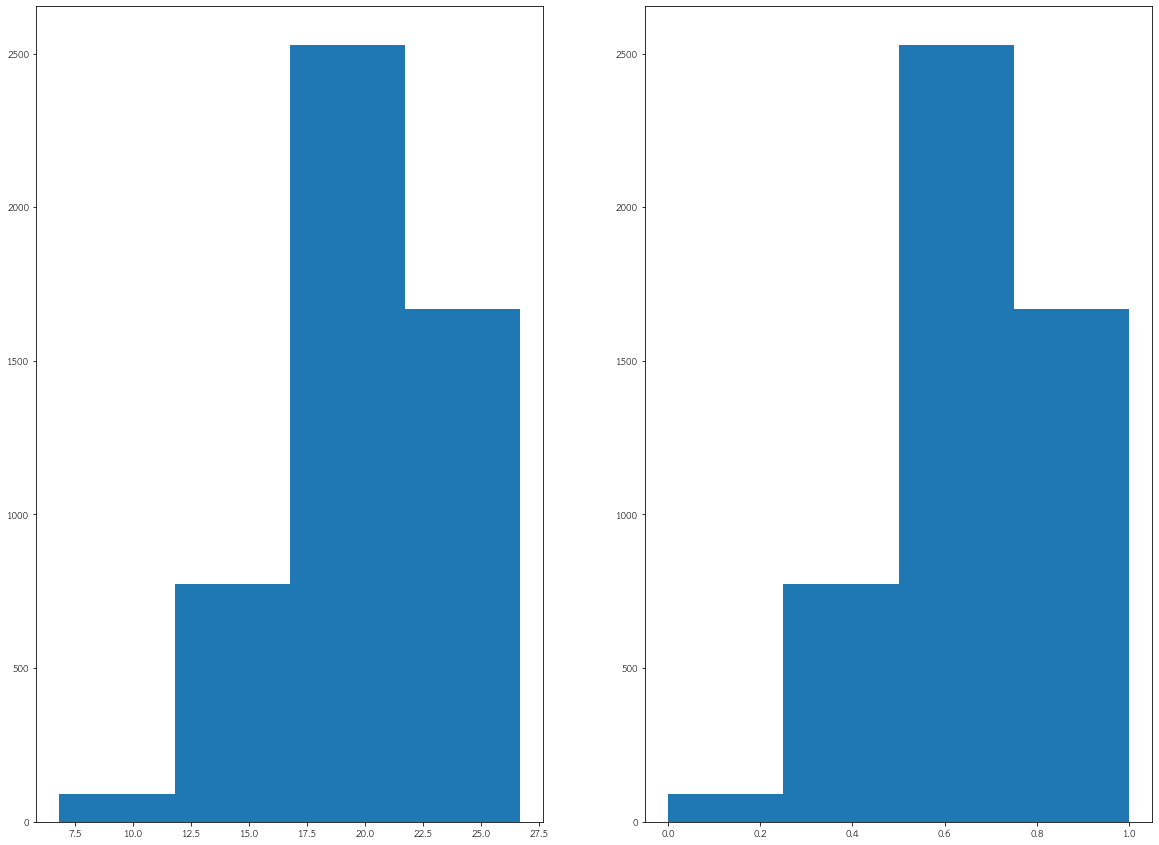

In [2512]:
mpl.rcParams['figure.figsize']=[20,15]

plt. subplot(1,2,1)
plt.hist(weather['อุณหภูมิต่ำสุด'], bins = 4)

plt. subplot(1,2,2)
plt.hist(weather_nor_st_maxmin[:,3],bins = 4);

In [2513]:
weather_nor = pd.DataFrame(weather_nor_st_maxmin, columns = ['ความกด','ความชื้น','อุณหภูมิจุดน้ำค้าง','อุณหภูมิต่ำสุด','จำนวนเมฆ','ปริมาณฝน','ความเร็วลม','อุณหภูมิตุ้มแห้ง'])
weather_nor

,ความกด,ความชื้น,อุณหภูมิจุดน้ำค้าง,อุณหภูมิต่ำสุด,จำนวนเมฆ,ปริมาณฝน,ความเร็วลม,อุณหภูมิตุ้มแห้ง
0,0.142560,0.737705,0.843866,0.904523,0.9,0.012456,0.3,0.718750
1,0.191604,0.885246,0.836431,0.814070,1.0,0.157473,0.2,0.718750
2,0.226517,0.786885,0.795539,0.768844,1.0,0.026690,0.3,0.729167
3,0.259352,0.688525,0.758364,0.804020,0.8,0.000000,0.2,0.651042
4,0.325852,0.786885,0.750929,0.819095,1.0,0.019573,0.2,0.635417
...,...,...,...,...,...,...,...,...
5056,0.714464,0.459016,0.434944,0.361809,0.1,0.000000,0.2,0.463542
5057,0.682461,0.491803,0.475836,0.356784,0.1,0.000000,0.2,0.567708
5058,0.608479,0.442623,0.509294,0.412060,0.0,0.000000,0.1,0.625000
5059,0.551538,0.393443,0.531599,0.537688,0.3,0.000000,0.2,0.708333


In [2514]:
weather_nor.isnull().any()

ความกด                False
ความชื้น              False
อุณหภูมิจุดน้ำค้าง    False
อุณหภูมิต่ำสุด        False
จำนวนเมฆ              False
ปริมาณฝน              False
ความเร็วลม            False
อุณหภูมิตุ้มแห้ง       True
dtype: bool